# COMPAS Data Analysis

## COMPAS
* HP (https://compas.science/)
* GitHub (https://compas.readthedocs.io/en/latest/)
* Patameter List (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification.html)
    * Stellar Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-stellar.html)
    * Binary Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-binary.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import seaborn as sns

import h5py as h5
from astropy.table import  unique, vstack, Table, Column, join
import astropy.units as u
from astropy import constants as const
from scipy.stats import norm as NormDist
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

import sys

In [2]:
# Import functions
##############################
# This path points to the COMPAS functions in your local folder,
# I've redefined most in this notebook anyway, but I was lazy w.r.t the kroupa IMF etc. 
sys.path.insert(0,'/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/')

import FastCosmicIntegration as COMPAS_sfrd
import ClassCOMPAS as COMPAS_class

from importlib import reload  # Python 3.4+
reload(COMPAS_sfrd)

<module 'FastCosmicIntegration' from '/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/FastCosmicIntegration.py'>

In [3]:
######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

## Constant Parameters

In [4]:
G = 6.67428e-8 # Gravitational Constant (dyn cm^2 / g^2)
c = 2.99792458e10 # Light Speed (cm/s)

mp =  1.673e-24 # Proton Mass (g)
me = 9.1093837015e-28 # Electron Mass (g)

Msun = 1.99e33 # Solar Mass (g)
Lsun = 3.839e33 # Solar Luminosity (erg/s)
Rsun = 6.955e10 # Solar Radius (cm)

hr = 3600.0 # Hour (s)
day = 24.0*hr # Day (s)
yr =  365.25*day # Year (s)
Myr = 1e6*yr # Mega Year (s)

q = 4.80320425e-10
r_e = (q**2/(me*c**2))
sigma_T = (8.*np.pi/3.) * r_e**2

sigma = 5.67e-5 #Stefan-Boltzmann Constant (erg/cm^2/K^4/s)

In [5]:
Zsun = 0.014  # Solar Metallicity

## Path Setting

In [6]:
COMPAS_result_dir = '/home/jovyan/COMPAS_02.35.02_N1e7_Fiducial_AllDCO_AIS/'
pathToRate = COMPAS_result_dir+'CosmicIntegration/Rate_info.h5'
pathToData = COMPAS_result_dir+'MainRun/COMPAS_Output_wWeights.h5'

# Read data and put in astropy table
File        = h5.File(pathToData ,'r')

SYS_keys  = ['SEED', 'mixture_weight', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Metallicity@ZAMS(1)', 'CE_Event_Counter', 
             'Merger', 'Optimistic_CE', 'Immediate_RLOF>CE']
RLOF_keys = ['SEED', 'Mass(1)<MT', 'Mass(1)>MT', 'Mass(2)<MT', 'Mass(2)>MT', 'Stellar_Type(1)<MT', 'Stellar_Type(1)>MT', 
             'Stellar_Type(2)<MT', 'Stellar_Type(2)>MT', 'Luminosity(1)', 'Luminosity(2)', 'Radius(1)<MT', 'Radius(2)<MT',
             'SemiMajorAxis<MT', 'SemiMajorAxis>MT', 'Time<MT', 'Time>MT', 'CEE>MT', 'MT_Event_Counter']
CE_keys   = ['SEED', 'CE_Event_Counter', 'Tau_Circ', 'Tau_Dynamical<CE(1)', 'Tau_Dynamical<CE(2)', 
             'Tau_Nuclear<CE(1)', 'Tau_Nuclear<CE(2)', #'Tau_Radial<CE(1)', 'Tau_Radial<CE(2)', 
             'Tau_Thermal<CE(1)', 'Tau_Thermal<CE(2)']

SYS = Table()
for key in SYS_keys:
    SYS[key] = File['BSE_System_Parameters'][key][()]

RLOF = Table()
for key in RLOF_keys:
    RLOF[key] = File['BSE_RLOF'][key][()]

CE = Table()
for key in CE_keys:
    CE[key] = File['BSE_Common_Envelopes'][key][()]
    
File.close()

## Select BH or NS binary

### Stellar Types (see https://ui.adsabs.harvard.edu/abs/2000MNRAS.315..543H/abstract)
* 0: Main Sequence (MS) M < 0.7Msun or fully convective
* 1: MS M > 0.7Msun
* 2: Hertzsprung Gap (HG)
* 3: First Giant Branch
* 4: Core Helium Burning (CHeB)
* 5: Early Asymptotic Giant Branch (EAGB)
* 6: Thermally Pulsing AGB
* 7: Nakid He Star
* 8: Nakid He Star Hertzsprung Gap
* 9: Nakid He Star Giant Branch
* 10: He White Dwarf (He WD)
* 11: C/O WD
* 12: O/Ne WD
* 13: Neutron Star (NS)
* 14: Black Hole (BH)
* 15: massless remnant

In [7]:
# ST15_bool = RLOF['Stellar_Type(1)<MT'] == 15
RLOF_BH_bool = ((np.logical_and(RLOF['Stellar_Type(1)<MT'] == 14, RLOF['Stellar_Type(2)>MT'] < 13)) |
                (np.logical_and(RLOF['Stellar_Type(2)<MT'] == 14, RLOF['Stellar_Type(1)>MT'] < 13)))

RLOF_NS_bool = ((np.logical_and(RLOF['Stellar_Type(1)<MT'] == 13, RLOF['Stellar_Type(2)>MT'] < 13)) |
                (np.logical_and(RLOF['Stellar_Type(2)<MT'] == 13, RLOF['Stellar_Type(1)>MT'] < 13)))

RLOF_BH = RLOF[RLOF_BH_bool]
RLOF_NS = RLOF[RLOF_NS_bool]

## Select Stable (RLOF; CEE>MT == 0) or Unstable Mass Transfer (Common Envelope; CEE>MT == 1)

In [8]:
RLOF_BH_MT = RLOF_BH[RLOF_BH['CEE>MT']==0]
RLOF_BH_CE = RLOF_BH[RLOF_BH['CEE>MT']==1]
RLOF_BH_CE = join(RLOF_BH_CE, CE, keys='SEED', join_type='left')

RLOF_NS_MT = RLOF_NS[RLOF_NS['CEE>MT']==0]
RLOF_NS_CE = RLOF_NS[RLOF_NS['CEE>MT']==1]
RLOF_NS_CE = join(RLOF_NS_CE, CE, keys='SEED', join_type='left')

## Compute Typical Parameters

### Timescale
For stable mass transfer (Roche Lobe Overflow), we assume the accretion timescale ($t_{\rm acc}$) as follows:
$$
t_{\rm acc} \approx t_{\rm Thermal} = \frac{GM^{2}}{2RL} \approx 31 {\rm ~[Myr]}\left(\frac{M}{M_{\odot}}\right)^{2}\left(\frac{R}{R_{\odot}}\right)^{-1}\left(\frac{L}{L_{\odot}}\right)^{-1},
$$
where $M$, $R$, and $L$ are the mass, radius, and luminosity of the donors before the mass transfer derived from COMPAS simulations, respectively.

On the other hand, for unstable mass transfer (Common Envelope), we assume the accretion timescale as follows:
$$
t_{\rm acc} \approx 10\times t_{\rm Orbital} = 2\pi\sqrt{\frac{a^{3}}{G(M_{1} + M_{2})}} \approx 1.6 {\rm ~[yr]}\left(\frac{a}{1000R_{\odot}}\right)^{3/2}\left(\frac{M_1+M_2}{40M_{\odot}}\right)^{-1/2}
$$
where $M_{1}$ and $M_{2}$ are the mass of primery and secondary stars before the mass transfer, respectively, and $a$ is the semi-major axis before the mass transfer.

Note that other tyical timescales of binaries (dynamical timescale ($t_{\rm dyn}$ and nuclear timescale ($t_{\rm nuc}$)) are as follows:
$$
t_{\rm dyn} = \sqrt{\frac{R^{3}}{2GM}} \approx 10^{3} {\rm ~[sec]}~ 
\left(\frac{R}{R_{\odot}}\right)^{3/2}
\left(\frac{M}{M_{\odot}}\right)^{-1/2} \\
t_{\rm nuc, H} = \frac{\frac{\eta X M}{4m_{p}} \times \Delta E_{4H\to He}}{L} = 7{\rm ~[Gyr]}~ 
\left(\frac{\eta}{0.1}\right)
\left(\frac{X}{0.7}\right)
\left(\frac{M}{M_{\odot}}\right)
\left(\frac{\Delta E_{4H\to He}}{26 {\rm ~MeV}}\right)
$$

### Accretion Rate
The Eddington luminosity ($L_{\rm Edd}$) is defined by the balance of the gravity force and radiation pressure:
$$
L_{\rm Edd} = \frac{4\pi c GM m_{p}}{\sigma_{\rm T}} \approx 1.2\times 10^{38} {\rm ~erg/s} \left(\frac{M}{M_{\odot}}\right),
$$
where, $c$ is the light speed, $G$ is the gravitional constant, $m_{p}$ is the proton mass, $\sigma_{\rm T}$ is the cross section of electron scattering, and $M$ is the BH mass.

Then, the Eddington accretion rate is defined as follows:
$$
\dot{M}_{\rm Edd} 
= \frac{L_{\rm Edd}}{\eta c^{2}} 
\approx 1.3 \times 10^{18}{\rm ~g/s} \left(\frac{\eta}{0.1}\right)^{-1}\left(\frac{M}{M_{\odot}}\right)
\approx 2.2 \times 10^{-8}{\rm ~M_{\odot}/yr} \left(\frac{\eta}{0.1}\right)^{-1}\left(\frac{M}{M_{\odot}}\right),
$$
where $\eta$ is the energy conversion efficiency from the accretion rate to luminosity. Here, we assume $\eta = 0.1$, i.e., 10%.

Based on the COMPAS dataset, we defined the accreted mass ($M_{\rm acc}$) from a donor to a compact object as follows:
$$
M_{\rm acc} = (M_{\rm donor,~before~MT} - M_{\rm donor,~after~MT}) - (M_{\rm CO,~after~MT} - M_{\rm CO,~before~MT}),
$$
where, $M_{\rm donor}$ and $M_{\rm CO}$ are the masses of the donor and compact object, and the subscripts of 'before/after MT' mean before or after mass transfter.

Finally, the accretion rate ($\dot{M}$) is defined as follows:
$$
\dot{M} = \frac{\dot{M}}{t_{\rm acc}}, 
$$
and the Eddington ratio ($R_{\rm Edd}$) is described as follows:
$$
R_{\rm Edd} = \frac{\dot{M}}{\dot{M}_{\rm Edd}}
$$

In [9]:
def calculate_kh_timescale(L, R, M):
    return G*(M*Msun)**2 / ((L*Lsun)*(R*Rsun)) / Myr

def calculate_dynamical_timescale(R, M):
    return np.sqrt((R*Rsun)**3 / (2*G*(M*Msun))) / Myr

def calculate_circulation_timescale(a, M1, M2):
    return 2*np.pi*np.sqrt((a*Rsun)**3 / (G*((M1+M2)*Msun))) / Myr

def calculate_eddington_ratio(MBH, M_acc, t, eta=0.1):
    Mdot     = M_acc*Msun / (t*Myr)
    L_edd    = 4*np.pi*G*mp*c*MBH*Msun/sigma_T
    Mdot_edd = L_edd/(eta*c**2)
    return Mdot/Mdot_edd

In [10]:
def calculate_parameters(data, CO_type=14, MT_types='RLOF'):
    
    data['Delay_Time'] = (data['Time<MT'] + data['Time>MT'])/2.0
    data['DT_COMPAS_MT'] = data['Time>MT'] - data['Time<MT']
    
    data['Accreted_Mass'] = np.where(data['Stellar_Type(1)<MT']==CO_type,
                                     (data['Mass(2)<MT']-data['Mass(2)>MT']) - (data['Mass(1)>MT']-data['Mass(1)<MT']),
                                     (data['Mass(1)<MT']-data['Mass(1)>MT']) - (data['Mass(2)>MT']-data['Mass(2)<MT']))

    data['Timescale_KH']  = np.where(data['Stellar_Type(1)<MT']==CO_type,
                                     calculate_kh_timescale(data['Luminosity(2)'], data['Radius(2)<MT'], data['Mass(2)<MT']),
                                     calculate_kh_timescale(data['Luminosity(1)'], data['Radius(1)<MT'], data['Mass(1)<MT']))
    
    data['Timescale_Dyn']  = np.where(data['Stellar_Type(1)<MT']==CO_type,
                                      calculate_dynamical_timescale(data['Radius(2)<MT'], data['Mass(2)<MT']),
                                      calculate_dynamical_timescale(data['Radius(1)<MT'], data['Mass(1)<MT']))
    
    data['Timescale_Cic']  = calculate_circulation_timescale(data['SemiMajorAxis<MT'], data['Mass(1)<MT'], data['Mass(2)<MT'])

    data['Eddington_KH'] = np.where(data['Stellar_Type(1)<MT']==CO_type,
                                    calculate_eddington_ratio(data['Mass(1)<MT'], data['Accreted_Mass'], data['Timescale_KH']),
                                    calculate_eddington_ratio(data['Mass(2)<MT'], data['Accreted_Mass'], data['Timescale_KH']))
    
    data['Eddington_Dyn'] = np.where(data['Stellar_Type(1)<MT']==CO_type,
                                     calculate_eddington_ratio(data['Mass(1)<MT'], data['Accreted_Mass'], 100*data['Timescale_Dyn']),
                                     calculate_eddington_ratio(data['Mass(2)<MT'], data['Accreted_Mass'], 100*data['Timescale_Dyn']))
    
    data['Eddington_Cic'] = np.where(data['Stellar_Type(1)<MT']==CO_type,
                                     calculate_eddington_ratio(data['Mass(1)<MT'], data['Accreted_Mass'], 10*data['Timescale_Cic']),
                                     calculate_eddington_ratio(data['Mass(2)<MT'], data['Accreted_Mass'], 10*data['Timescale_Cic']))
    
    if MT_types == 'RLOF':
        data['Timescale'] = data['Timescale_KH']
        data['Eddington'] = data['Eddington_KH']
    elif MT_types == 'CE':
        data['Timescale'] = data['Timescale_Cic']
        data['Eddington'] = data['Eddington_Cic']
    
    return data

In [11]:
RLOF_BH_MT = calculate_parameters(RLOF_BH_MT, CO_type=14, MT_types='RLOF')
RLOF_BH_CE = calculate_parameters(RLOF_BH_CE, CO_type=14, MT_types='CE')

RLOF_NS_MT = calculate_parameters(RLOF_NS_MT, CO_type=13, MT_types='RLOF')
RLOF_NS_CE = calculate_parameters(RLOF_NS_CE, CO_type=13, MT_types='CE')

# An Error Message will come up. This error is caused by L=0.0 in the calculation for the KH timescale. 
# I will take this error into account later. See also following MEMO.

/tmp/ipykernel_1295/4143798075.py:2: RuntimeWarning: divide by zero encountered in divide
  return G*(M*Msun)**2 / ((L*Lsun)*(R*Rsun)) / Myr


## Select Super-Eddington Sysmtems ($\dot{M}/\dot{M}_{\rm Edd} > 10$)

In [12]:
def filter_eddington_ratio(data, Eddington_Min=10, Flag_All=None):
    
    if Flag_All==None:
        data = data[data['Eddington']>Eddington_Min].group_by('SEED')
        group_by_Eddington_Max = data['SEED', 'Eddington'].groups.aggregate(np.max)
        data_Eddington = data[np.in1d(data['Eddington'], group_by_Eddington_Max['Eddington'])]
    else:
        data_Eddington = data[data['Eddington']>Eddington_Min]
    
    return data_Eddington

In [13]:
RLOF_BH_MT_Edd = filter_eddington_ratio(RLOF_BH_MT, Eddington_Min=10)
RLOF_BH_CE_Edd = filter_eddington_ratio(RLOF_BH_CE, Eddington_Min=10)

RLOF_NS_MT_Edd = filter_eddington_ratio(RLOF_NS_MT, Eddington_Min=10)
RLOF_NS_CE_Edd = filter_eddington_ratio(RLOF_NS_CE, Eddington_Min=10)

In [14]:
RLOF_BH_MT_Edd_All = filter_eddington_ratio(RLOF_BH_MT, Eddington_Min=10, Flag_All=True)
RLOF_BH_CE_Edd_All = filter_eddington_ratio(RLOF_BH_CE, Eddington_Min=10, Flag_All=True)

RLOF_NS_MT_Edd_All = filter_eddington_ratio(RLOF_NS_MT, Eddington_Min=10, Flag_All=True)
RLOF_NS_CE_Edd_All = filter_eddington_ratio(RLOF_NS_CE, Eddington_Min=10, Flag_All=True)

In [15]:
# release memory
del RLOF_BH_MT, RLOF_BH_CE, RLOF_NS_MT, RLOF_NS_CE

## Select Metallicity

In [16]:
SYS_HighZ = SYS[SYS['Metallicity@ZAMS(1)'] > Zsun/10]
SYS_LowZ = SYS[SYS['Metallicity@ZAMS(1)'] <= Zsun/10]

In [17]:
RLOF_BH_MT_Edd_HighZ = RLOF_BH_MT_Edd[np.in1d(RLOF_BH_MT_Edd['SEED'], SYS_HighZ['SEED'])]
RLOF_BH_MT_Edd_LowZ = RLOF_BH_MT_Edd[np.in1d(RLOF_BH_MT_Edd['SEED'], SYS_LowZ['SEED'])]

RLOF_BH_CE_Edd_HighZ = RLOF_BH_CE_Edd[np.in1d(RLOF_BH_CE_Edd['SEED'], SYS_HighZ['SEED'])]
RLOF_BH_CE_Edd_LowZ = RLOF_BH_CE_Edd[np.in1d(RLOF_BH_CE_Edd['SEED'], SYS_LowZ['SEED'])]

RLOF_NS_MT_Edd_HighZ = RLOF_NS_MT_Edd[np.in1d(RLOF_NS_MT_Edd['SEED'], SYS_HighZ['SEED'])]
RLOF_NS_MT_Edd_LowZ = RLOF_NS_MT_Edd[np.in1d(RLOF_NS_MT_Edd['SEED'], SYS_LowZ['SEED'])]

RLOF_NS_CE_Edd_HighZ = RLOF_NS_CE_Edd[np.in1d(RLOF_NS_CE_Edd['SEED'], SYS_HighZ['SEED'])]
RLOF_NS_CE_Edd_LowZ = RLOF_NS_CE_Edd[np.in1d(RLOF_NS_CE_Edd['SEED'], SYS_LowZ['SEED'])]

## Check Stellar Types

In [18]:
def filter_stellar_types(data, Stellar_Type_Bofore, Flag_After=False, Stellar_Type_After=1):
    
    ST_bool_bofore = (data['Stellar_Type(1)<MT'] == Stellar_Type_Bofore) | (data['Stellar_Type(2)<MT'] == Stellar_Type_Bofore)
    
    if (Flag_After==False):
        return data[ST_bool_bofore]
    else:
        ST_bool_after = (data['Stellar_Type(1)>MT'] == Stellar_Type_After) | (data['Stellar_Type(2)>MT'] == Stellar_Type_After)
        ST_bool = np.logical_and(ST_bool_bofore, ST_bool_after)
        return data[ST_bool]

In [19]:
RLOF_BH_MT_Edd_ST1 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=1)
RLOF_BH_MT_Edd_ST2 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=2)
RLOF_BH_MT_Edd_ST3 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=3)
RLOF_BH_MT_Edd_ST4 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=4)
RLOF_BH_MT_Edd_ST5 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=5)
RLOF_BH_MT_Edd_ST6 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=6)
RLOF_BH_MT_Edd_ST7 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=7)
RLOF_BH_MT_Edd_ST8 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=8)
RLOF_BH_MT_Edd_ST9 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=9)

In [21]:
RLOF_BH_MT_Edd_ST2to2 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=2)
RLOF_BH_MT_Edd_ST2to4 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=4)
RLOF_BH_MT_Edd_ST2to7 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=7)
RLOF_BH_MT_Edd_ST2to10 = filter_stellar_types(RLOF_BH_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=10)

In [42]:
RLOF_NS_MT_Edd_ST1 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=1)
RLOF_NS_MT_Edd_ST2 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=2)
RLOF_NS_MT_Edd_ST3 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=3)
RLOF_NS_MT_Edd_ST4 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=4)
RLOF_NS_MT_Edd_ST5 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=5)
RLOF_NS_MT_Edd_ST6 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=6)
RLOF_NS_MT_Edd_ST7 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=7)
RLOF_NS_MT_Edd_ST8 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=8)
RLOF_NS_MT_Edd_ST9 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=9)

In [43]:
RLOF_NS_MT_Edd_ST2to2 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=2)
RLOF_NS_MT_Edd_ST2to4 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=4)
RLOF_NS_MT_Edd_ST2to7 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=7)
RLOF_NS_MT_Edd_ST2to10 = filter_stellar_types(RLOF_NS_MT_Edd, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=10)

##### MEMO

In some Common Envelope cases, the luminosity of donors is zero in the original COMPAS output.
This bug are occured in some AGB stars (Stellar Type = 5).<br>
Thus, we drop the datasets including the bugs.

In [44]:
RLOF_BH_CE_Edd_Dropinf = RLOF_BH_CE_Edd[np.isfinite(RLOF_BH_CE_Edd['Timescale_KH'])]
RLOF_NS_CE_Edd_Dropinf = RLOF_NS_CE_Edd[np.isfinite(RLOF_NS_CE_Edd['Timescale_KH'])]

In [45]:
RLOF_BH_CE_Edd_ST1 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=1)
RLOF_BH_CE_Edd_ST2 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=2)
RLOF_BH_CE_Edd_ST3 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=3)
RLOF_BH_CE_Edd_ST4 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=4)
RLOF_BH_CE_Edd_ST5 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=5)
RLOF_BH_CE_Edd_ST6 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=6)
RLOF_BH_CE_Edd_ST7 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=7)
RLOF_BH_CE_Edd_ST8 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=8)
RLOF_BH_CE_Edd_ST9 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=9)

In [46]:
RLOF_BH_CE_Edd_ST2to2 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=2)
RLOF_BH_CE_Edd_ST2to4 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=4)
RLOF_BH_CE_Edd_ST2to7 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=7)
RLOF_BH_CE_Edd_ST2to10 = filter_stellar_types(RLOF_BH_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=10)

In [47]:
RLOF_NS_CE_Edd_ST1 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=1)
RLOF_NS_CE_Edd_ST2 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=2)
RLOF_NS_CE_Edd_ST3 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=3)
RLOF_NS_CE_Edd_ST4 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=4)
RLOF_NS_CE_Edd_ST5 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=5)
RLOF_NS_CE_Edd_ST6 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=6)
RLOF_NS_CE_Edd_ST7 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=7)
RLOF_NS_CE_Edd_ST8 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=8)
RLOF_NS_CE_Edd_ST9 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=9)

In [48]:
RLOF_NS_CE_Edd_ST2to2 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=2)
RLOF_NS_CE_Edd_ST2to4 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=4)
RLOF_NS_CE_Edd_ST2to7 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=7)
RLOF_NS_CE_Edd_ST2to10 = filter_stellar_types(RLOF_NS_CE_Edd_Dropinf, Stellar_Type_Bofore=2, Flag_After=True, Stellar_Type_After=10)

##### Check: binary mass
* Naively, MS stars cannot satisfy its Roche lobe ?

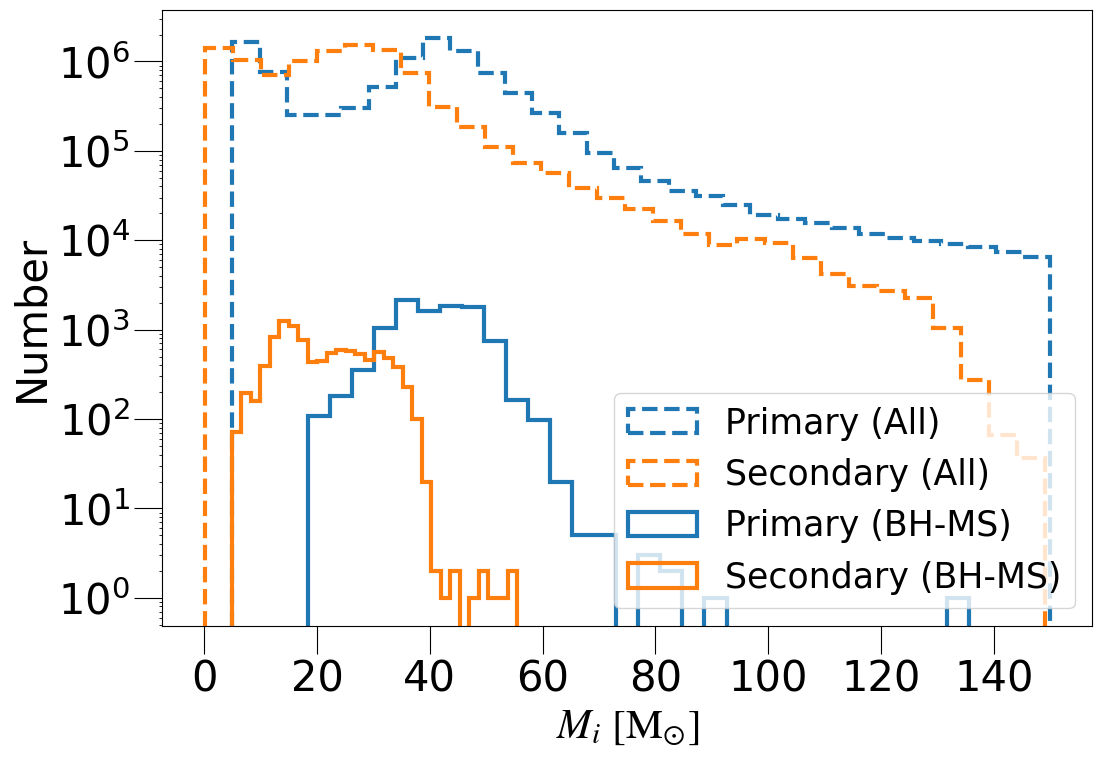

In [49]:
SYS_BHMS = SYS[np.in1d(SYS['SEED'], RLOF_BH_MT_Edd_ST1['SEED'])]

fig, ax = plt.subplots(figsize = (12,8))

plt.hist(SYS['Mass@ZAMS(1)'], bins=30, color='tab:blue', alpha=1, histtype='step', label='Primary (All)', lw=3, linestyle='dashed')
plt.hist(SYS['Mass@ZAMS(2)'], bins=30, color='tab:orange', alpha=1, histtype='step', label='Secondary (All)', lw=3, linestyle='dashed')

plt.hist(SYS_BHMS['Mass@ZAMS(1)'], bins=30, color='tab:blue', alpha=1, histtype='step', label='Primary (BH-MS)', lw=3)
plt.hist(SYS_BHMS['Mass@ZAMS(2)'], bins=30, color='tab:orange', alpha=1, histtype='step', label='Secondary (BH-MS)', lw=3)


ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.legend()

plt.yscale('log')
    
plt.xlabel(r'$M_{i} {\rm ~[M_{\odot}]}$', fontsize = 30)
plt.ylabel(r'Number', fontsize = 30)
plt.savefig('./Figures/useful_figures/mass_distribution_BH_ST1.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

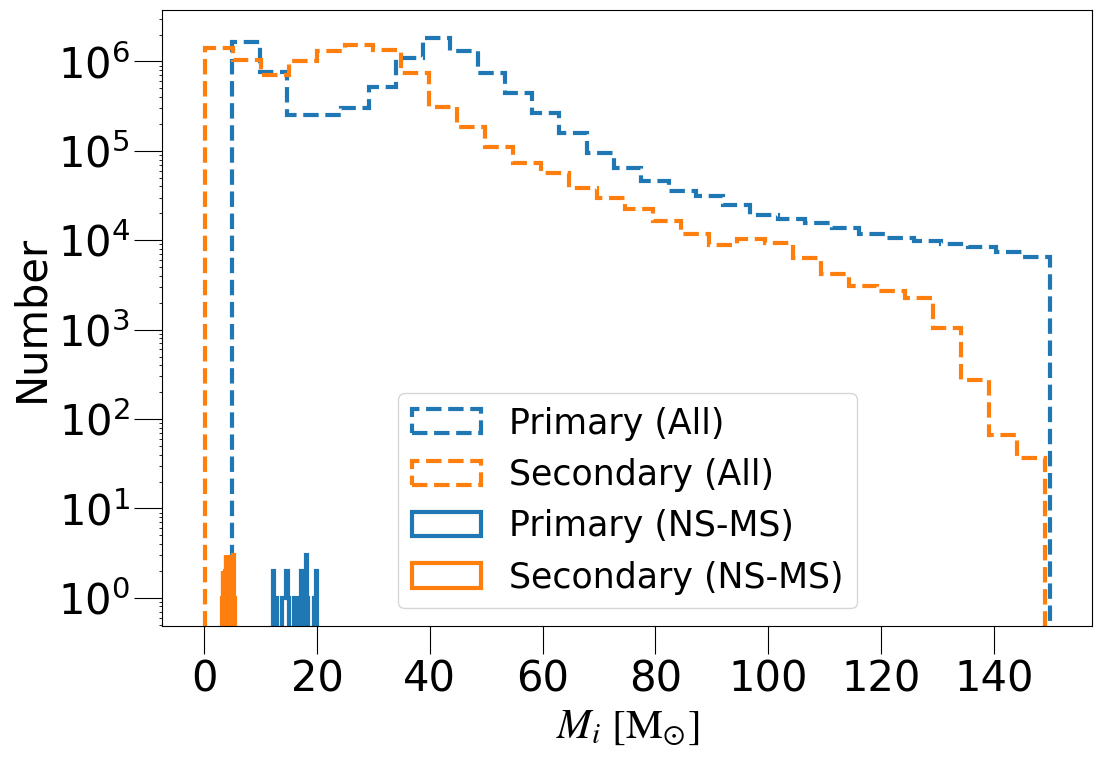

In [50]:
SYS_NSMS = SYS[np.in1d(SYS['SEED'], RLOF_NS_MT_Edd_ST1['SEED'])]

fig, ax = plt.subplots(figsize = (12,8))

plt.hist(SYS['Mass@ZAMS(1)'], bins=30, color='tab:blue', alpha=1, histtype='step', label='Primary (All)', lw=3, linestyle='dashed')
plt.hist(SYS['Mass@ZAMS(2)'], bins=30, color='tab:orange', alpha=1, histtype='step', label='Secondary (All)', lw=3, linestyle='dashed')

plt.hist(SYS_NSMS['Mass@ZAMS(1)'], bins=30, color='tab:blue', alpha=1, histtype='step', label='Primary (NS-MS)', lw=3)
plt.hist(SYS_NSMS['Mass@ZAMS(2)'], bins=30, color='tab:orange', alpha=1, histtype='step', label='Secondary (NS-MS)', lw=3)


ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.legend()

plt.yscale('log')
    
plt.xlabel(r'$M_{i} {\rm ~[M_{\odot}]}$', fontsize = 30)
plt.ylabel(r'Number', fontsize = 30)
plt.savefig('./Figures/useful_figures/mass_distribution_NS_ST1.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

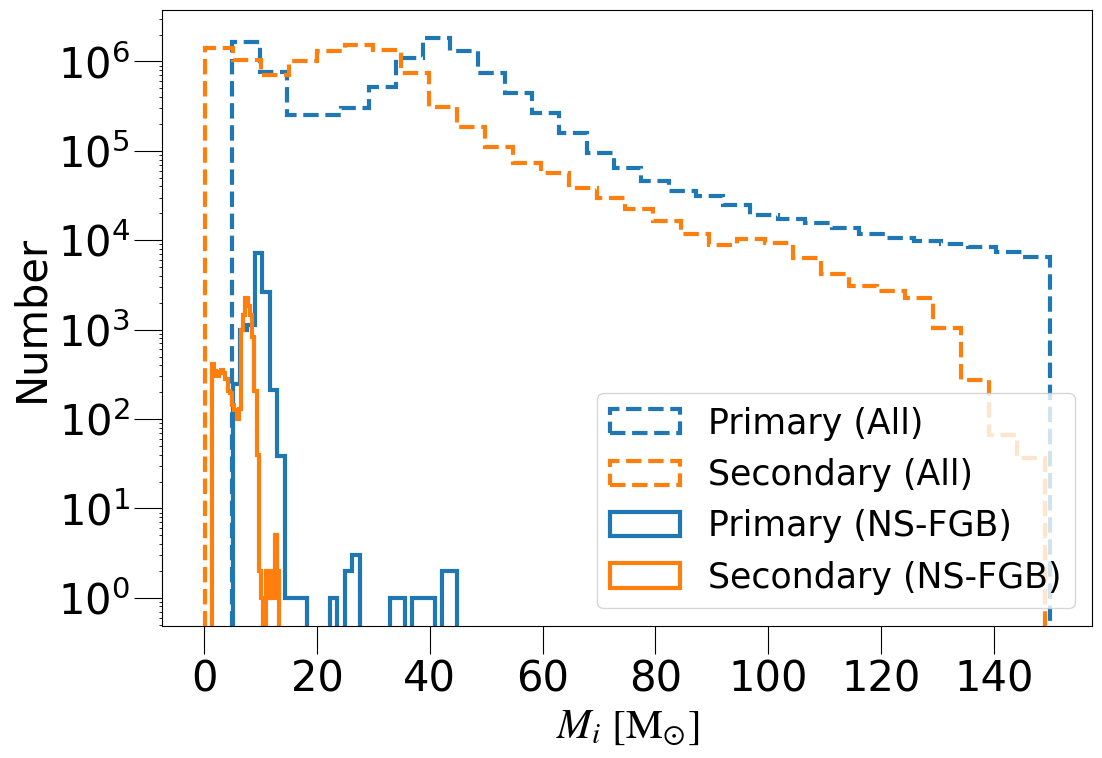

In [52]:
SYS_NSST3 = SYS[np.in1d(SYS['SEED'], RLOF_NS_CE_Edd_ST3['SEED'])]

fig, ax = plt.subplots(figsize = (12,8))

plt.hist(SYS['Mass@ZAMS(1)'], bins=30, color='tab:blue', alpha=1, histtype='step', label='Primary (All)', lw=3, linestyle='dashed')
plt.hist(SYS['Mass@ZAMS(2)'], bins=30, color='tab:orange', alpha=1, histtype='step', label='Secondary (All)', lw=3, linestyle='dashed')

plt.hist(SYS_NSST3['Mass@ZAMS(1)'], bins=30, color='tab:blue', alpha=1, histtype='step', label='Primary (NS-FGB)', lw=3)
plt.hist(SYS_NSST3['Mass@ZAMS(2)'], bins=30, color='tab:orange', alpha=1, histtype='step', label='Secondary (NS-FGB)', lw=3)


ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.legend()

plt.yscale('log')
    
plt.xlabel(r'$M_{i} {\rm ~[M_{\odot}]}$', fontsize = 30)
plt.ylabel(r'Number', fontsize = 30)
plt.savefig('./Figures/useful_figures/mass_distribution_NS_ST3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Plot 2D Histgram ($\dot{M}/\dot{M}_{\rm Edd}$ vs. $t_{\rm acc}$)

In [28]:
def plot_2d_histgram_mt_mdot_vs_tacc (data, Mdot_bin, Tacc_bin, output, Colormap='viridis', Bin_Guide=False):
    
    x_value = data['Eddington'].value
    y_value = data['Timescale'].value
    
    N, x, y = np.histogram2d(x_value, y_value, bins=(Mdot_bin, Tacc_bin))

    fig, ax = plt.subplots(figsize = (12,8))
    
    pcm = ax.pcolormesh(np.log10(x), np.log10(y*Myr/yr), N.T, cmap=Colormap, norm=LogNorm())
    cbar = plt.colorbar(pcm, ax=ax, label='Number N')
    cbar.ax.tick_params(labelsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=20, size=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.locator_params(axis='y', nbins=6)

    plt.xlim(1.0, 6.25)
    plt.ylim(1.0, 7.0)
    
    if Bin_Guide == True:
        for i in range(len(Mdot_bin)):
            plt.axvline(np.log10(Mdot_bin[i]), color='gray')
    
        for i in range(len(Tacc_bin)):
            plt.axhline(np.log10(Tacc_bin[i]*Myr/yr), color='gray')

    
    plt.xlabel(r'$\log(\dot{M} / \dot{M}_{\rm Edd})$', fontsize = 30)
    plt.ylabel(r'$\log(t_{\rm acc} {\rm ~[yr]})$', fontsize = 30)
    plt.savefig('./Figures/N/{}'.format(output), bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [29]:
Mdot_BH_value_MT_Edd = RLOF_BH_MT_Edd['Eddington'].value
Tacc_BH_value_MT_Edd = RLOF_BH_MT_Edd['Timescale'].value

Mdot_BH_bin_MT_Edd_100 = np.logspace(np.log10(Mdot_BH_value_MT_Edd.min()), np.log10(Mdot_BH_value_MT_Edd.max()), 100)
Tacc_BH_bin_MT_Edd_100 = np.logspace(np.log10(Tacc_BH_value_MT_Edd.min()), np.log10(Tacc_BH_value_MT_Edd.max()), 100)

Mdot_NS_value_MT_Edd = RLOF_NS_MT_Edd['Eddington'].value
Tacc_NS_value_MT_Edd = RLOF_NS_MT_Edd['Timescale'].value

Mdot_NS_bin_MT_Edd_100 = np.logspace(np.log10(Mdot_NS_value_MT_Edd.min()), np.log10(Mdot_NS_value_MT_Edd.max()), 100)
Tacc_NS_bin_MT_Edd_100 = np.logspace(np.log10(Tacc_NS_value_MT_Edd.min()), np.log10(Tacc_NS_value_MT_Edd.max()), 100)

Mdot_bin_MT_Edd_grid = 10**np.array([1.0, 1.25, 1.75, 2.25, 2.75, 3.125, 3.375, 3.625, 3.875,
                                     4.125, 4.375, 4.625, 4.875, 5.125, 5.375, 5.625, 5.875, 6.25]) #18
Tacc_bin_MT_Edd_grid = 10**np.array([1.0, 1.75, 2.25, 2.625, 2.875, 3.125, 3.375, 3.625, 3.875,
                                     4.125, 4.375, 4.75, 5.25, 5.75, 6.25, 7.0])/1e6 #16

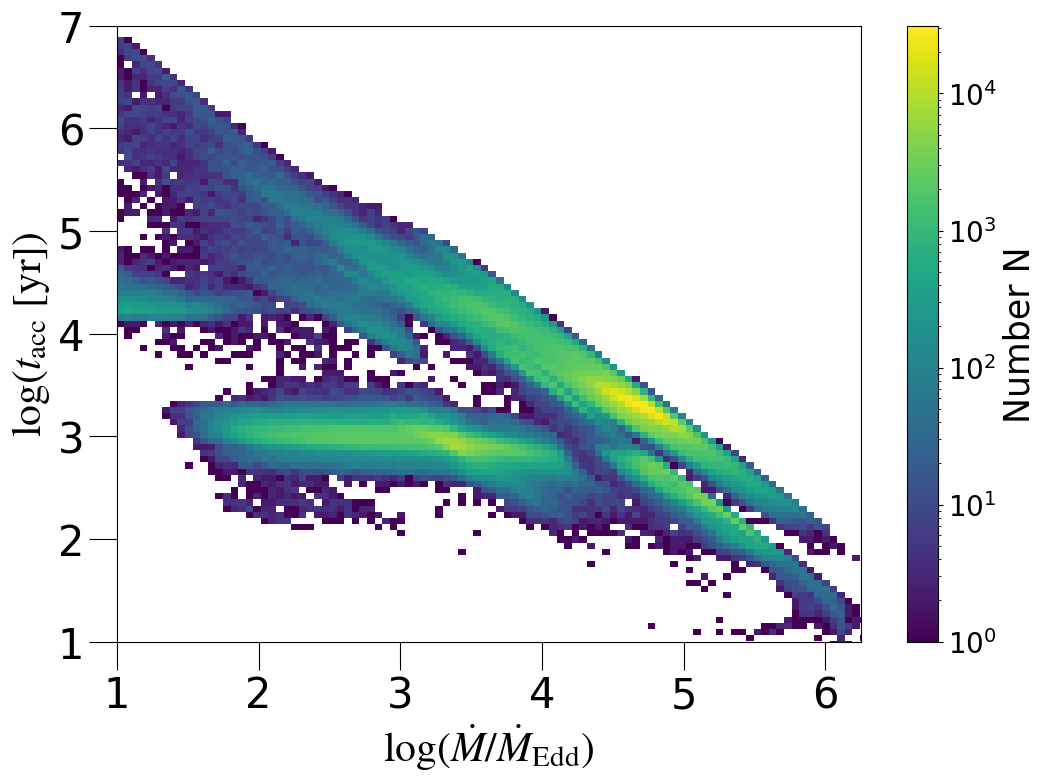

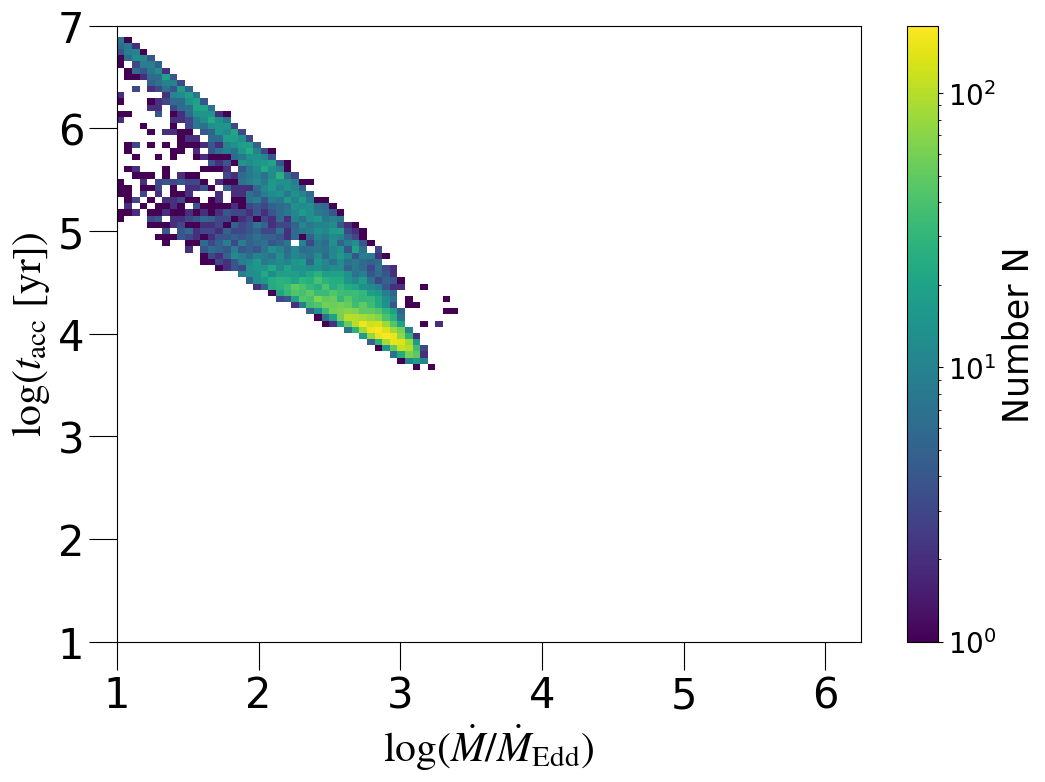

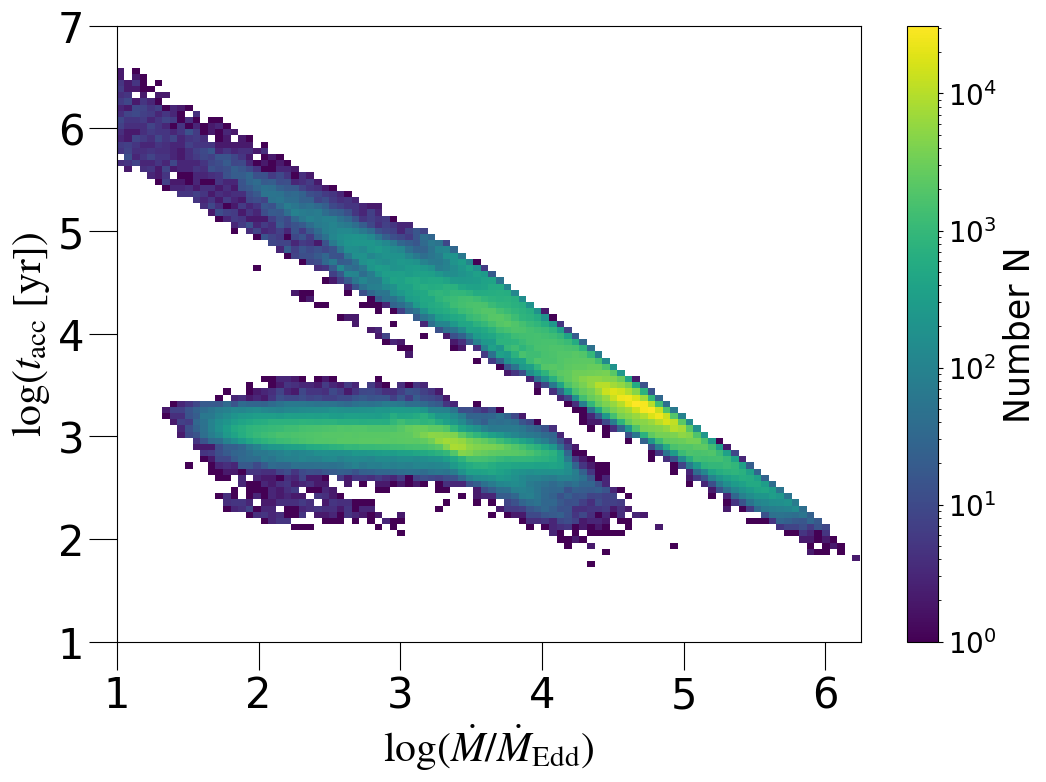

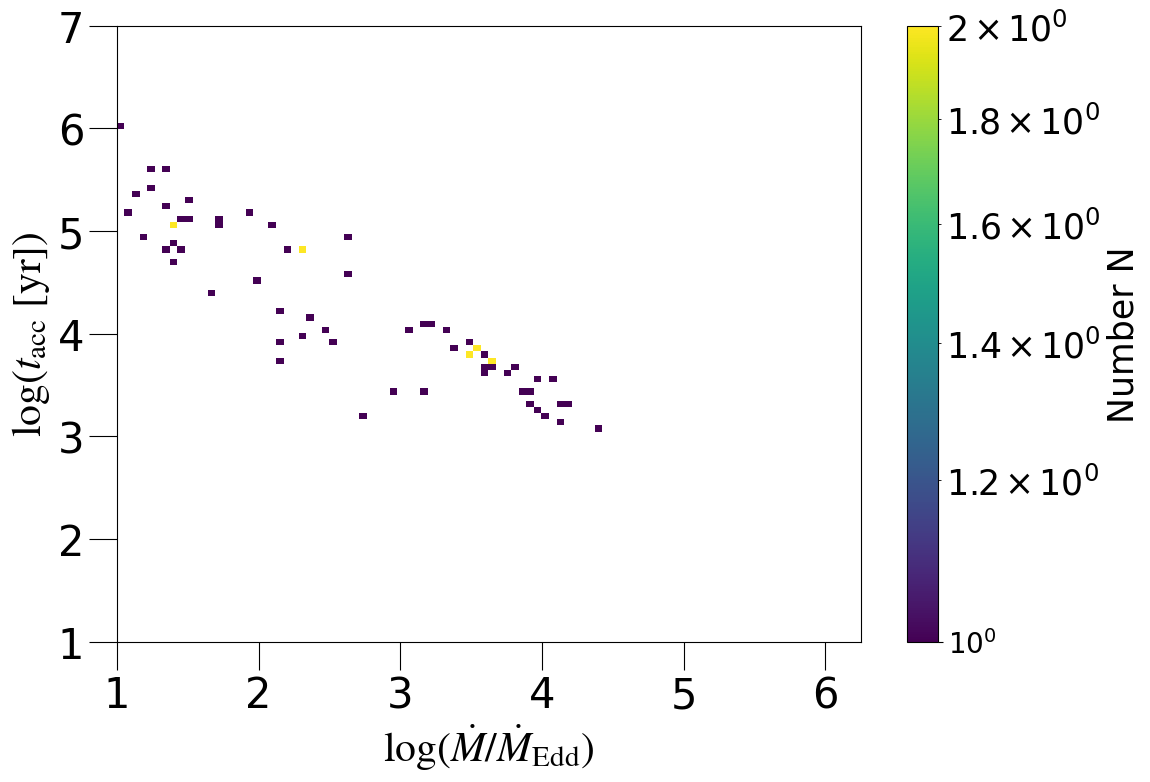

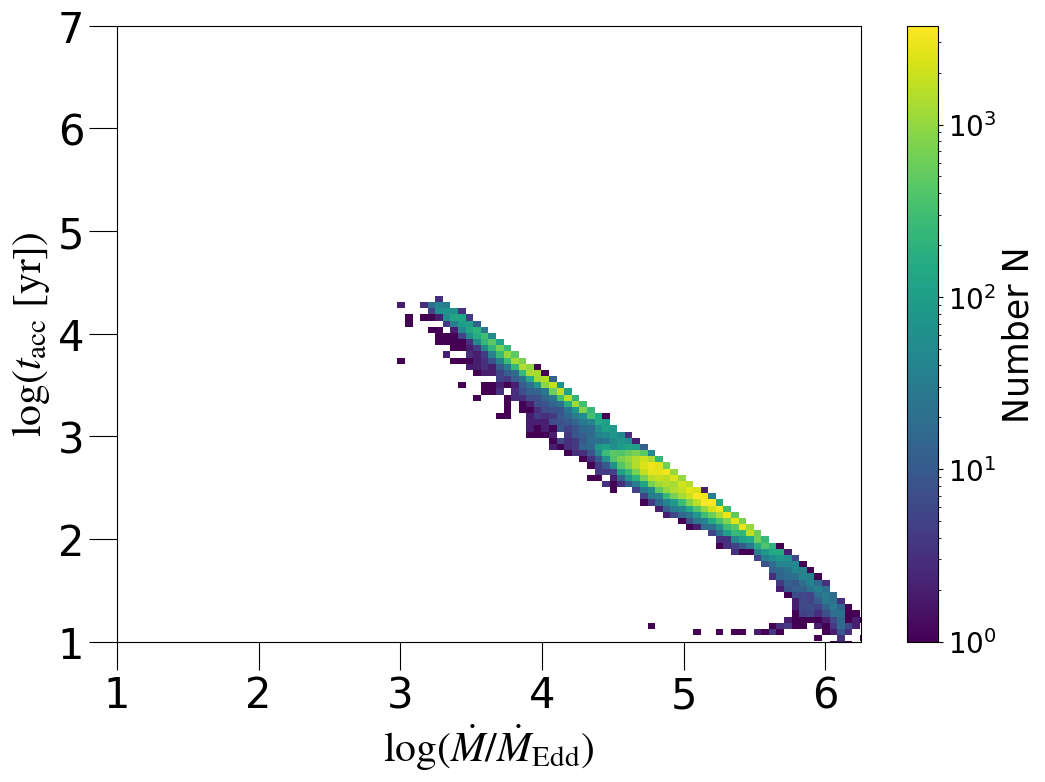

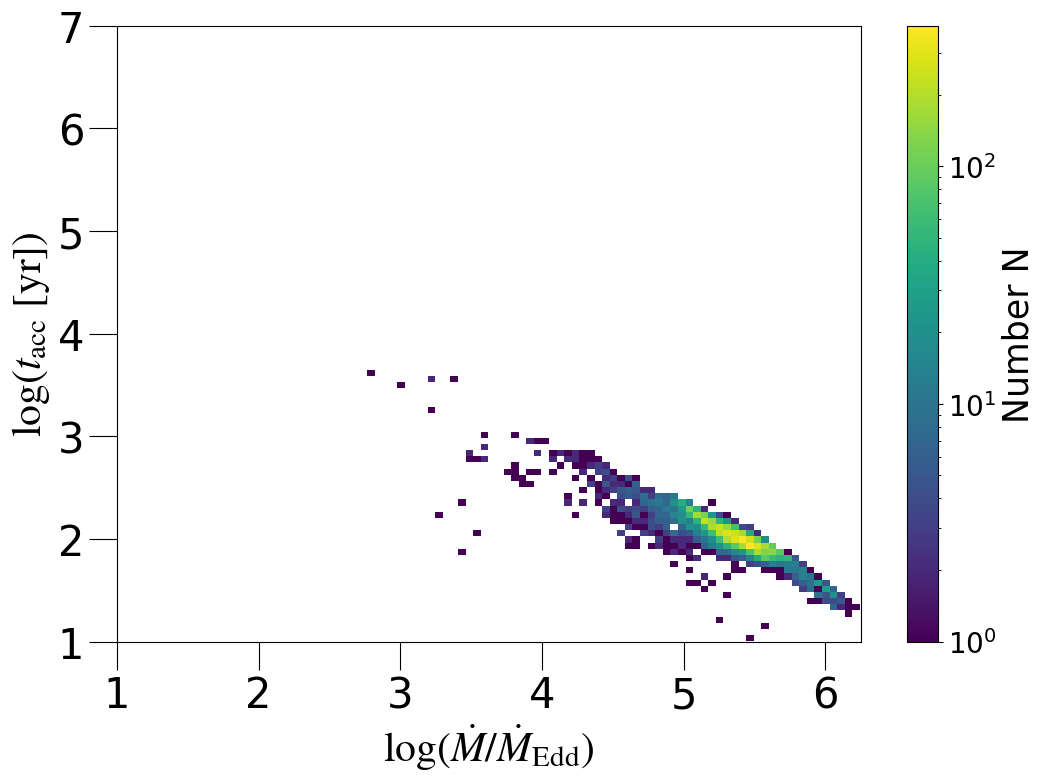

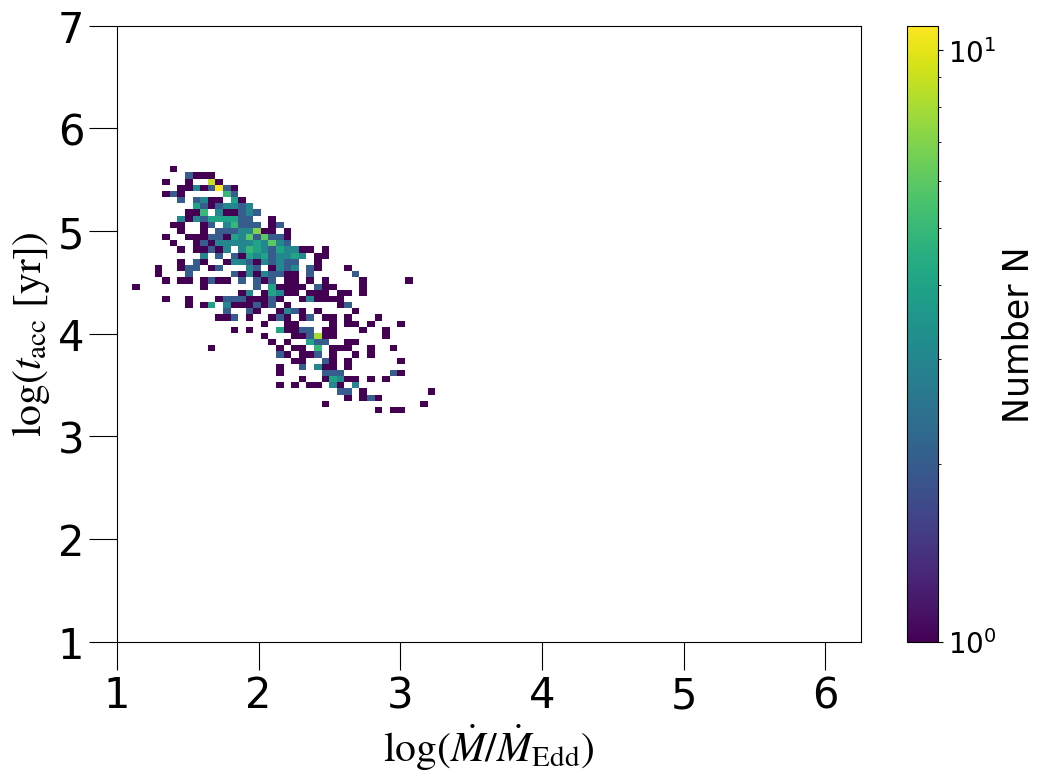

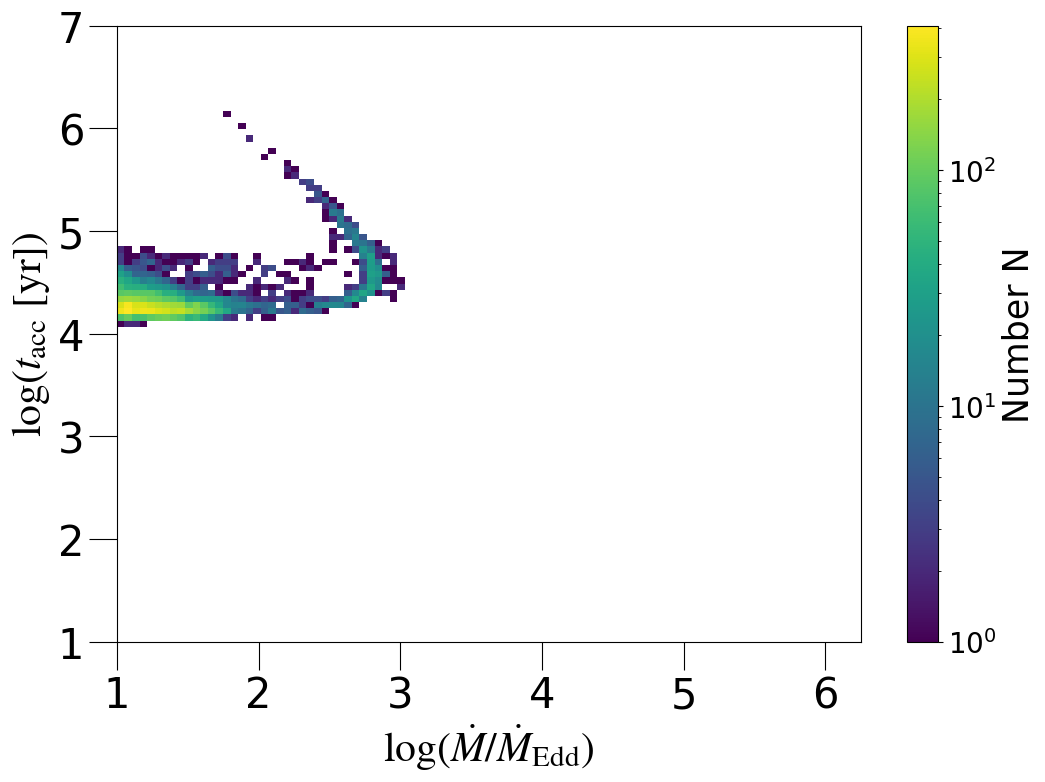

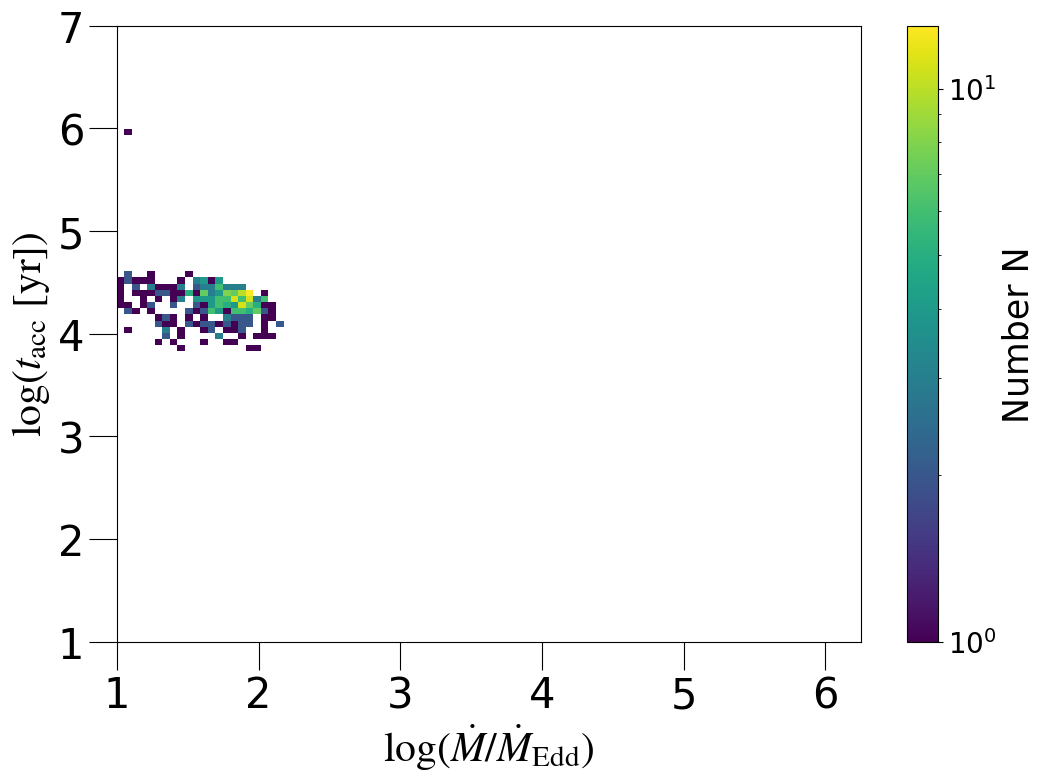

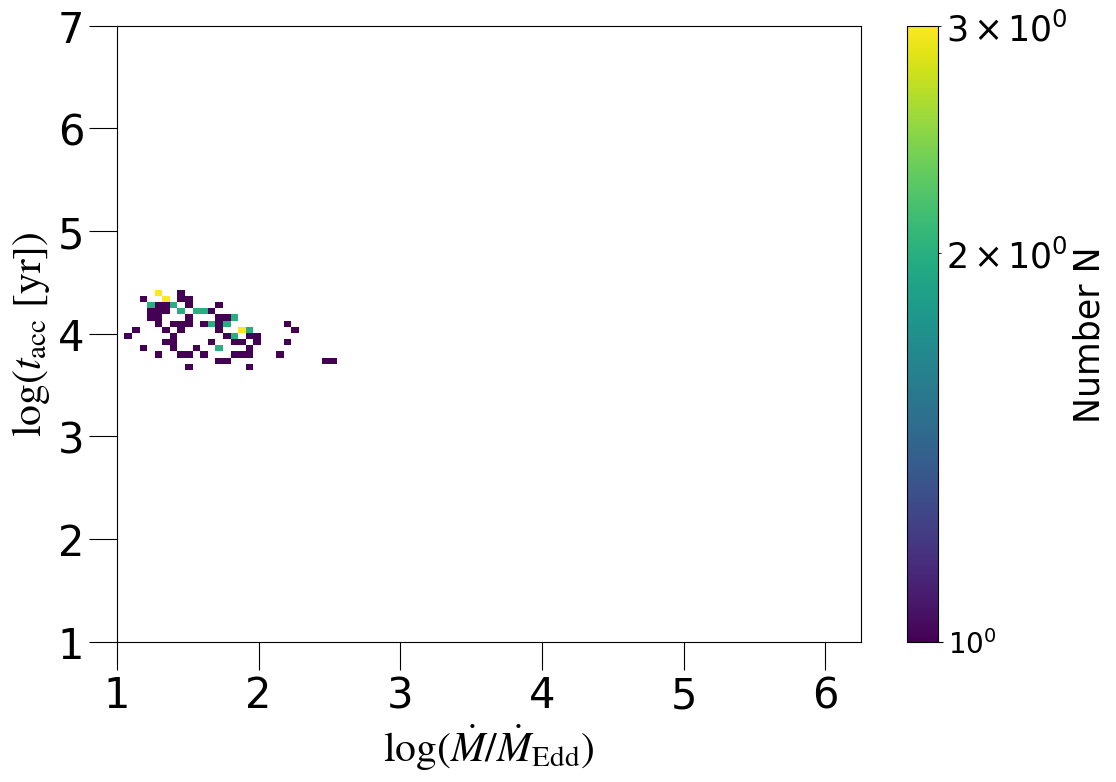

In [30]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST1, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST1_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST2, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST2_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST3, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST3_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST4, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST4_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST5, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST5_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST6, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST6_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST7, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST7_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST8, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST8_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST9, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST9_100.pdf')

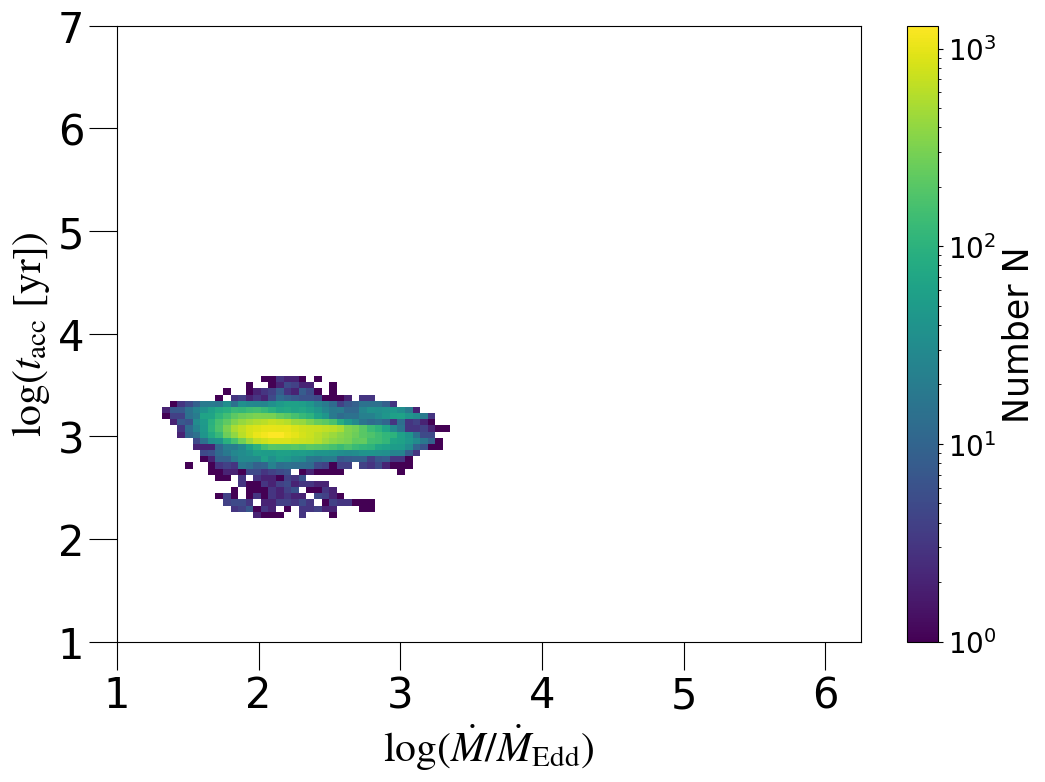

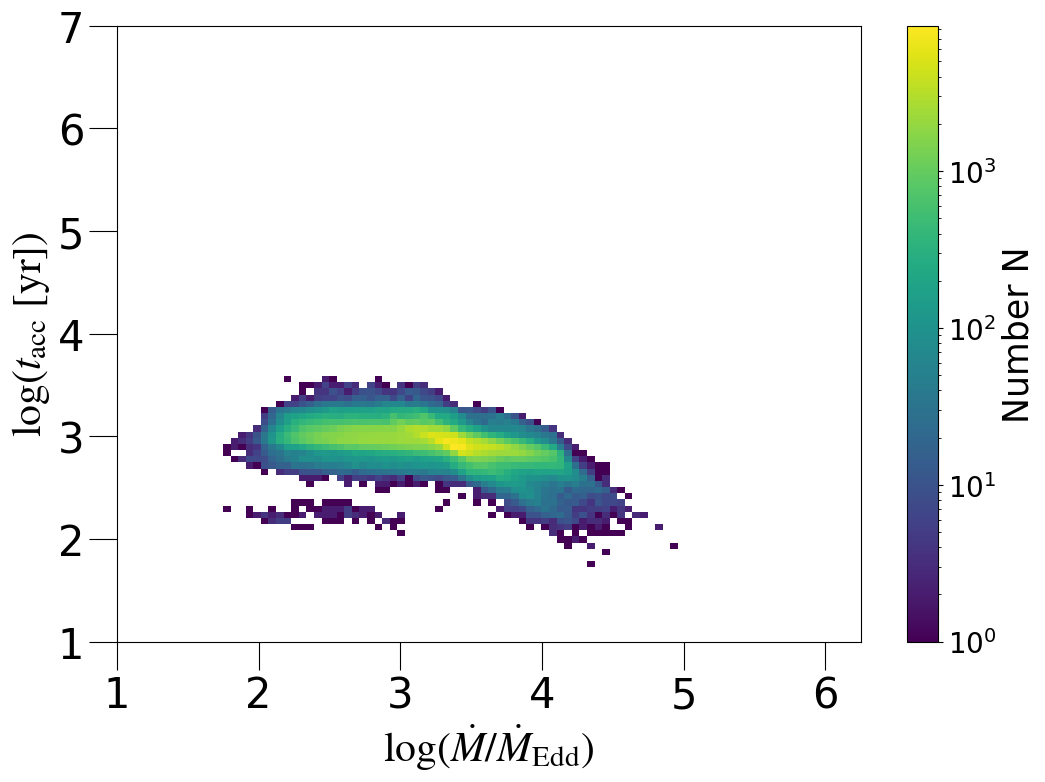

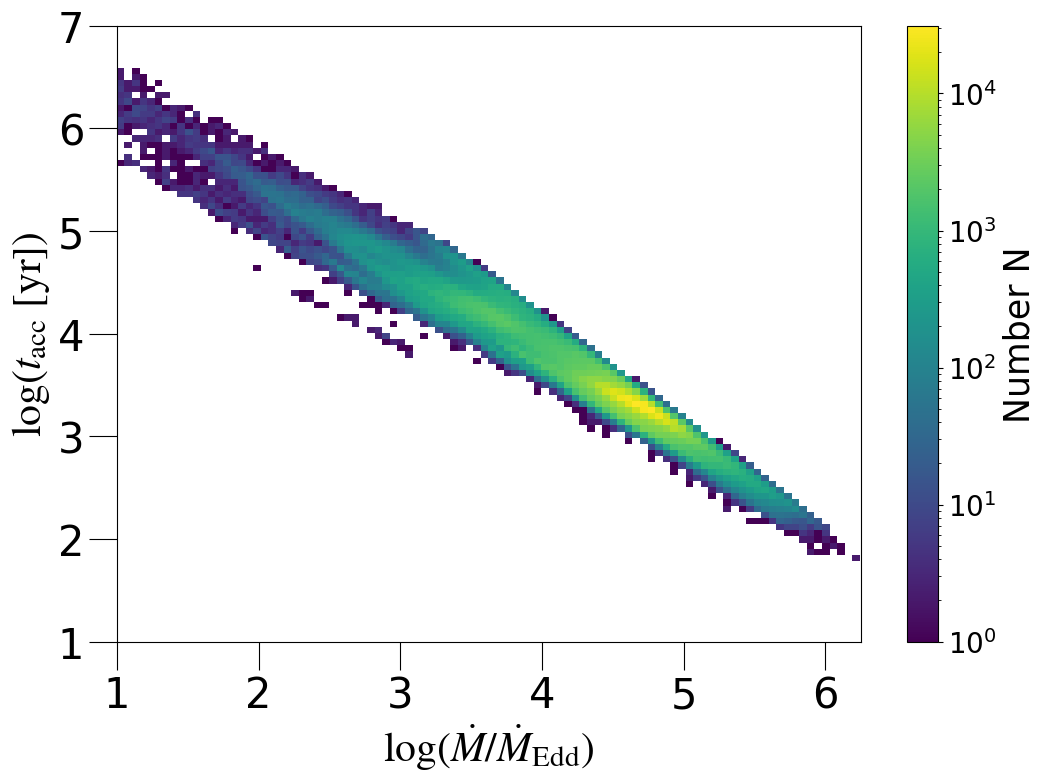

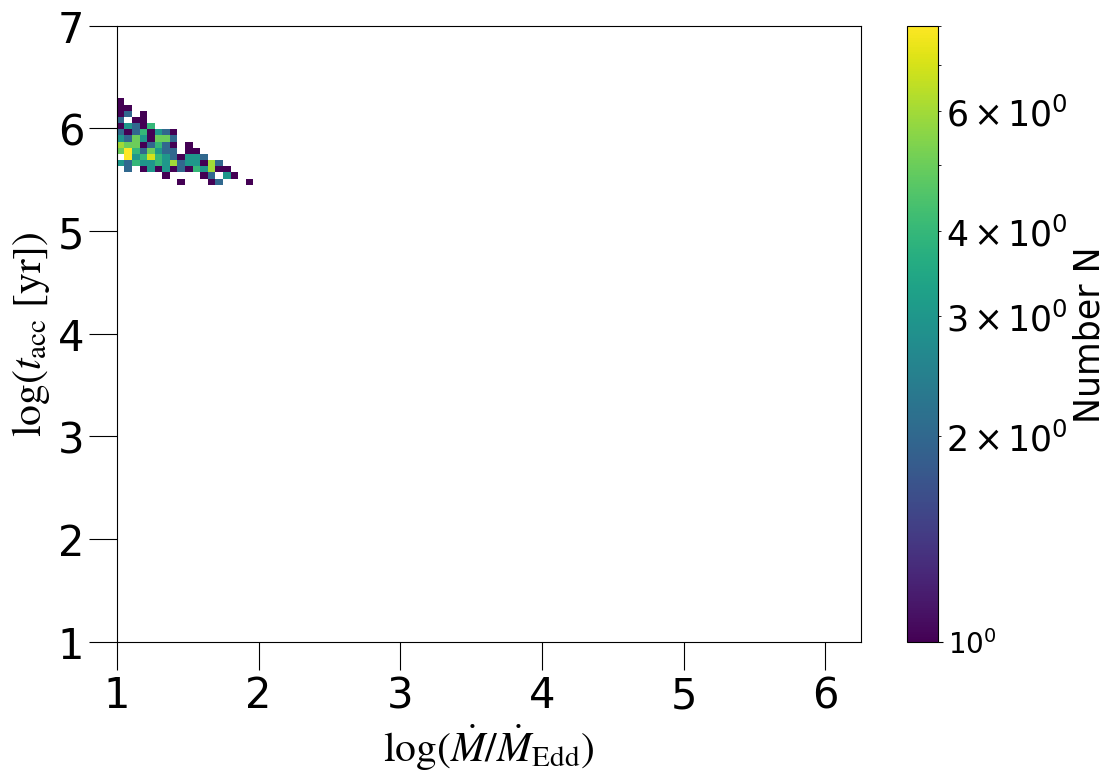

In [31]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST2to2, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST2to2_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST2to4, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST2to4_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST2to7, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST2to7_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_ST2to10, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_ST2to10_100.pdf')

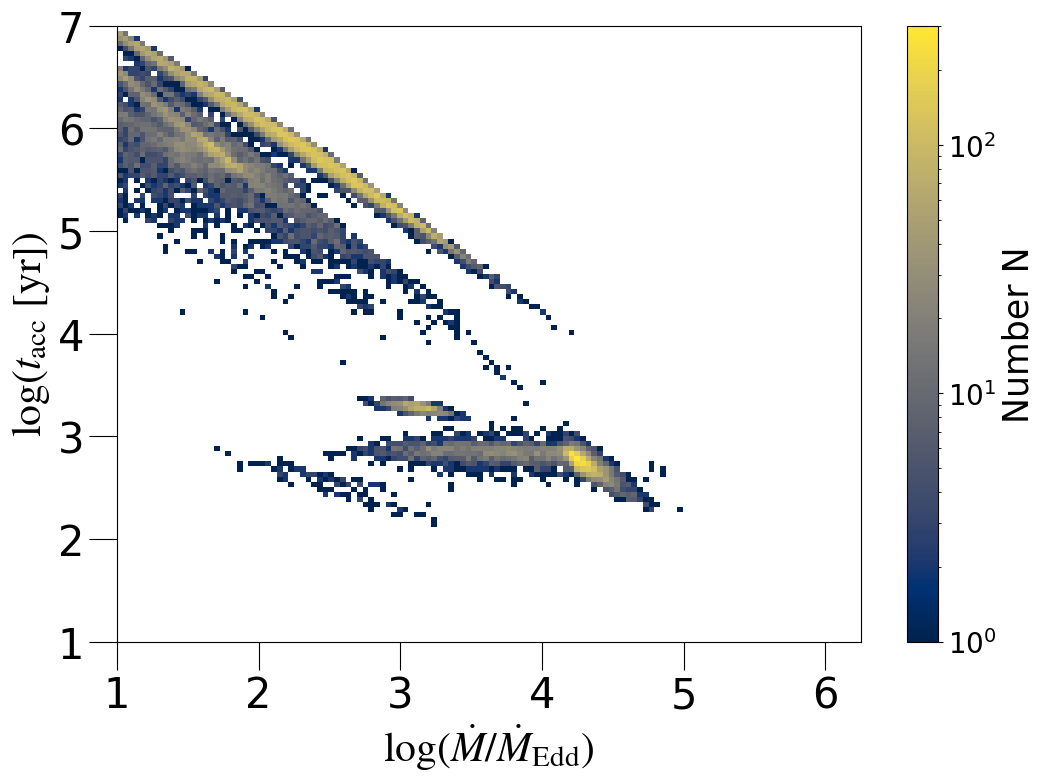

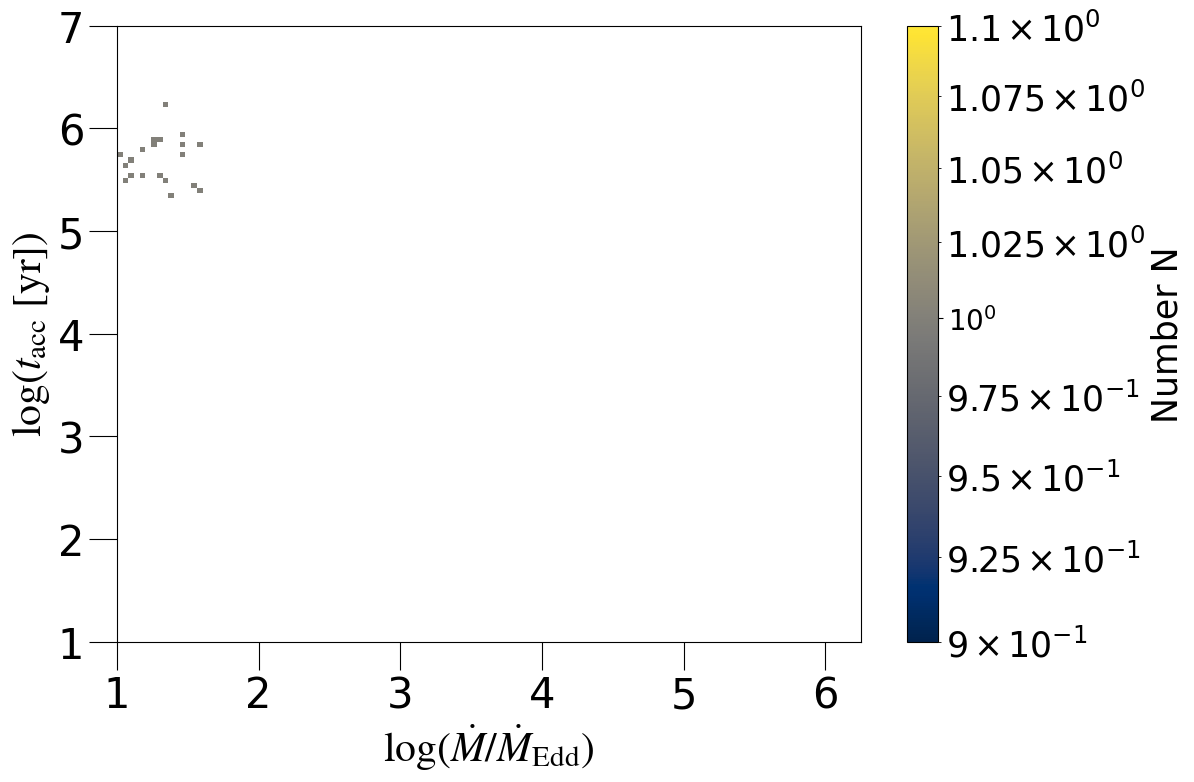

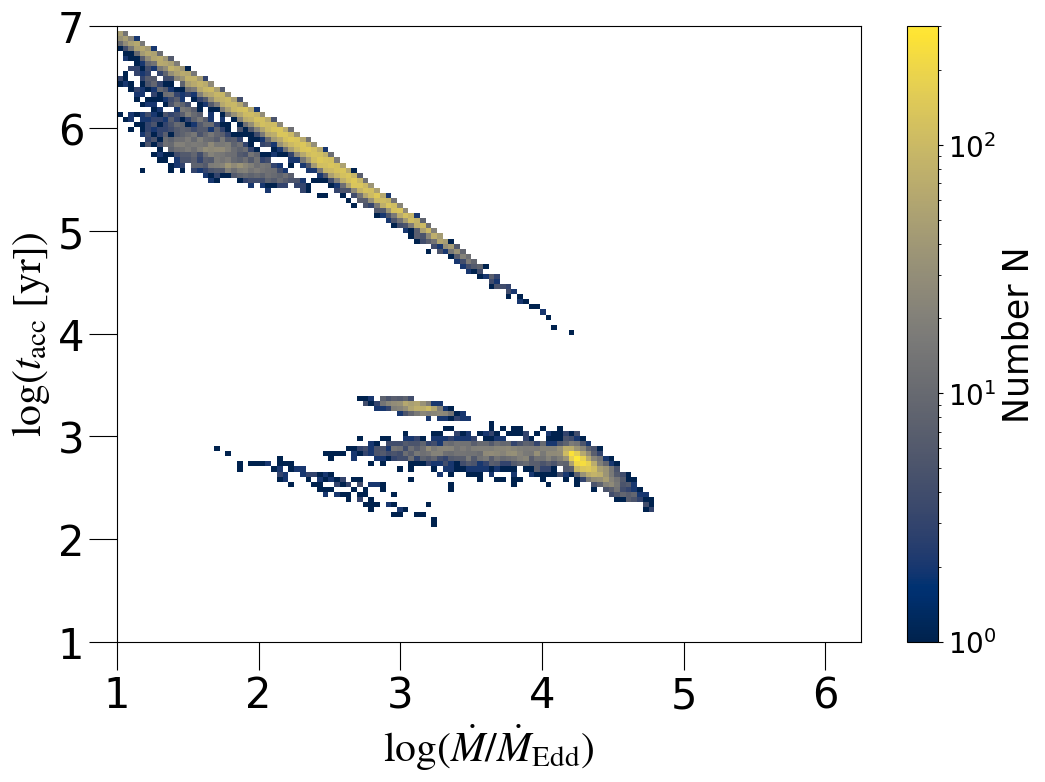

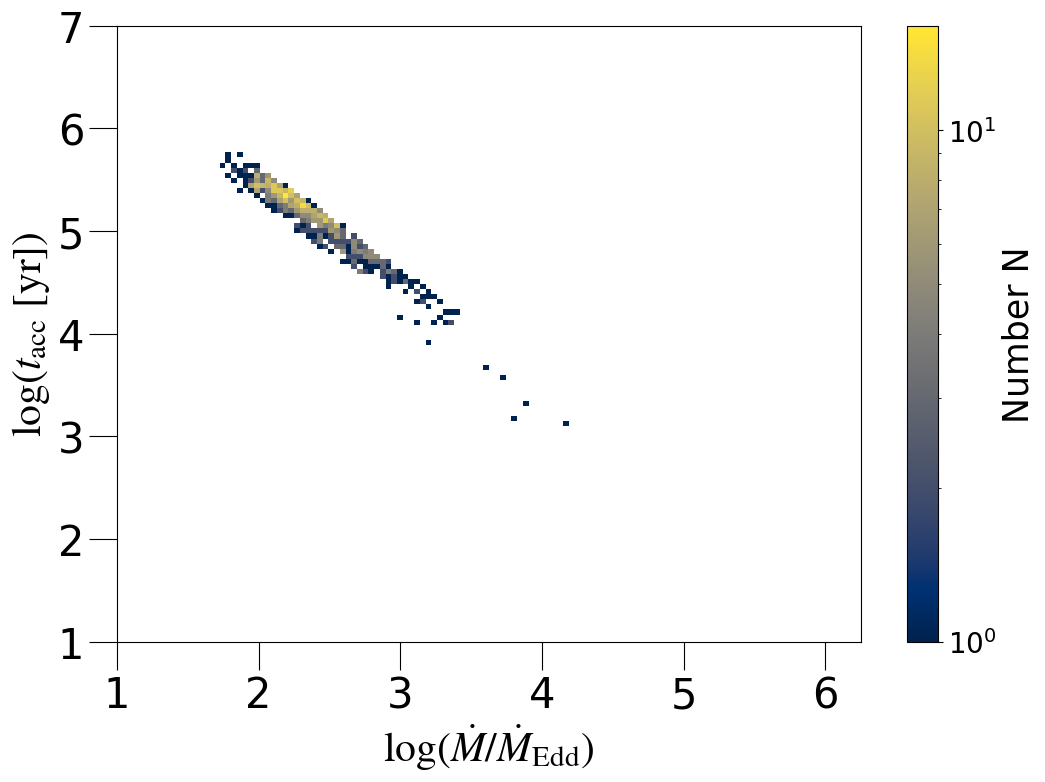

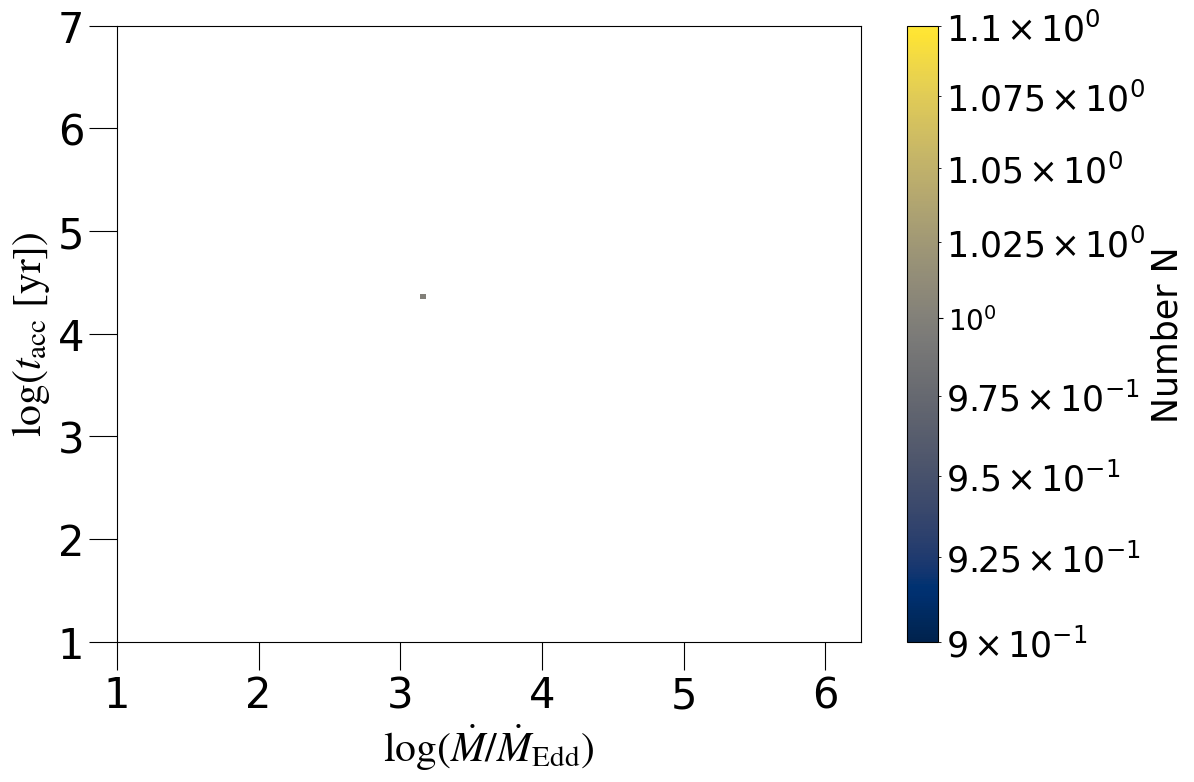

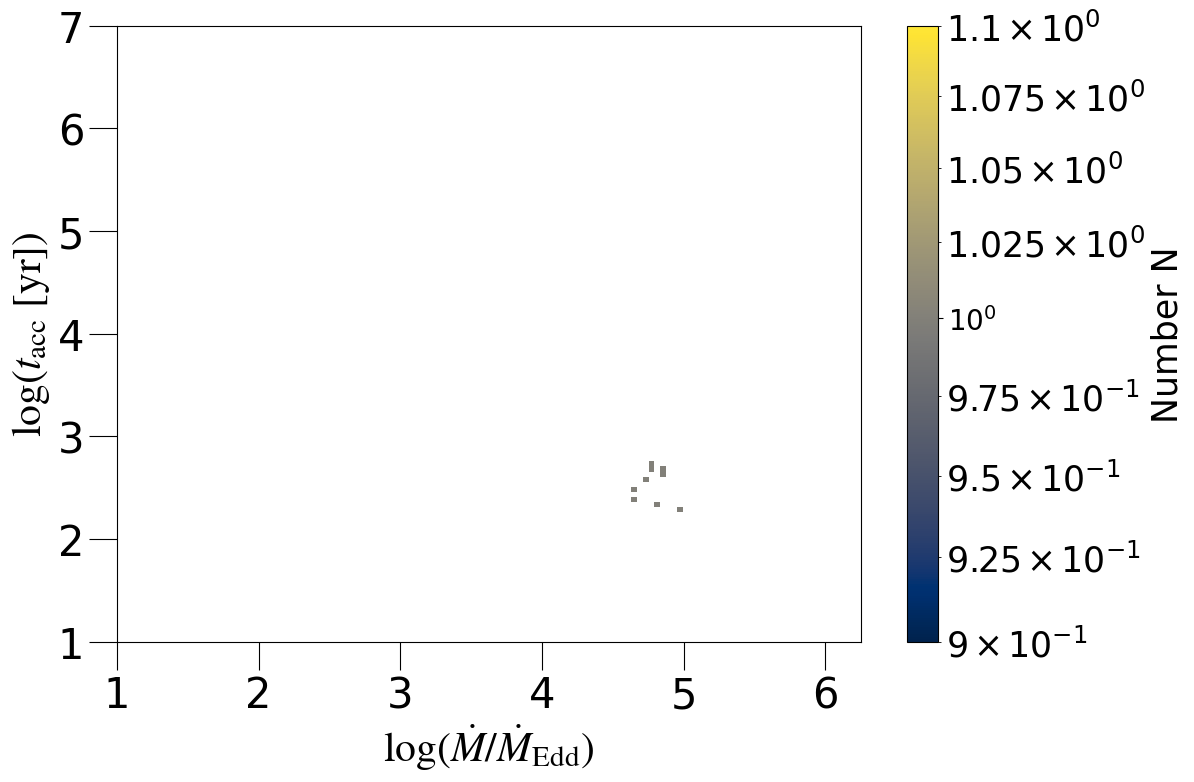

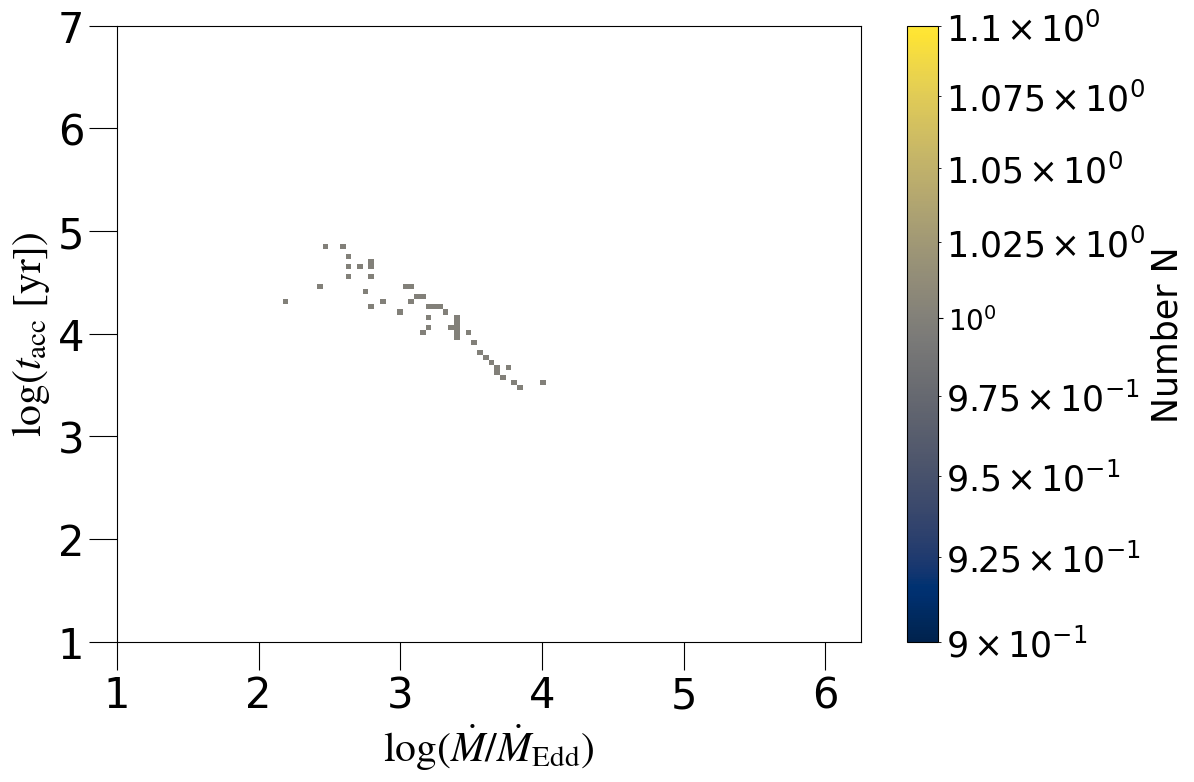

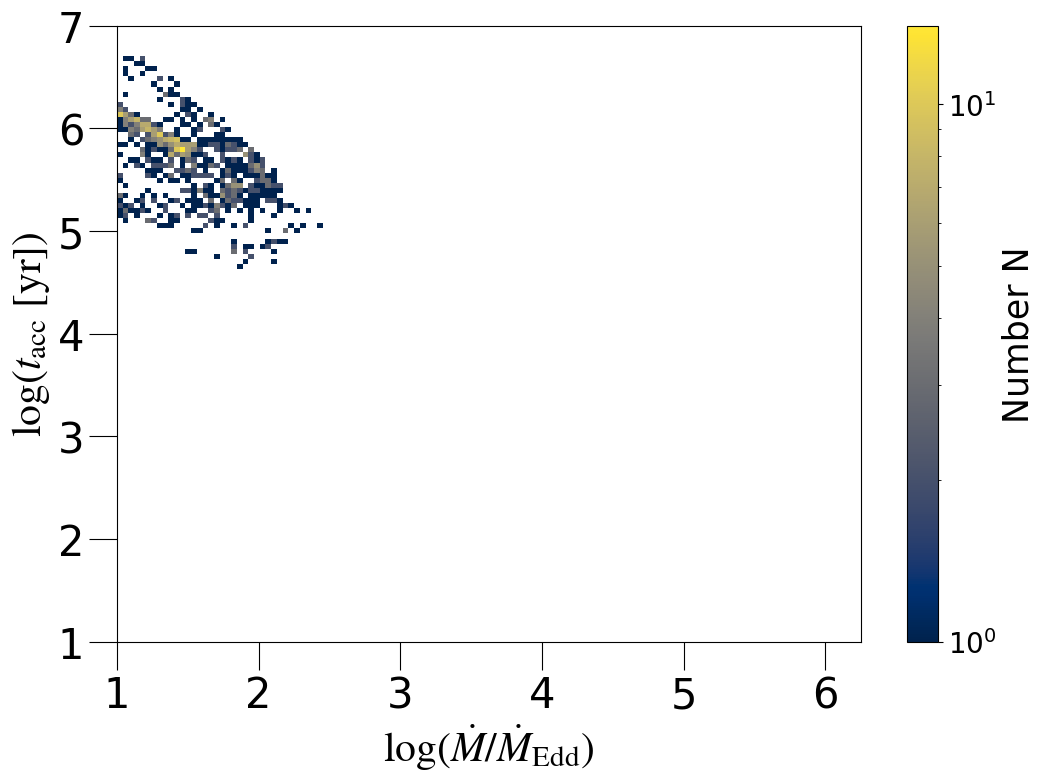

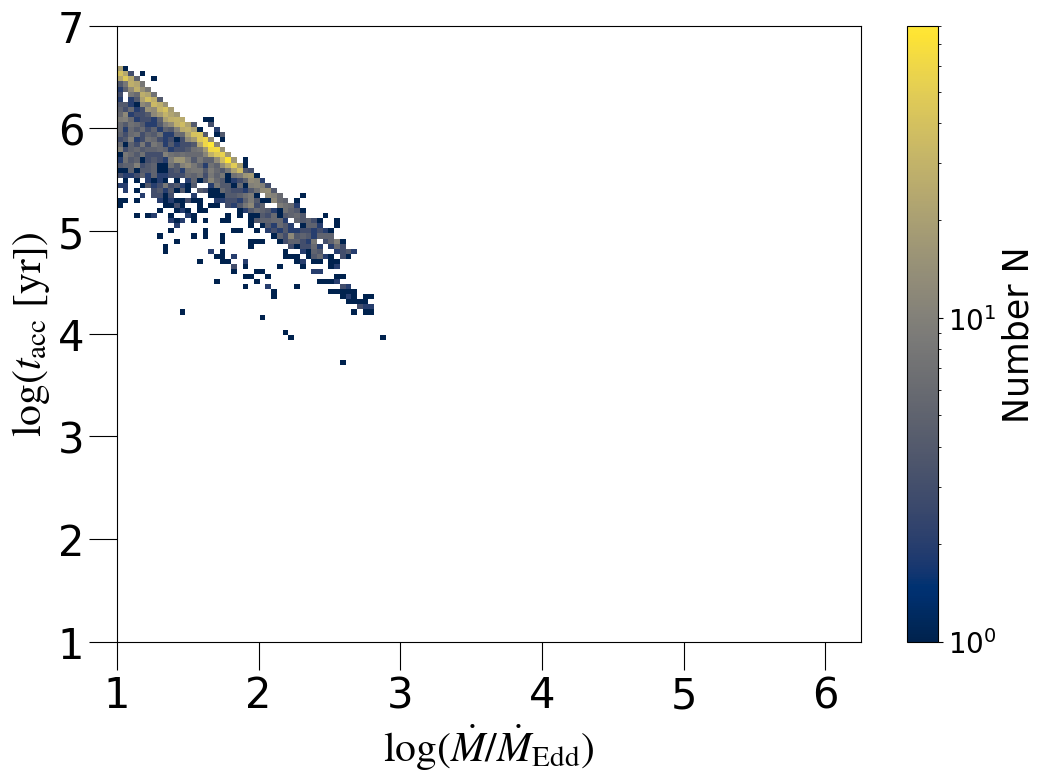

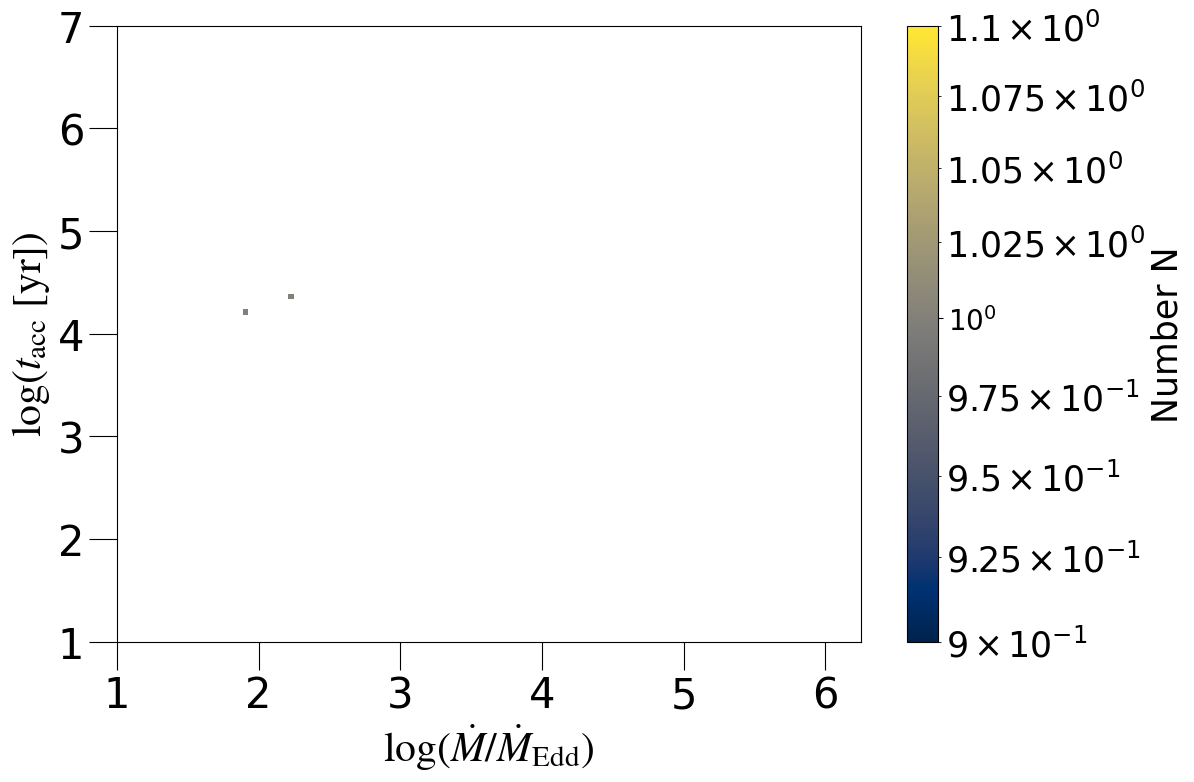

In [32]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST1, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST1_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST2, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST2_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST3, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST3_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST4, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST4_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST5, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST5_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST6, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST6_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST7, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST7_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST8, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST8_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST9, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_ST9_100.pdf', Colormap='cividis')

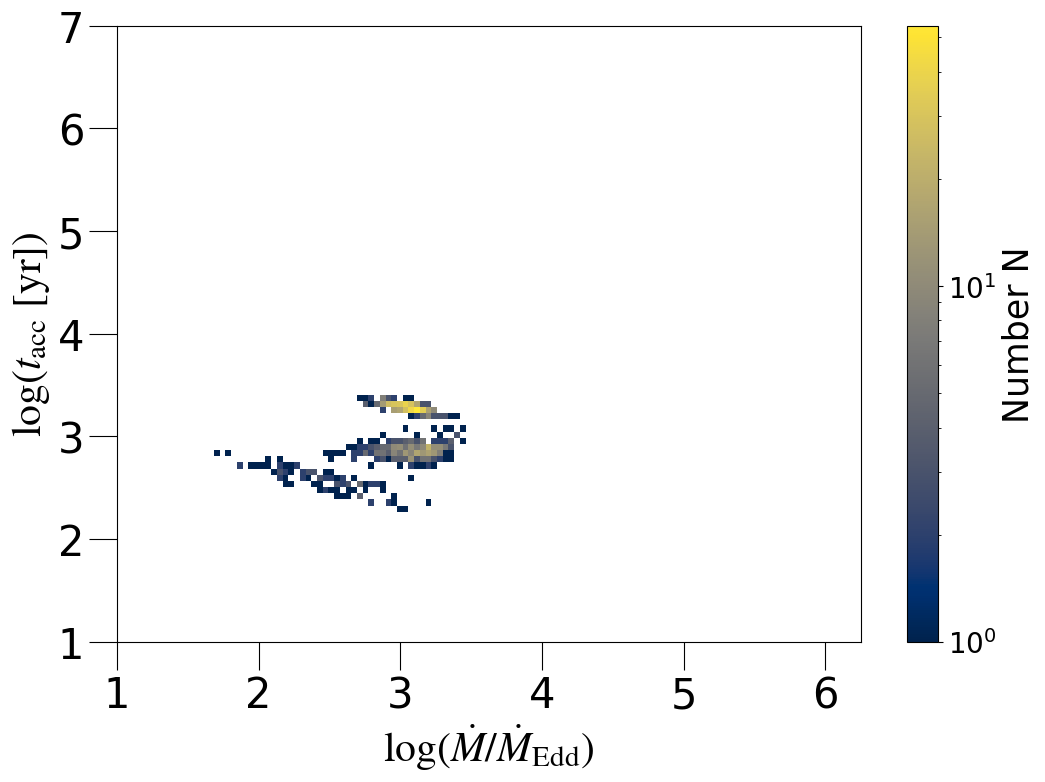

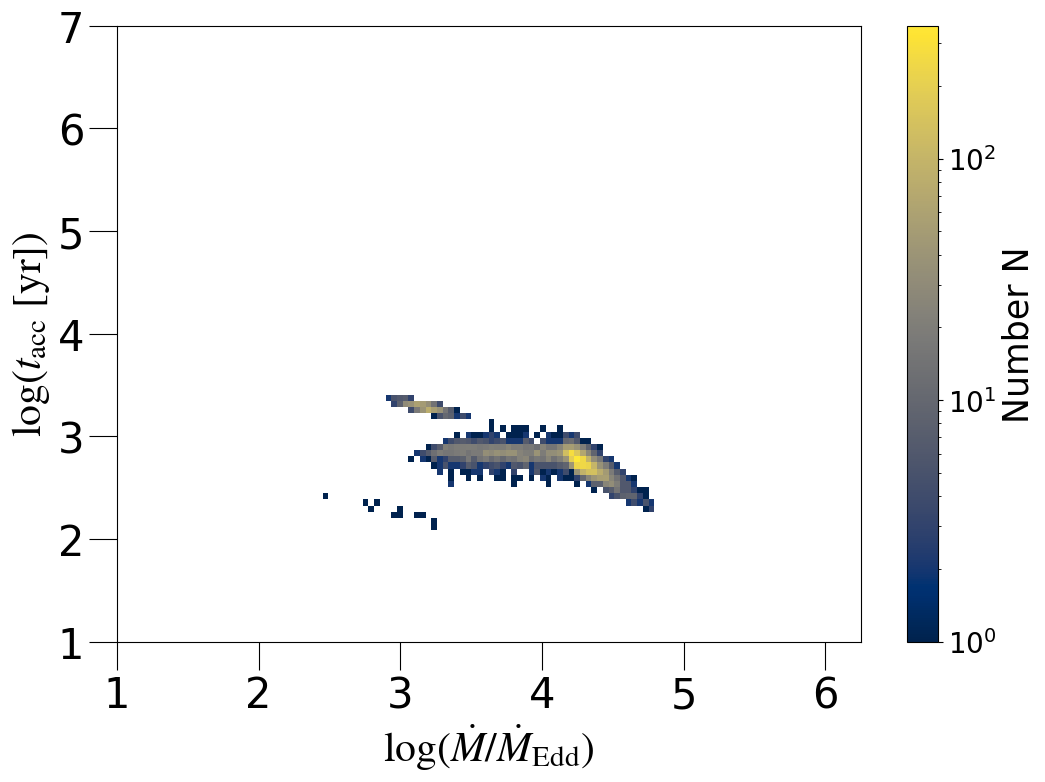

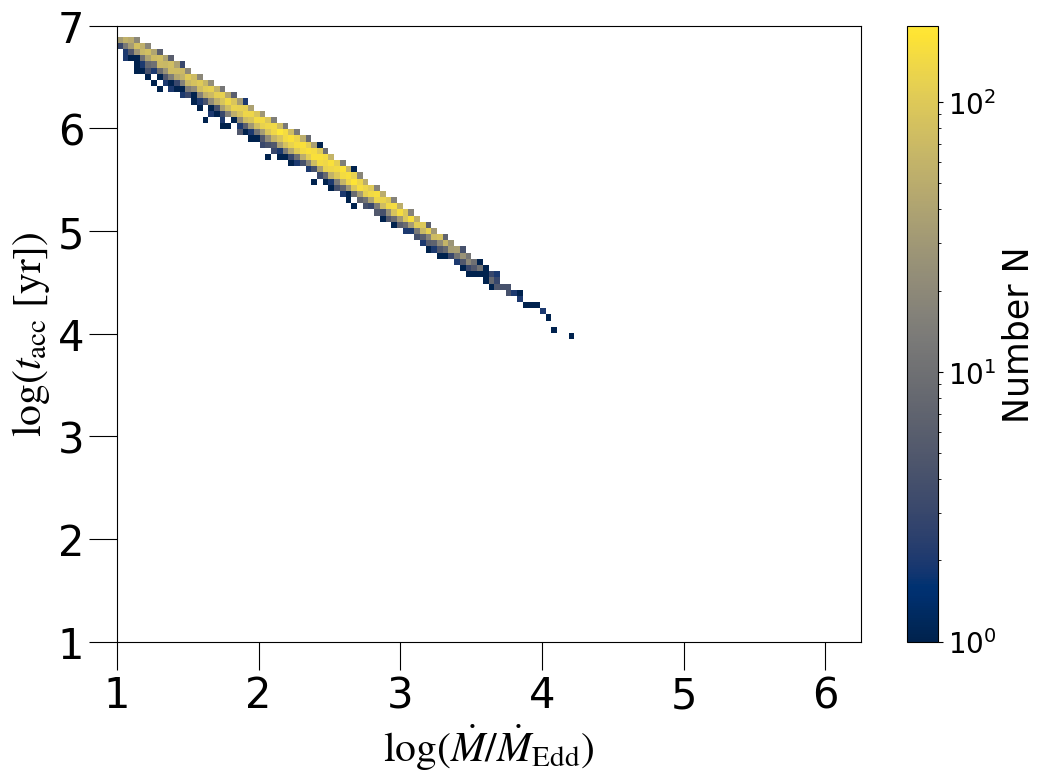

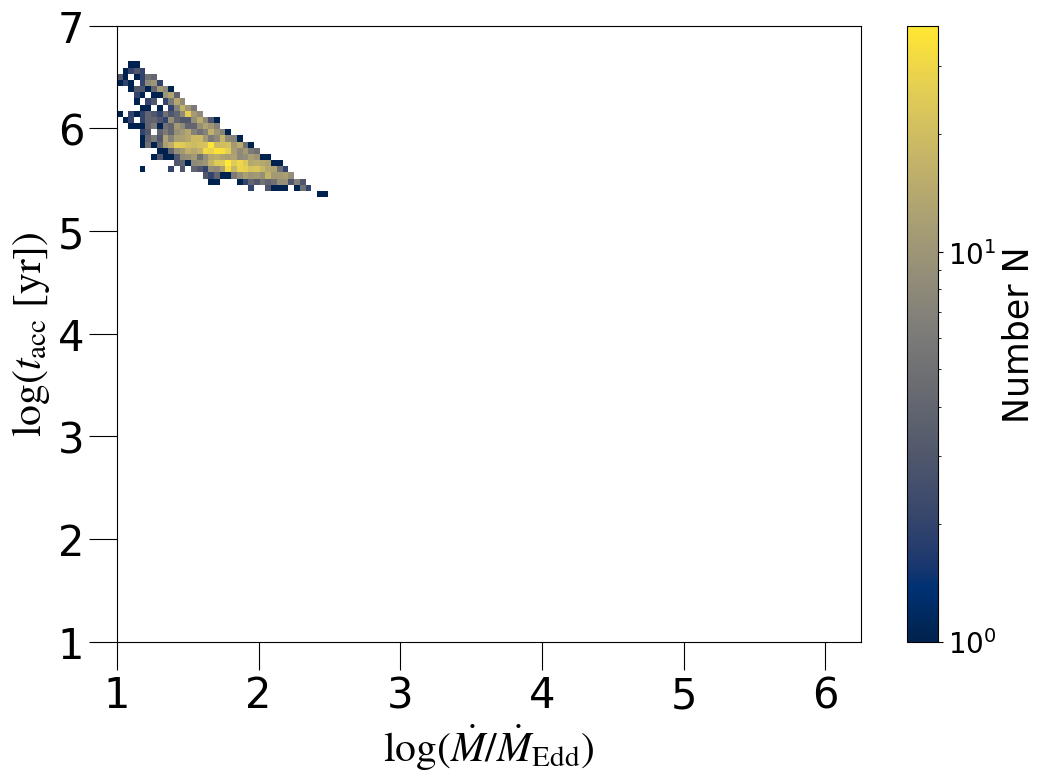

In [33]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST2to2, Mdot_NS_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_NS_N_ST2to2_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST2to4, Mdot_NS_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_NS_N_ST2to4_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST2to7, Mdot_NS_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_NS_N_ST2to7_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_ST2to10, Mdot_NS_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_NS_N_ST2to10_100.pdf', Colormap='cividis')

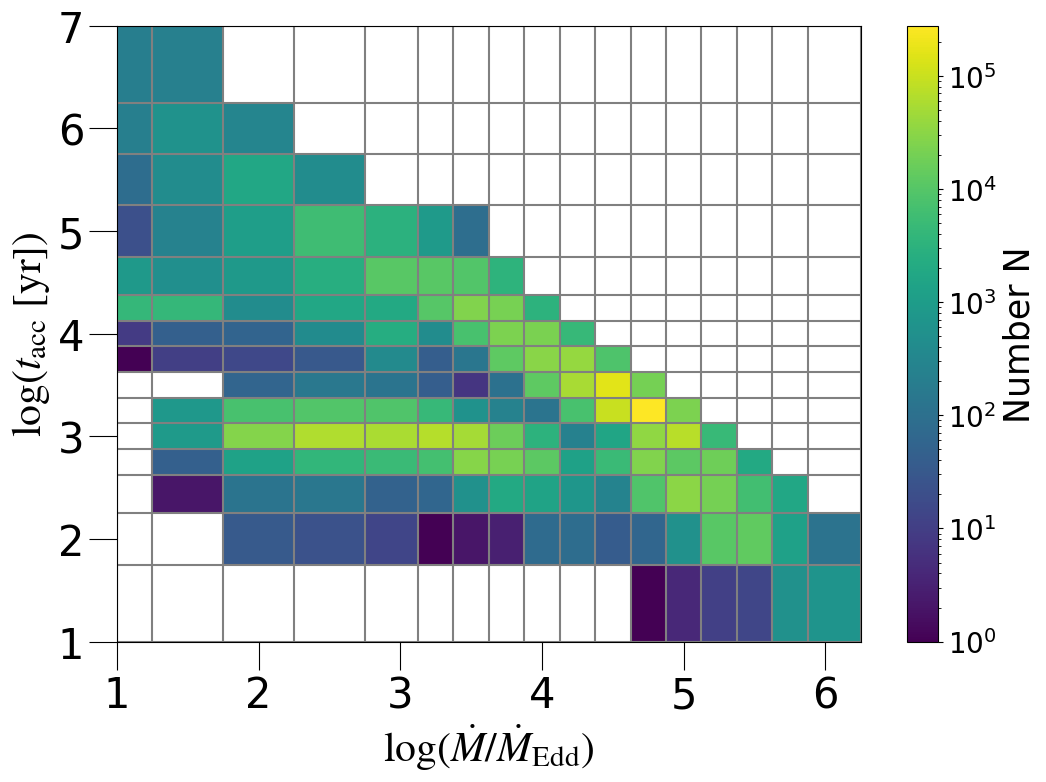

In [34]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid, 'MT_BH_N_grid.pdf', Colormap='viridis', Bin_Guide=True)

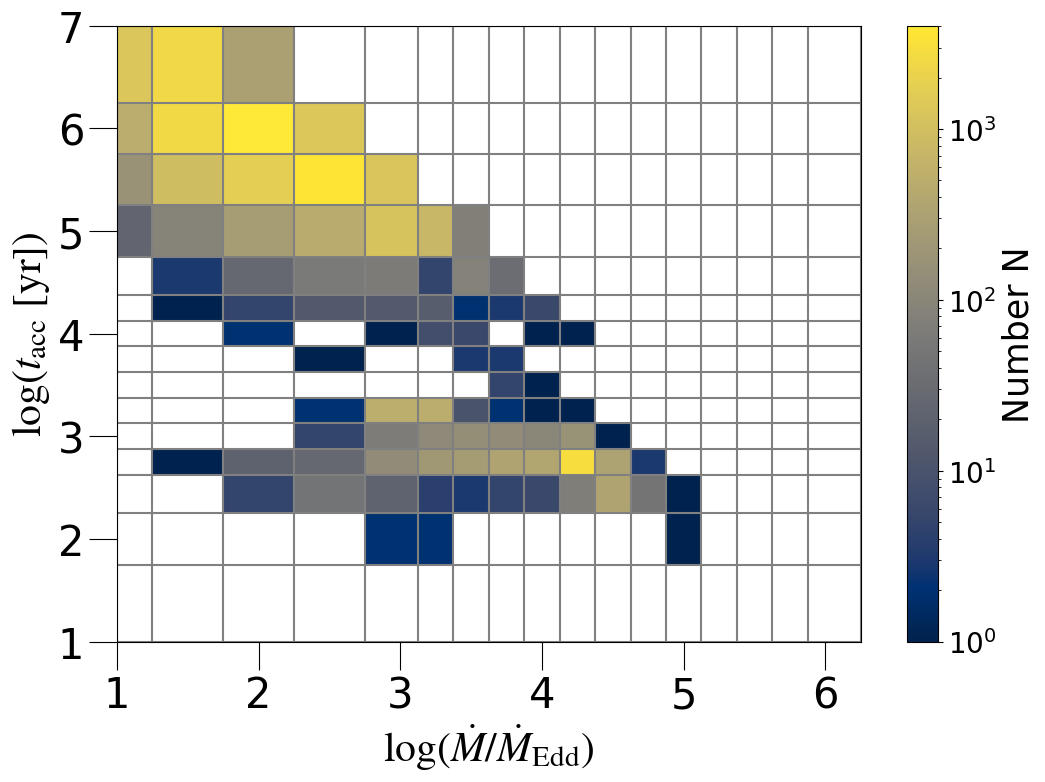

In [35]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid, 'MT_NS_N_grid.pdf', Colormap='cividis', Bin_Guide=True)

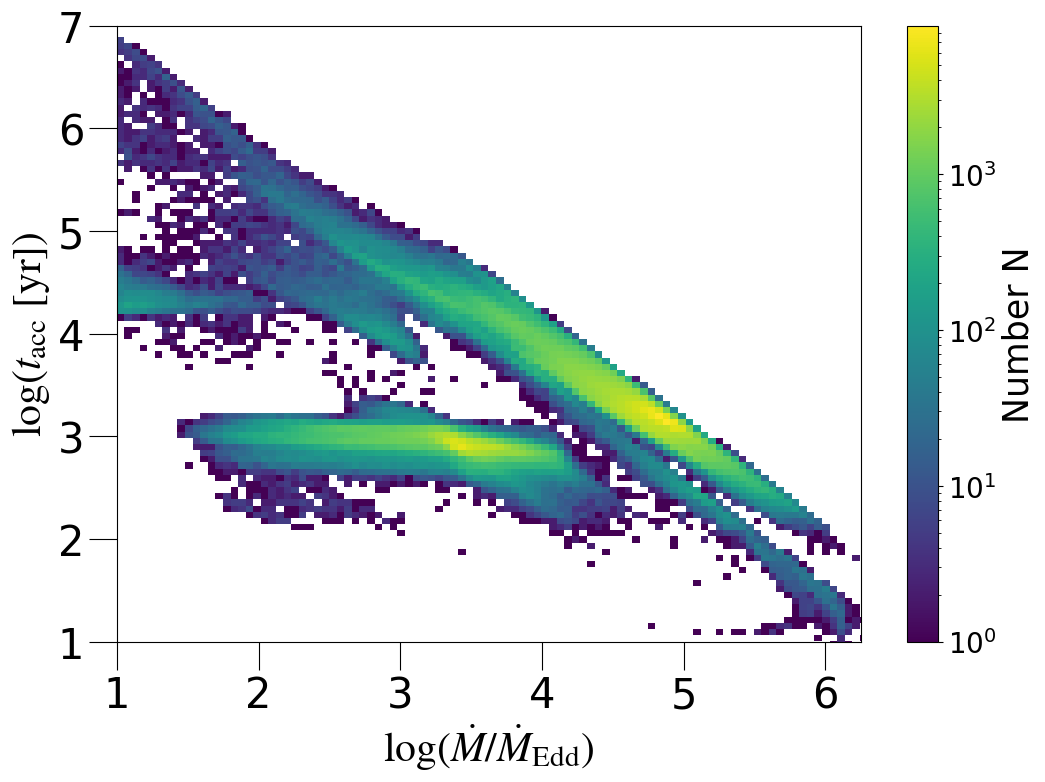

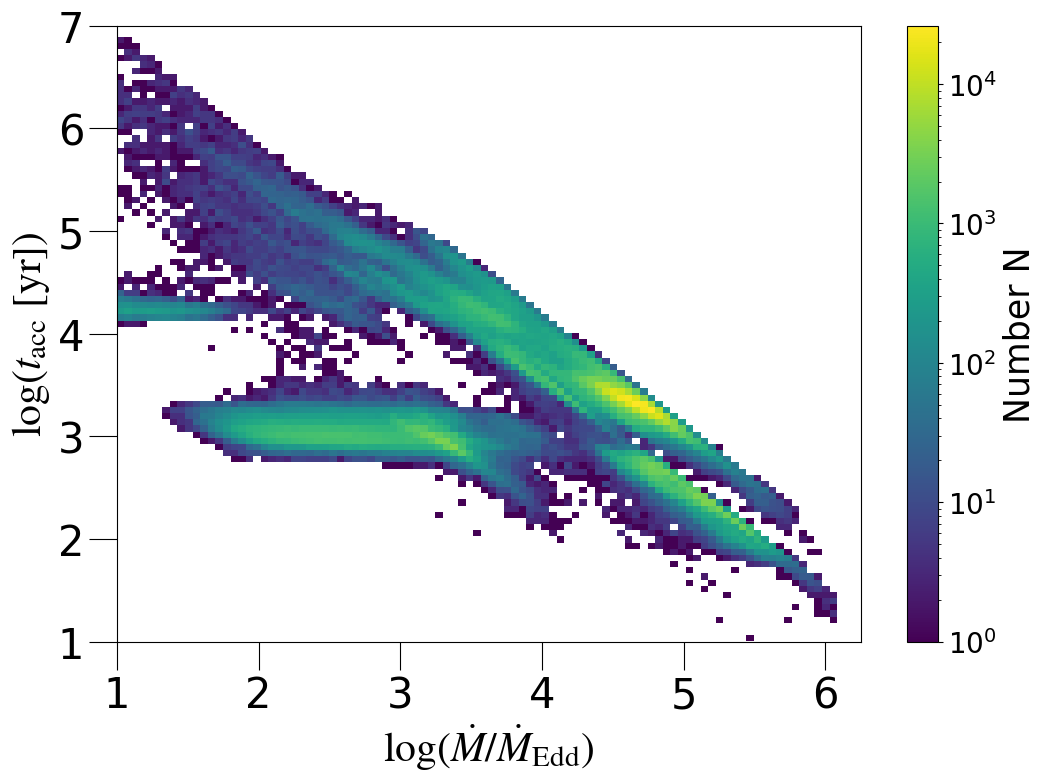

In [36]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_HighZ, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_HighZ_100.pdf')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_BH_MT_Edd_LowZ, Mdot_BH_bin_MT_Edd_100, Tacc_BH_bin_MT_Edd_100, 'MT_BH_N_LowZ_100.pdf')

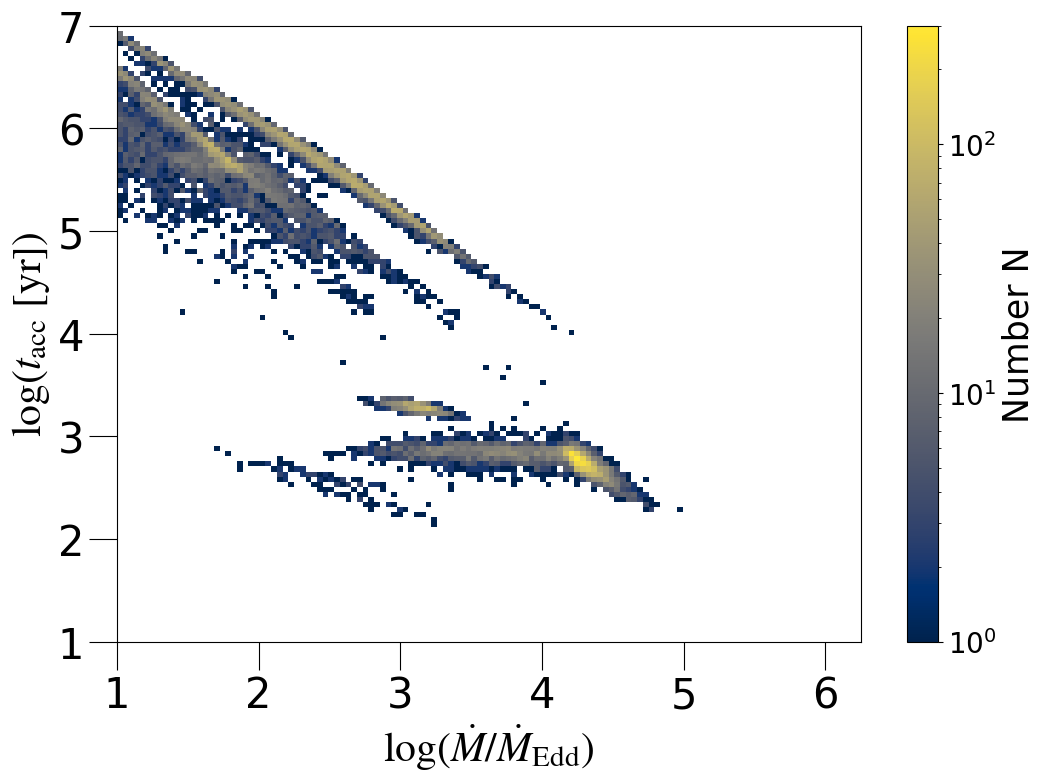

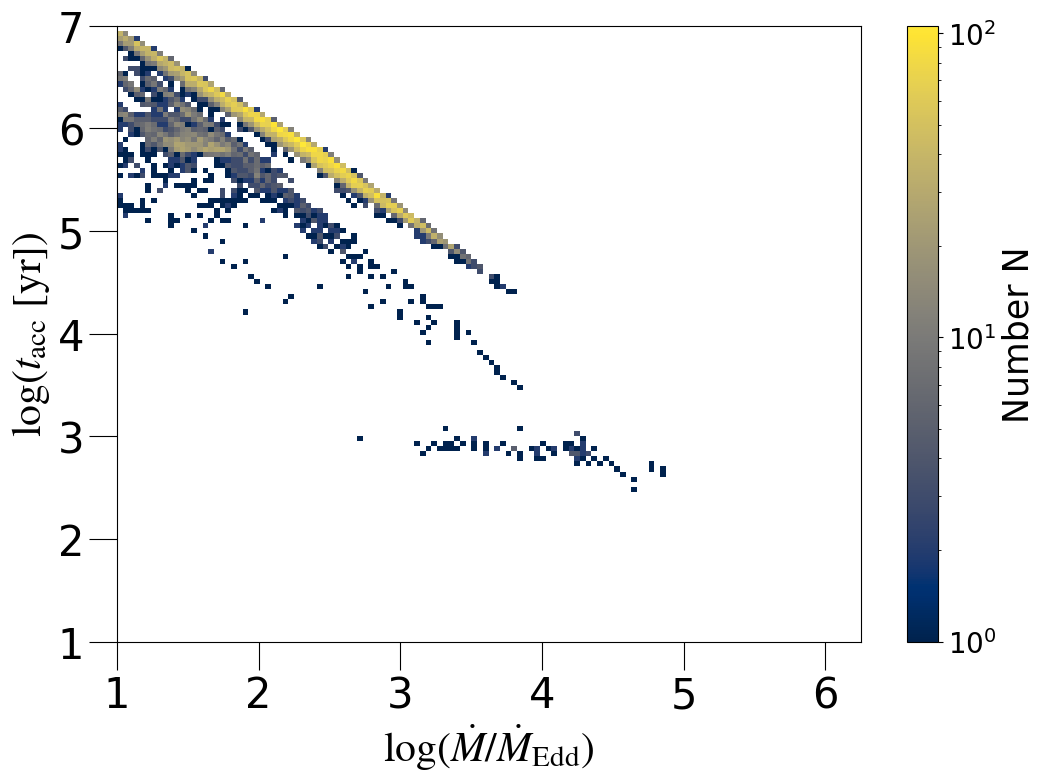

In [37]:
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_HighZ, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_HighZ_100.pdf', Colormap='cividis')
plot_2d_histgram_mt_mdot_vs_tacc(RLOF_NS_MT_Edd_LowZ, Mdot_NS_bin_MT_Edd_100, Tacc_NS_bin_MT_Edd_100, 'MT_NS_N_LowZ_100.pdf', Colormap='cividis')

In [38]:
def plot_2d_histgram_ce_mdot_vs_tacc (data, Mdot_bin, Tacc_bin, output, Colormap='viridis', Bin_Guide=False):
    
    x_value = data['Eddington'].value
    y_value = data['Timescale'].value
    
    N, x, y = np.histogram2d(x_value, y_value, bins=(Mdot_bin, Tacc_bin))

    fig, ax = plt.subplots(figsize = (12,8))
    
    pcm = ax.pcolormesh(np.log10(x), np.log10(y*Myr/yr), N.T, cmap=Colormap, norm=LogNorm())
    cbar = plt.colorbar(pcm, ax=ax, label='Number N')
    cbar.ax.tick_params(labelsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=20, size=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.locator_params(axis='y', nbins=6)

    # plt.xlim(1.0, 6.25)
    # plt.ylim(1.0, 7.0)
    
    if Bin_Guide == True:
        for i in range(len(Mdot_bin)):
            plt.axvline(np.log10(Mdot_bin[i]), color='gray')
    
        for i in range(len(Tacc_bin)):
            plt.axhline(np.log10(Tacc_bin[i]*Myr/yr), color='gray')

    
    plt.xlabel(r'$\log(\dot{M} / \dot{M}_{\rm Edd})$', fontsize = 30)
    plt.ylabel(r'$\log(t_{\rm acc} {\rm ~[yr]})$', fontsize = 30)
    plt.savefig('./Figures/N/{}'.format(output), bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [39]:
Mdot_BH_value_CE_Edd = RLOF_BH_CE_Edd_Dropinf['Eddington'].value
Tacc_BH_value_CE_Edd = RLOF_BH_CE_Edd_Dropinf['Timescale'].value

Mdot_BH_bin_CE_Edd_100 = np.logspace(np.log10(Mdot_BH_value_CE_Edd.min()), np.log10(Mdot_BH_value_CE_Edd.max()), 100)
Tacc_BH_bin_CE_Edd_100 = np.logspace(np.log10(Tacc_BH_value_CE_Edd.min()), np.log10(Tacc_BH_value_CE_Edd.max()), 100)

Mdot_NS_value_CE_Edd = RLOF_NS_CE_Edd_Dropinf['Eddington'].value
Tacc_NS_value_CE_Edd = RLOF_NS_CE_Edd_Dropinf['Timescale'].value

Mdot_NS_bin_CE_Edd_100 = np.logspace(np.log10(Mdot_NS_value_CE_Edd.min()), np.log10(Mdot_NS_value_CE_Edd.max()), 100)
Tacc_NS_bin_CE_Edd_100 = np.logspace(np.log10(Tacc_NS_value_CE_Edd.min()), np.log10(Tacc_NS_value_CE_Edd.max()), 100)


Mdot_bin_CE_Edd_grid = 10**np.array([1.0, 1.25, 1.75, 2.25, 2.75, 3.125, 3.375, 3.625, 3.875,
                                       4.125, 4.375, 4.625, 4.875, 5.125, 5.375, 5.625, 5.875, 
                                       6.125, 6.375, 6.625, 6.875, 7.125, 7.375, 7.625, 7.875,
                                       8.125, 8.375, 8.625, 8.875, 9.25])
Tacc_bin_CE_Edd_grid = 10**np.array([-1.75, -1.25, -0.875, -0.625, -0.375, -0.125, 
                                       0.125, 0.375, 0.625, 0.875, 1.25, 1.75, 
                                       2.25, 2.625, 2.875, 3.125, 3.375, 3.625, 3.875,
                                       4.125, 4.375, 4.75, 5.25, 5.75, 6.25])/1e6

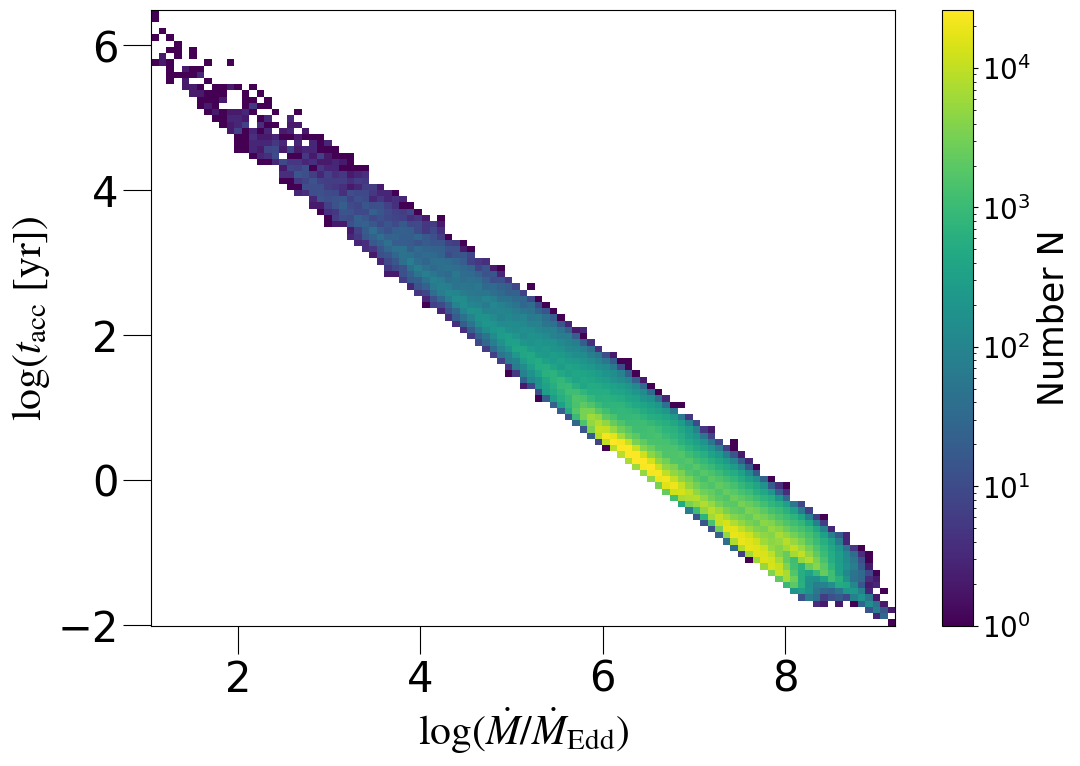

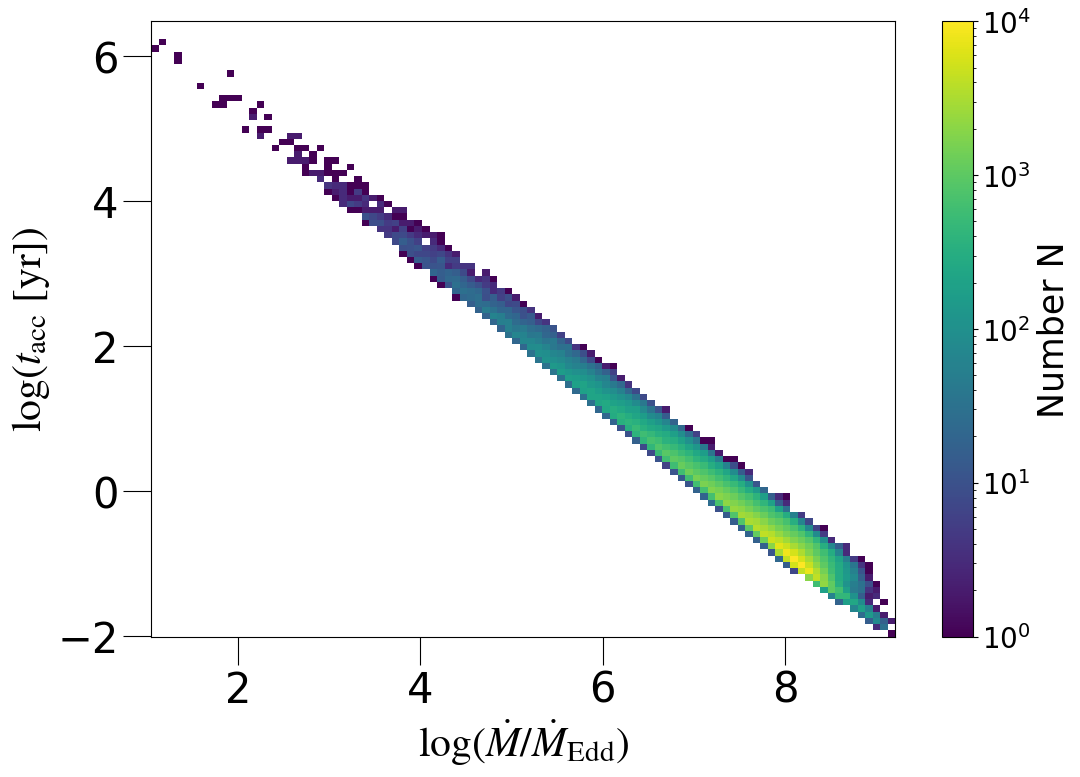

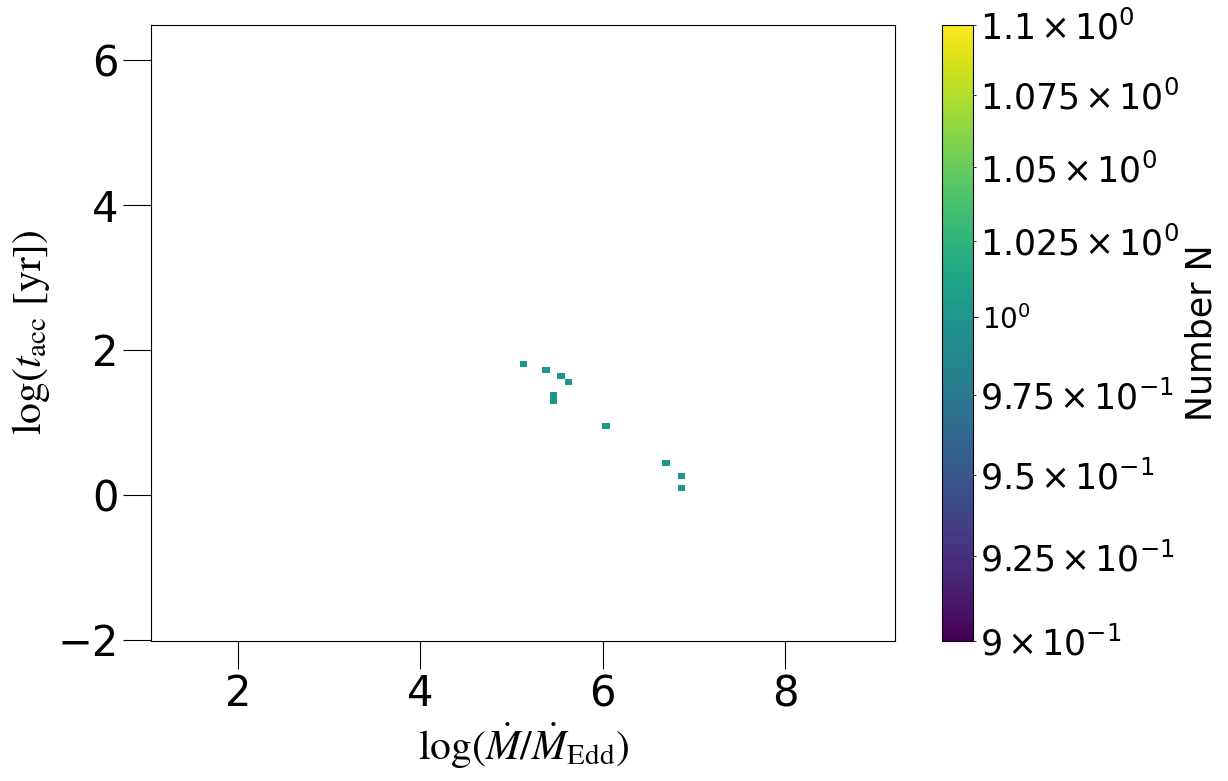

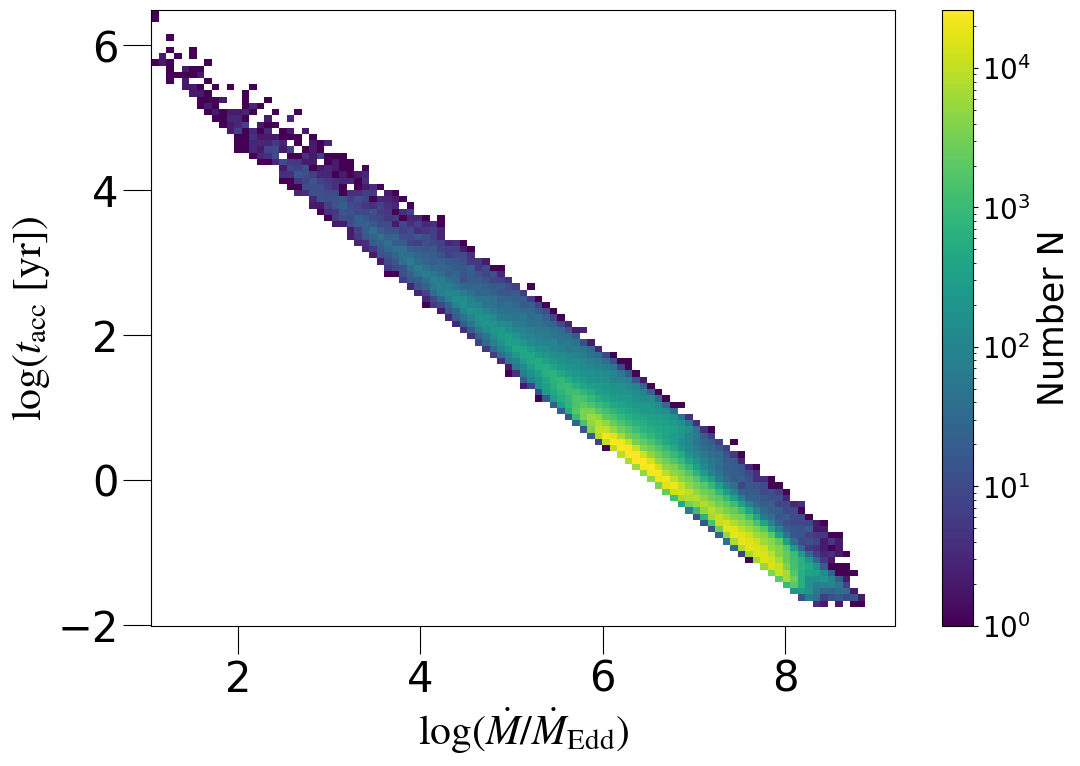

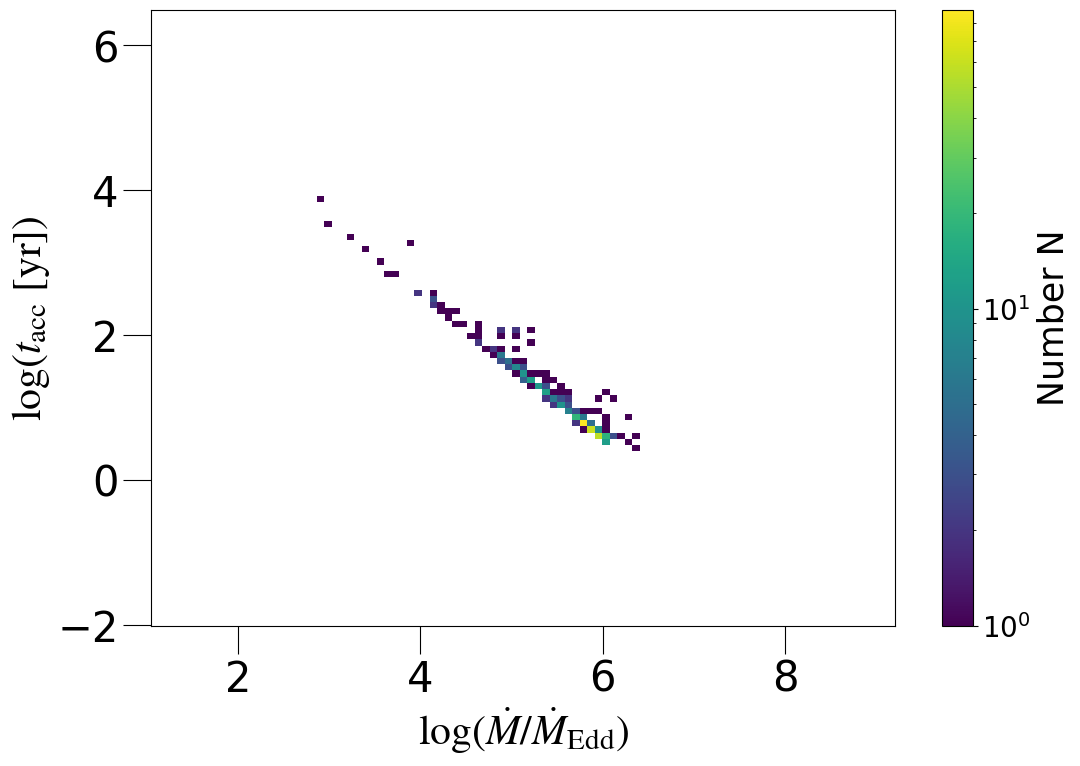

In [40]:
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_Dropinf, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_100.pdf')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST1, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST1_100.pdf')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST2, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST2_100.pdf')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST3, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST3_100.pdf')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST4, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST4_100.pdf')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST5, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST5_100.pdf')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST6, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST6_100.pdf')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST7, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST7_100.pdf')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST8, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST8_100.pdf')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd_ST9, Mdot_BH_bin_CE_Edd_100, Tacc_BH_bin_CE_Edd_100, 'CE_BH_N_ST9_100.pdf')

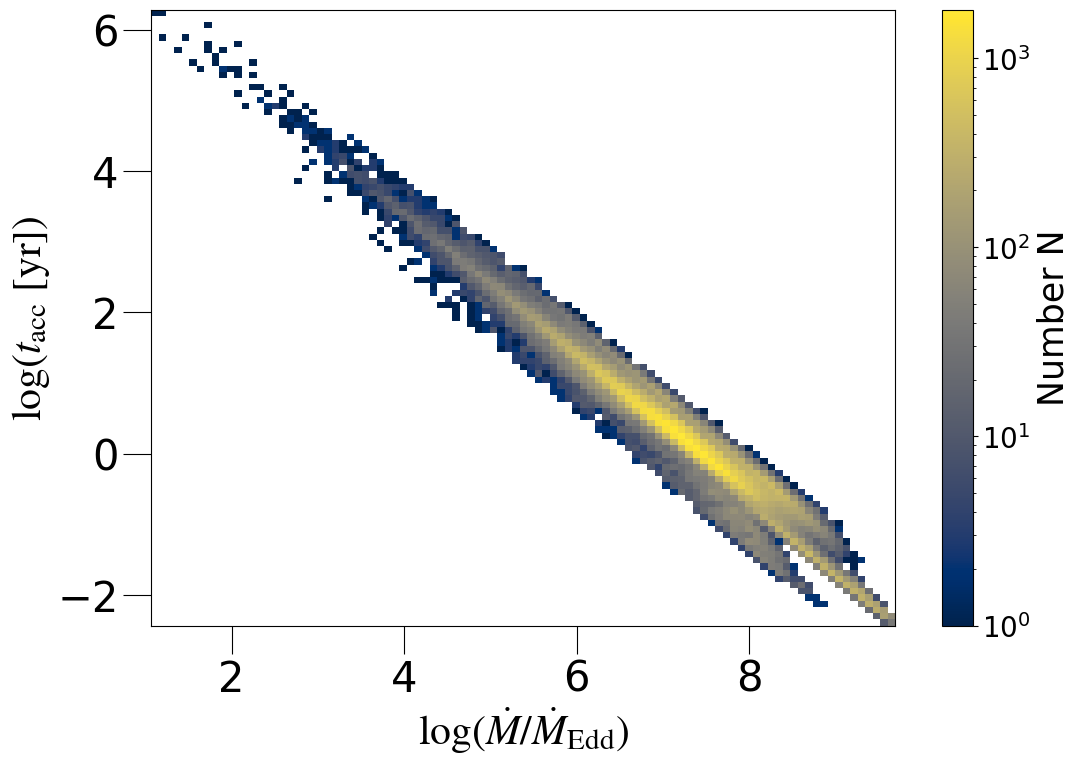

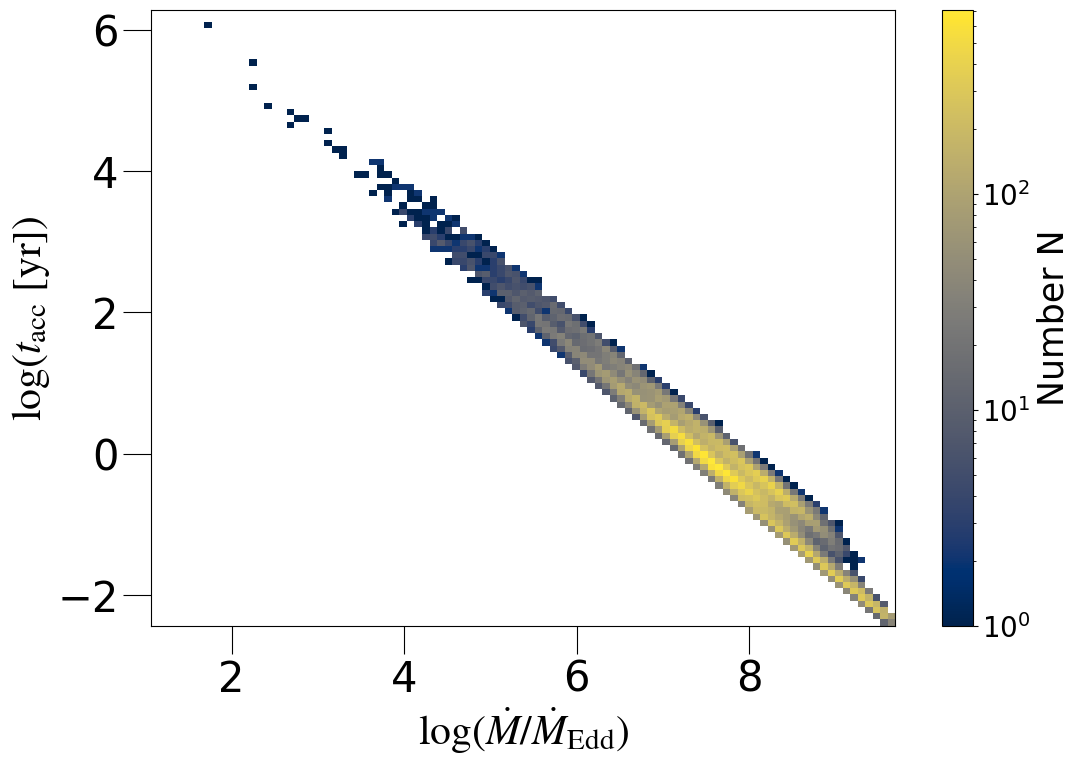

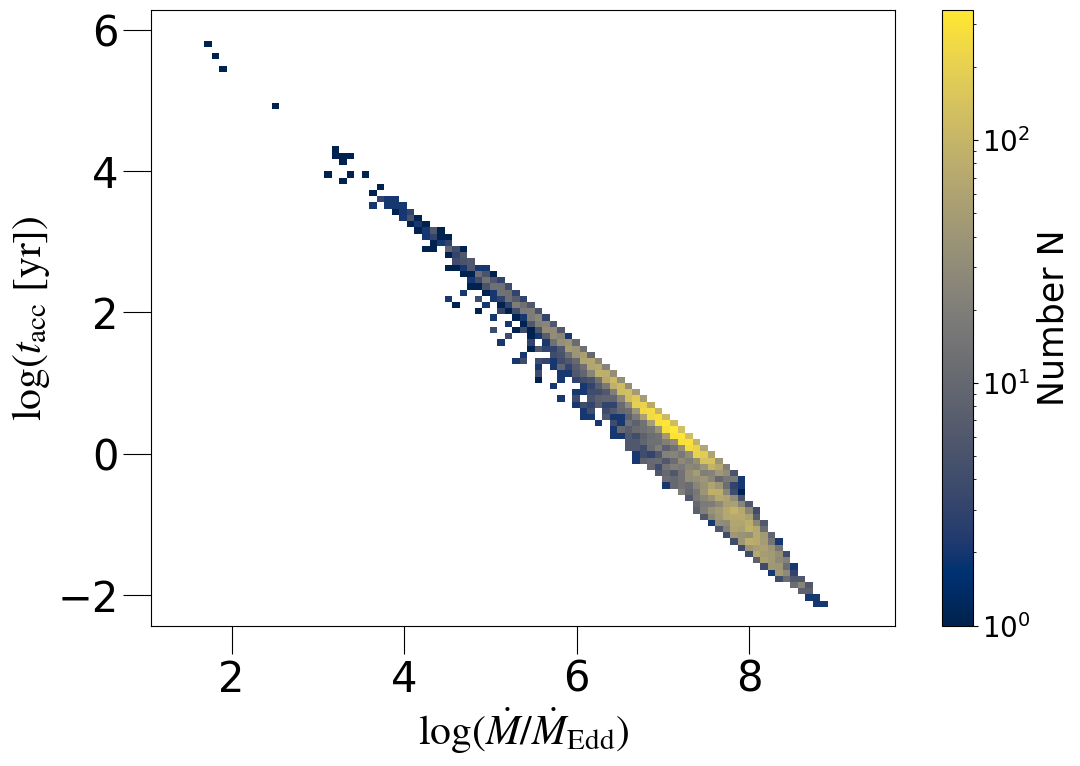

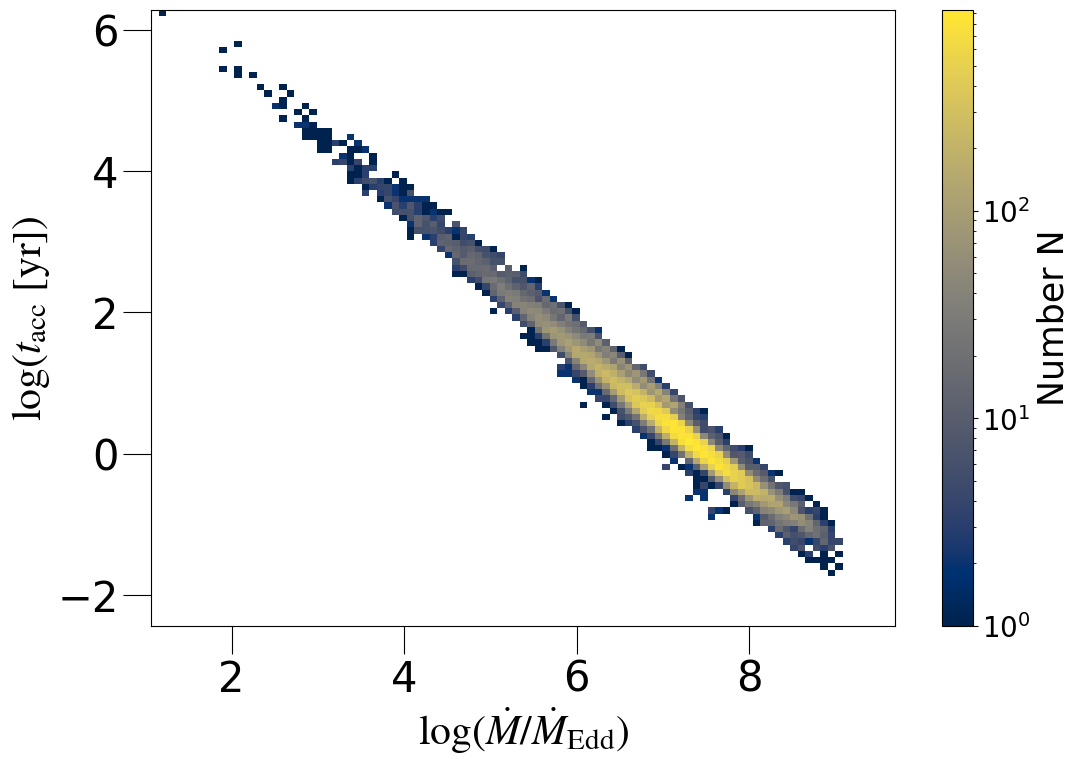

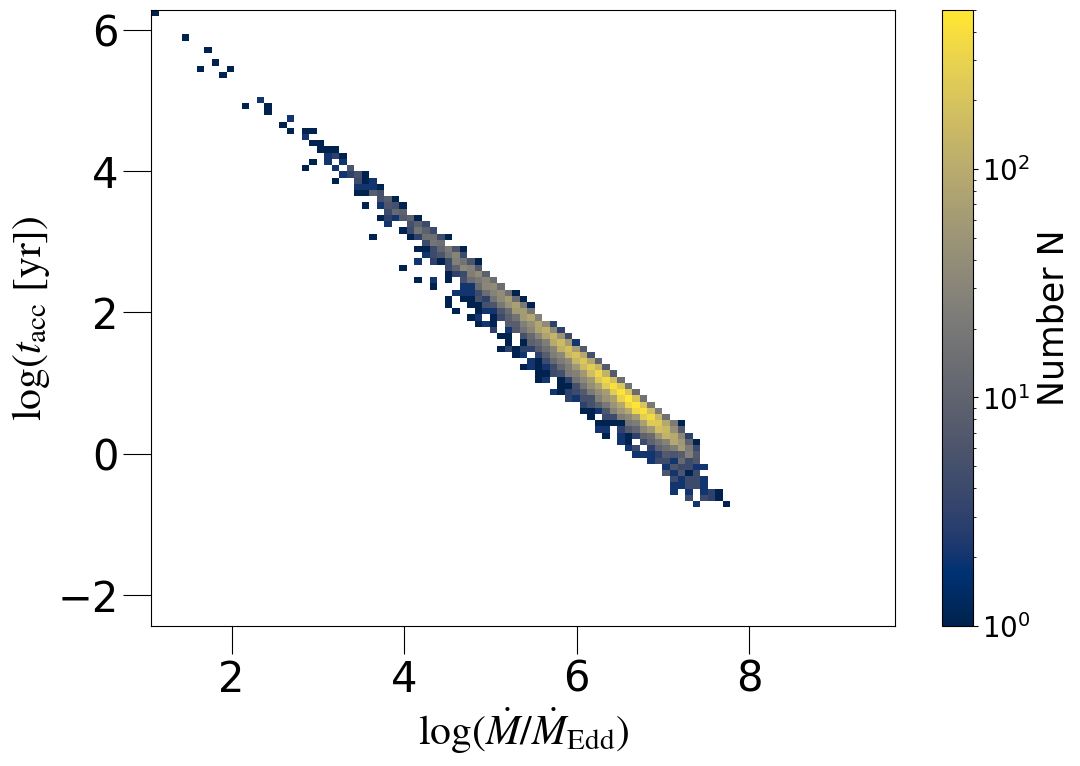

In [41]:
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_Dropinf, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_100.pdf', Colormap='cividis')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST1, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST1_100.pdf', Colormap='magma')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST2, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST2_100.pdf', Colormap='cividis')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST3, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST3_100.pdf', Colormap='cividis')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST4, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST4_100.pdf', Colormap='cividis')
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST5, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST5_100.pdf', Colormap='cividis')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST6, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST6_100.pdf', Colormap='magma')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST7, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST7_100.pdf', Colormap='magma')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST8, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST8_100.pdf', Colormap='magma')
# plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd_ST9, Mdot_NS_bin_CE_Edd_100, Tacc_NS_bin_CE_Edd_100, 'CE_NS_N_ST9_100.pdf', Colormap='magma')

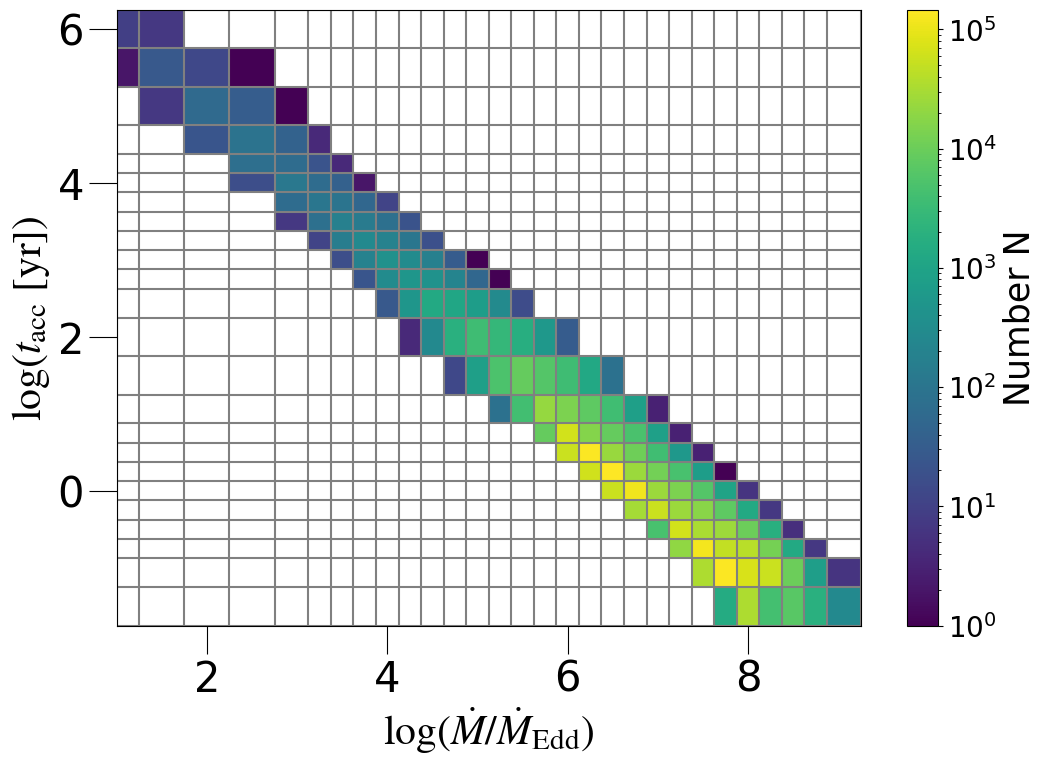

In [42]:
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_BH_CE_Edd, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid, 'CE_BH_N_grid.pdf', Colormap='viridis', Bin_Guide=True)

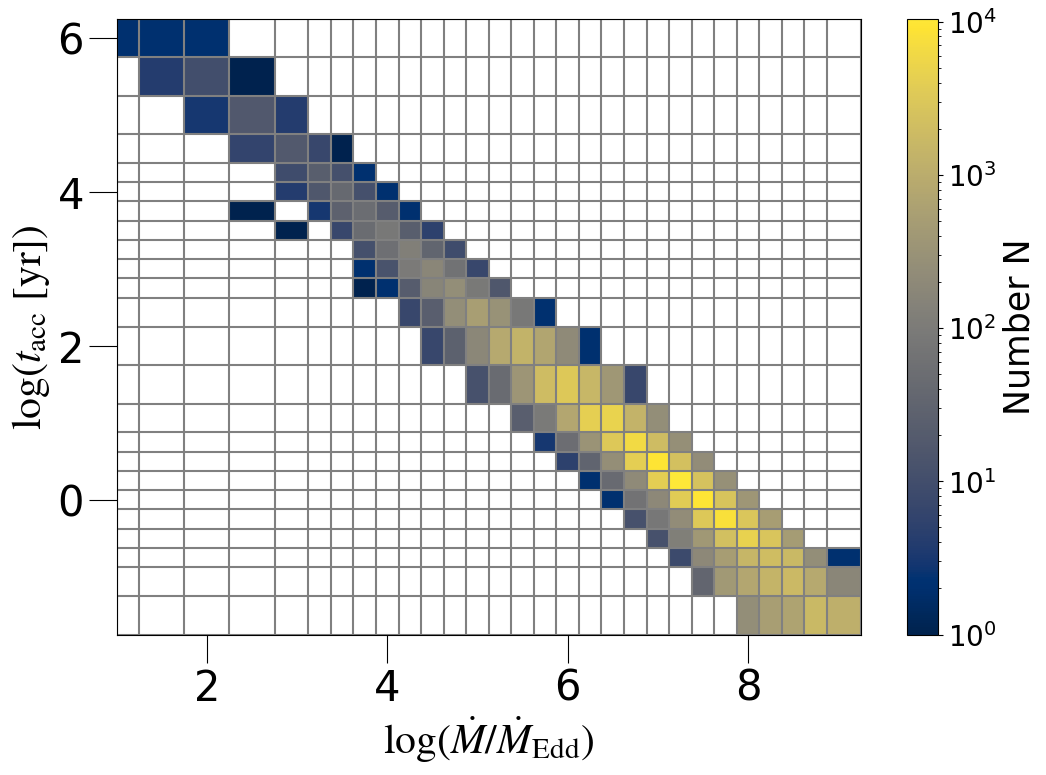

In [43]:
plot_2d_histgram_ce_mdot_vs_tacc(RLOF_NS_CE_Edd, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid, 'CE_NS_N_grid.pdf', Colormap='cividis', Bin_Guide=True)

## Plot 2D Histgram For All Data (CE+MT) ($\dot{M}/\dot{M}_{\rm Edd}$ vs. $t_{\rm acc}$)

In [76]:
Mdot_BH_value_MTCE_Edd = np.hstack((RLOF_BH_MT_Edd['Eddington'].value, RLOF_BH_CE_Edd['Eddington'].value))
Tacc_BH_value_MTCE_Edd = np.hstack((RLOF_BH_MT_Edd['Timescale'].value, RLOF_BH_CE_Edd['Timescale'].value))

Mdot_BH_bin_MTCE_Edd_100 = np.logspace(np.log10(Mdot_BH_value_MTCE_Edd.min()), np.log10(Mdot_BH_value_MTCE_Edd.max()), 100)
Tacc_BH_bin_MTCE_Edd_100 = np.logspace(np.log10(Tacc_BH_value_MTCE_Edd.min()), np.log10(Tacc_BH_value_MTCE_Edd.max()), 100)

Mdot_NS_value_MTCE_Edd = np.hstack((RLOF_NS_MT_Edd['Eddington'].value, RLOF_NS_CE_Edd['Eddington'].value))
Tacc_NS_value_MTCE_Edd = np.hstack((RLOF_NS_MT_Edd['Timescale'].value, RLOF_NS_CE_Edd['Timescale'].value))

Mdot_NS_bin_MTCE_Edd_100 = np.logspace(np.log10(Mdot_NS_value_MTCE_Edd.min()), np.log10(Mdot_NS_value_MTCE_Edd.max()), 100)
Tacc_NS_bin_MTCE_Edd_100 = np.logspace(np.log10(Tacc_NS_value_MTCE_Edd.min()), np.log10(Tacc_NS_value_MTCE_Edd.max()), 100)

Mdot_BHNS_value_MTCE_Edd = np.hstack((Mdot_BH_value_MTCE_Edd, Mdot_NS_value_MTCE_Edd))
Tacc_BHNS_value_MTCE_Edd = np.hstack((Tacc_BH_value_MTCE_Edd, Tacc_NS_value_MTCE_Edd))

Mdot_BHNS_bin_MTCE_Edd_100 = np.logspace(np.log10(Mdot_BHNS_value_MTCE_Edd.min()), np.log10(Mdot_BHNS_value_MTCE_Edd.max()), 100)
Tacc_BHNS_bin_MTCE_Edd_100 = np.logspace(np.log10(Tacc_BHNS_value_MTCE_Edd.min()), np.log10(Tacc_BHNS_value_MTCE_Edd.max()), 100)

Mdot_bin_MTCE_Edd_grid = 10**np.array([1.0, 1.25, 1.75, 2.25, 2.75, 3.125, 3.375, 3.625, 3.875,
                                       4.125, 4.375, 4.625, 4.875, 5.125, 5.375, 5.625, 5.875, 
                                       6.125, 6.375, 6.625, 6.875, 7.125, 7.375, 7.625, 7.875,
                                       8.125, 8.375, 8.625, 8.875, 9.25])
Tacc_bin_MTCE_Edd_grid = 10**np.array([-1.75, -1.25, -0.875, -0.625, -0.375, -0.125, 
                                       0.125, 0.375, 0.625, 0.875, 1.25, 1.75, 
                                       2.25, 2.625, 2.875, 3.125, 3.375, 3.625, 3.875,
                                       4.125, 4.375, 4.75, 5.25, 5.75, 6.25, 7.0])/1e6

In [45]:
def plot_2d_histgram_mtce_mdot_vs_tacc (data_x, data_y, Mdot_bin, Tacc_bin, output, Colormap='viridis', Bin_Guide=False):
    
    N, x, y = np.histogram2d(data_x, data_y, bins=(Mdot_bin, Tacc_bin))

    fig, ax = plt.subplots(figsize = (12,8))
    
    pcm = ax.pcolormesh(np.log10(x), np.log10(y*Myr/yr), N.T, cmap=Colormap, norm=LogNorm())
    cbar = plt.colorbar(pcm, ax=ax, label='Number N')
    cbar.ax.tick_params(labelsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=20, size=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.locator_params(axis='y', nbins=6)
    
    if Bin_Guide == True:
        for i in range(len(Mdot_bin)):
            plt.axvline(np.log10(Mdot_bin[i]), color='gray')
    
        for i in range(len(Tacc_bin)):
            plt.axhline(np.log10(Tacc_bin[i]*Myr/yr), color='gray')
    
    plt.xlabel(r'$\log(\dot{M} / \dot{M}_{\rm Edd})$', fontsize = 30)
    plt.ylabel(r'$\log(t_{\rm acc} {\rm ~[yr]})$', fontsize = 30)
    plt.savefig('./Figures/N/{}'.format(output), bbox_inches='tight', pad_inches=0.1)
    plt.show()
    

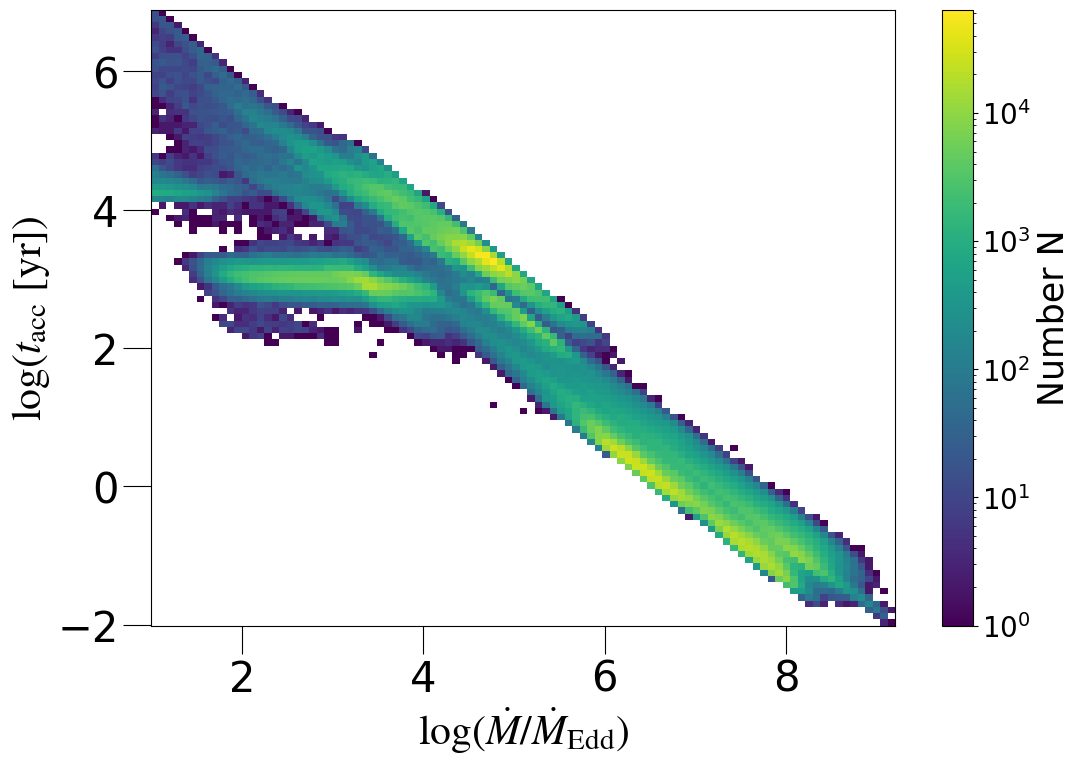

In [46]:
plot_2d_histgram_mtce_mdot_vs_tacc(Mdot_BH_value_MTCE_Edd, Tacc_BH_value_MTCE_Edd, Mdot_BH_bin_MTCE_Edd_100, Tacc_BH_bin_MTCE_Edd_100, 
                                   'MTCE_BH_N_100.pdf')

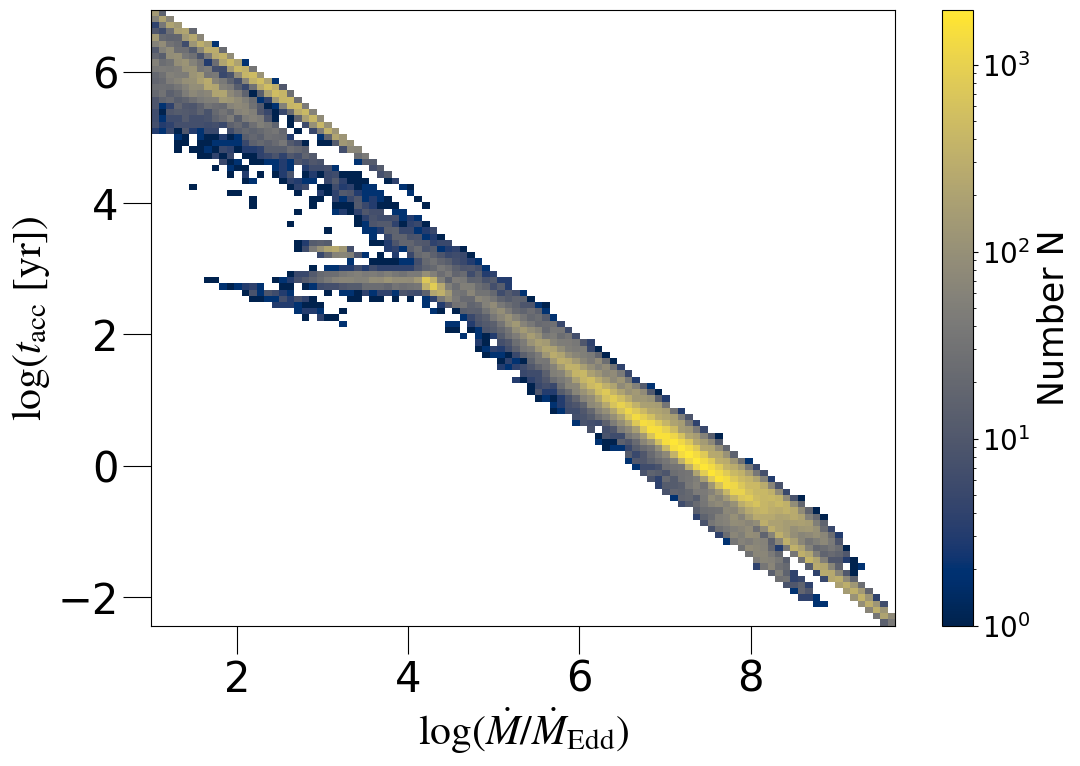

In [47]:
plot_2d_histgram_mtce_mdot_vs_tacc(Mdot_NS_value_MTCE_Edd, Tacc_NS_value_MTCE_Edd, Mdot_NS_bin_MTCE_Edd_100, Tacc_NS_bin_MTCE_Edd_100, 
                                   'MTCE_NS_N_100.pdf', Colormap='cividis')

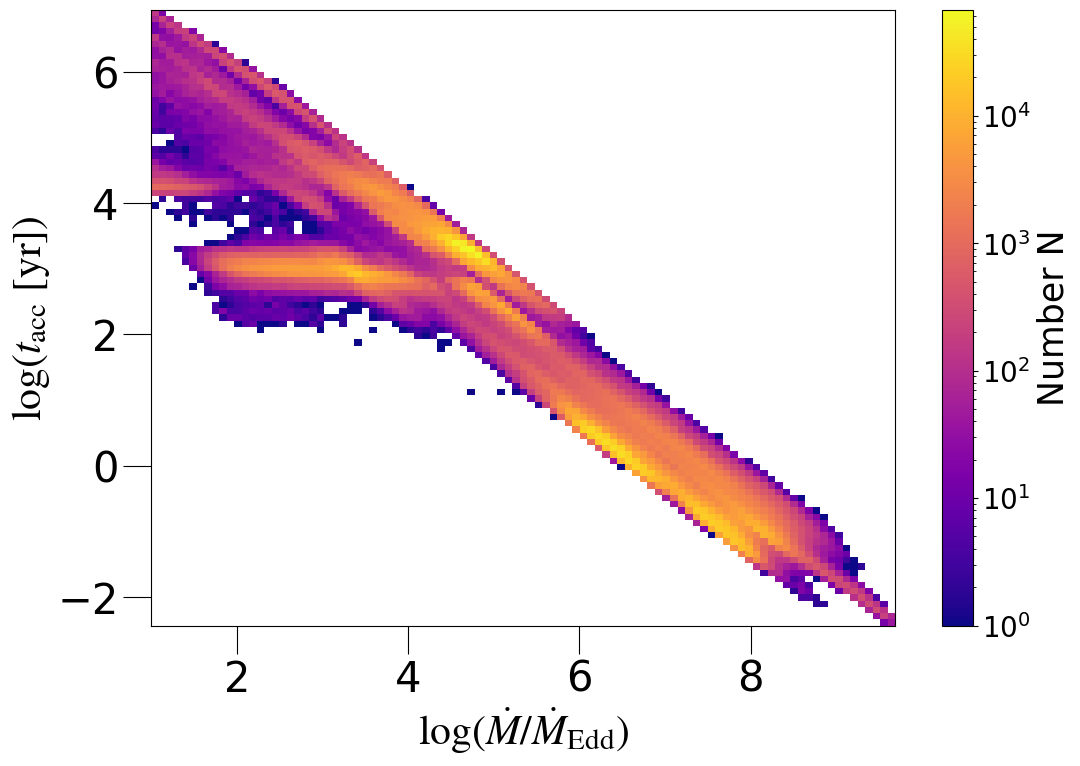

In [78]:
plot_2d_histgram_mtce_mdot_vs_tacc(Mdot_BHNS_value_MTCE_Edd, Tacc_BHNS_value_MTCE_Edd, Mdot_BHNS_bin_MTCE_Edd_100, Tacc_BHNS_bin_MTCE_Edd_100, 
                                   'MTCE_BHNS_N_100.pdf', Colormap='plasma')

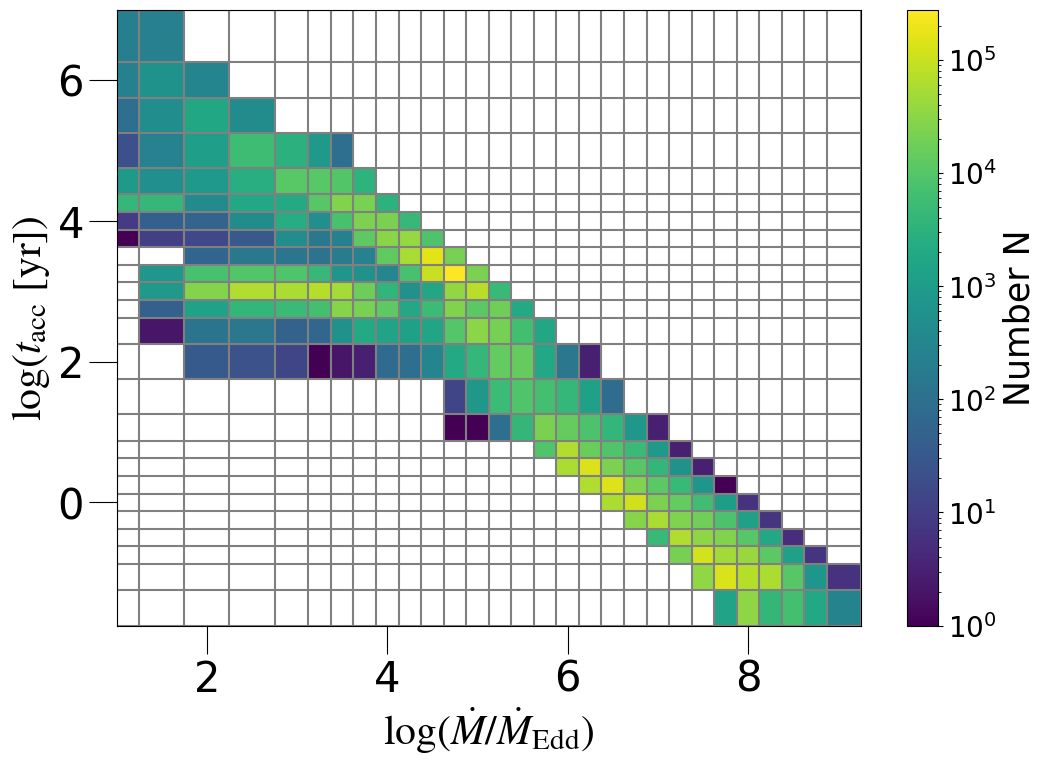

In [48]:
plot_2d_histgram_mtce_mdot_vs_tacc(Mdot_BH_value_MTCE_Edd, Tacc_BH_value_MTCE_Edd, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid, 
                                   'MTCE_BH_N_grid.pdf', Colormap='viridis', Bin_Guide=True)

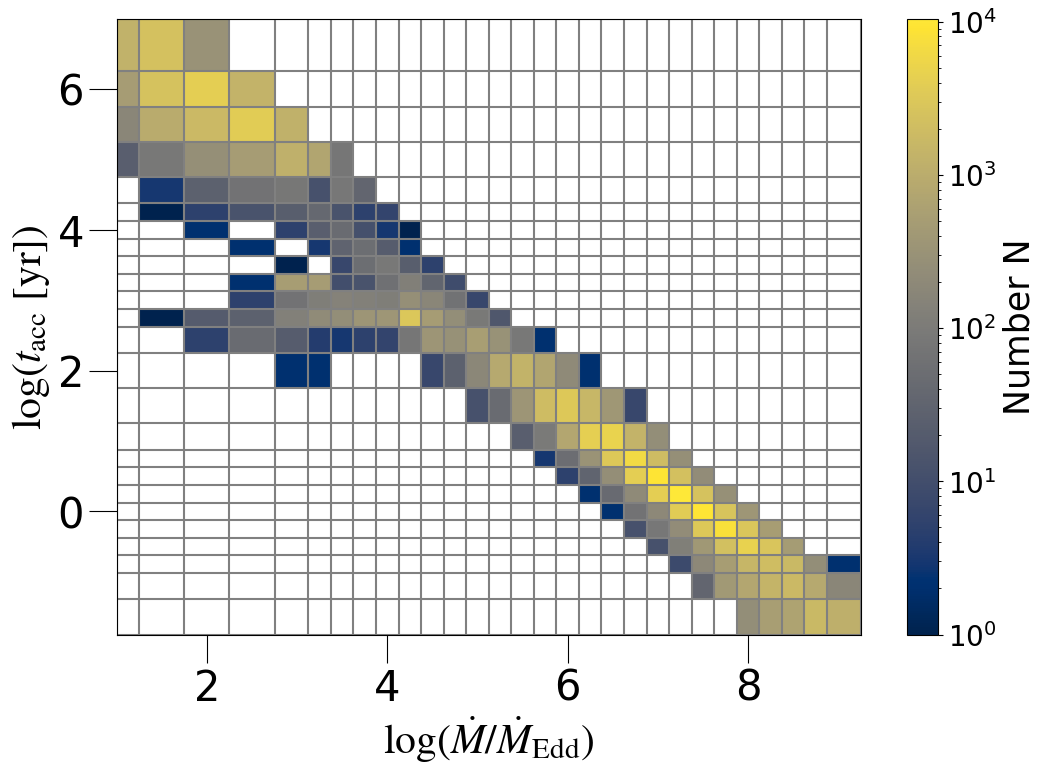

In [49]:
plot_2d_histgram_mtce_mdot_vs_tacc(Mdot_NS_value_MTCE_Edd, Tacc_NS_value_MTCE_Edd, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid, 
                                   'MTCE_NS_N_grid.pdf', Colormap='cividis', Bin_Guide=True)

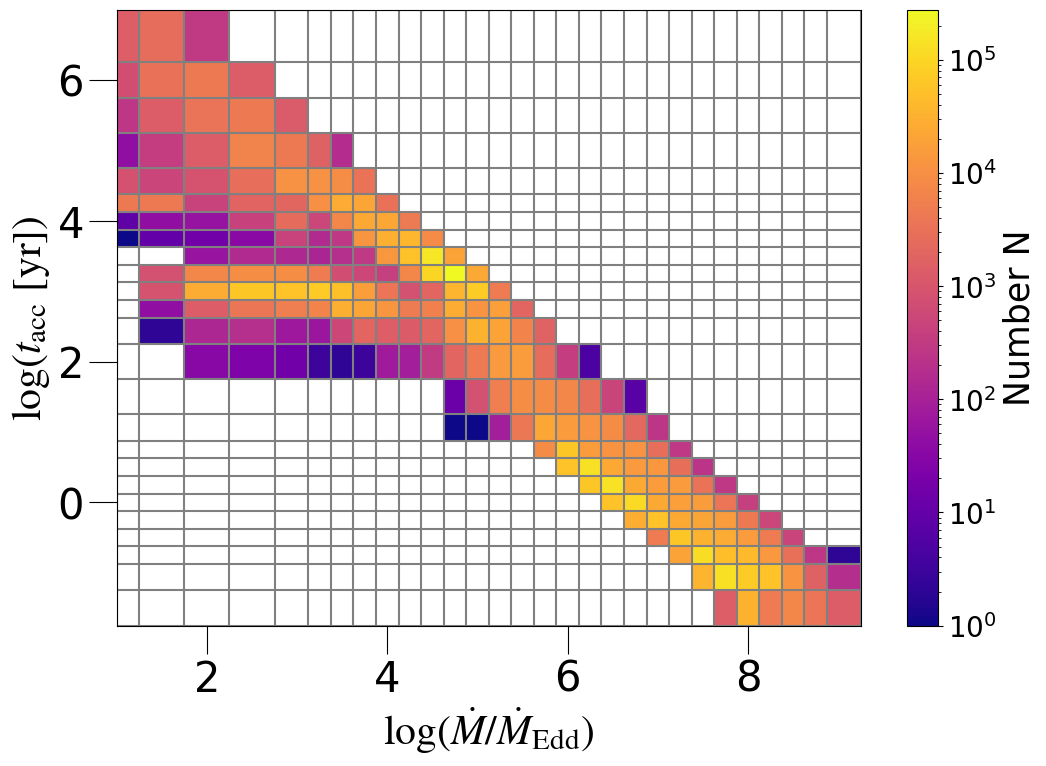

In [77]:
plot_2d_histgram_mtce_mdot_vs_tacc(Mdot_BHNS_value_MTCE_Edd, Tacc_BHNS_value_MTCE_Edd, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid, 
                                   'MTCE_BHNS_N_grid.pdf', Colormap='plasma', Bin_Guide=True)

## Plot 2D Histgram For CE Timescale ($10\times t_{\rm Orbital}$ vs. $t_{\rm Thermal}$)

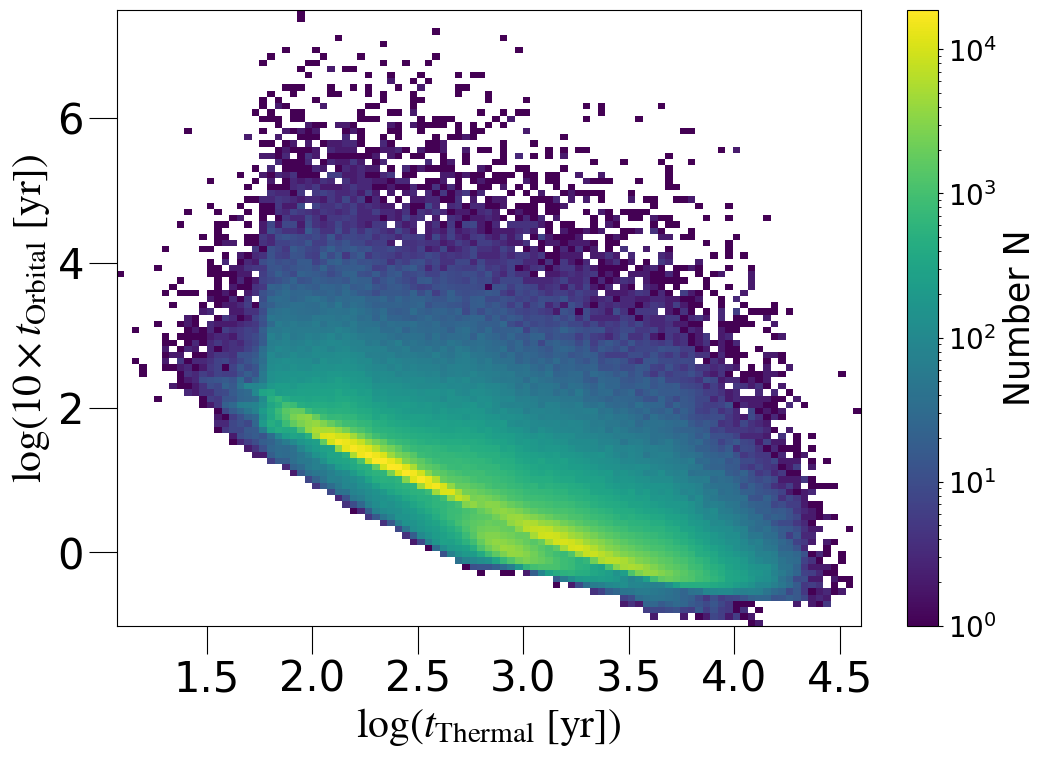

In [50]:
TKH_BH_value_CE_Edd = RLOF_BH_CE_Edd_Dropinf['Timescale_KH'].value
TCic_BH_value_CE_Edd = RLOF_BH_CE_Edd_Dropinf['Timescale_Cic'].value

TKH_BH_bin_CE_Edd_100 = np.logspace(np.log10(TKH_BH_value_CE_Edd.min()), np.log10(TKH_BH_value_CE_Edd.max()), 100)
TCic_BH_bin_CE_Edd_100 = np.logspace(np.log10(10*TCic_BH_value_CE_Edd.min()), np.log10(10*TCic_BH_value_CE_Edd.max()), 100)

fig, ax = plt.subplots(figsize = (12,8))

N, x, y = np.histogram2d(TKH_BH_value_CE_Edd, 10*TCic_BH_value_CE_Edd, bins=(TKH_BH_bin_CE_Edd_100, TCic_BH_bin_CE_Edd_100))

pcm = ax.pcolormesh(np.log10(x*Myr/yr), np.log10(y*Myr/yr), N.T, cmap='viridis', norm=LogNorm())
# pcm = ax.pcolormesh(x, y, N.T, cmap='viridis', norm=LogNorm())
cbar = plt.colorbar(pcm, ax=ax, label='Number N')
cbar.ax.tick_params(labelsize=20)
    
ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)
   
plt.xlabel(r'$\log(t_{\rm Thermal} {\rm ~[yr]})$', fontsize = 30)
plt.ylabel(r'$\log(10 \times t_{\rm Orbital} {\rm ~[yr]})$', fontsize = 30)
plt.savefig('./Figures/N/TKH_vs_TCic_BH.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

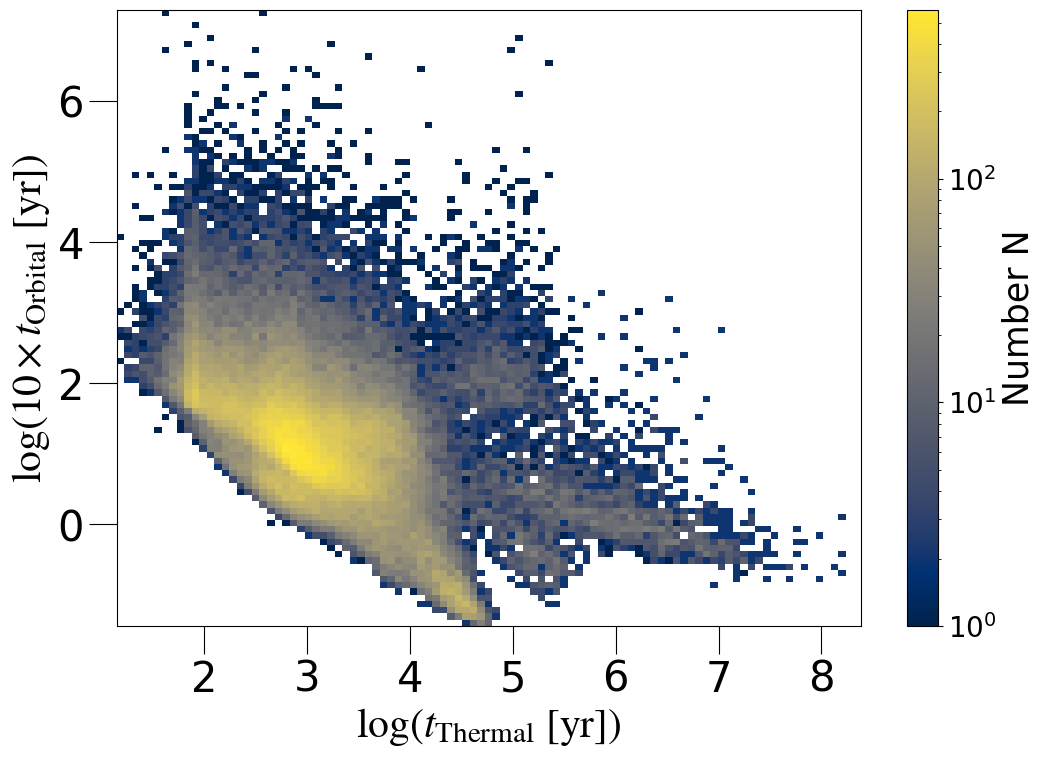

In [51]:
TKH_NS_value_CE_Edd = RLOF_NS_CE_Edd_Dropinf['Timescale_KH'].value
TCic_NS_value_CE_Edd = RLOF_NS_CE_Edd_Dropinf['Timescale_Cic'].value

TKH_NS_bin_CE_Edd_100 = np.logspace(np.log10(TKH_NS_value_CE_Edd.min()), np.log10(TKH_NS_value_CE_Edd.max()), 100)
TCic_NS_bin_CE_Edd_100 = np.logspace(np.log10(10*TCic_NS_value_CE_Edd.min()), np.log10(10*TCic_NS_value_CE_Edd.max()), 100)

fig, ax = plt.subplots(figsize = (12,8))

N, x, y = np.histogram2d(TKH_NS_value_CE_Edd, 10*TCic_NS_value_CE_Edd, bins=(TKH_NS_bin_CE_Edd_100, TCic_NS_bin_CE_Edd_100))

pcm = ax.pcolormesh(np.log10(x*Myr/yr), np.log10(y*Myr/yr), N.T, cmap='cividis', norm=LogNorm())
# pcm = ax.pcolormesh(x, y, N.T, cmap='viridis', norm=LogNorm())
cbar = plt.colorbar(pcm, ax=ax, label='Number N')
cbar.ax.tick_params(labelsize=20)
    
ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)
   
plt.xlabel(r'$\log(t_{\rm Thermal} {\rm ~[yr]})$', fontsize = 30)
plt.ylabel(r'$\log(10 \times t_{\rm Orbital} {\rm ~[yr]})$', fontsize = 30)
plt.savefig('./Figures/N/TKH_vs_TCic_NS.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Event Rate Analysis

## Reference
* COMAPS GitHub / Post Processing Tools (https://compas.readthedocs.io/en/latest/pages/User%20guide/Post-processing/post-processing.html)
    * Especially, this note (https://compas.readthedocs.io/en/latest/pages/User%20guide/Post-processing/notebooks/CosmicIntegration.html)
* Formalism
    * Broelgaarden et al. 2021 (https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.5028B/abstract)
<!--     * van Son et al. 2022 (https://ui.adsabs.harvard.edu/abs/2022ApJ...931...17V/abstract) -->
    * van Son et al. 2023 (https://ui.adsabs.harvard.edu/abs/2023ApJ...948..105V/abstract)
* Adoptive Sampling
    * Broekgaarden et al. 2019 (https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.5228B/abstract)

## find the average star forming mass evolved per binary in the Universe

We assume:
* IMF = Kroupa
* Mass Ratio $M_{2}/M_{1}$ = Uniform 

Procedure
1. Sampling primary stars from the Kroup IMF.
2. Sampling mass ratio from the uniform distribution.
3. Defining how many stars are binary.
4. Based on the mass ratio, we determine the secondary mass
5. Fomatting the binary systems: Fitting the data shape with COMPAS data.
6. Total mass of binary systems ($\sum_{i} (M_{1, i} + M_{2, i})$)
7. Making average mass per binary

In [52]:
def find_star_forming_mass_per_binary_sampling(m1=0.01, m2=0.08, m3=0.5, m4=200.0, a12=0.3, a23=1.3, a34=2.3,
                                               primary_mass_inverse_CDF=None, mass_ratio_inverse_CDF=None, SAMPLES=20000000, 
                                               binaryFraction = 0.7, Mlower = 10.* u.Msun, Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun):
    """
        Calculate the star forming mass evolved for each binary in the file.
        This function does this by sampling from the IMF and mass ratio distributions

        Args:
            mi                       --> [float]    masses at which to transition the slope of the IMF (ignored if primary_mass_inverse_CDF is not None)
            aij                      --> [float]    slope of the IMF between mi and mj (ignored if primary_mass_inverse_CDF is not None)
            primary_mass_inverse_CDF --> [function] a function that computes the inverse CDF functoin for the primary mass distribution
                                                    this defaults to the Kroupa IMF (which can be varied using mi, aij)
            mass_ratio_inverse_CDF   --> [function] a function that computes the inverse CDF function for the mass ratio distribution
                                                    this defaults to assuming a uniform mass ratio on [0, 1]
            SAMPLES                  --> [int]      number of samples to draw when creating a mock universe
            binaryFraction           --> [int]      Asusmed binary fraction, default = 0.7
            Mlower                   --> [int]      Minimum primary mass sampled by COMPAS default = 10 
            Mupper                   --> [int]      Maximum primary mass sampled by COMPAS default = 150
            m2_min                  --> [int]      Minimum secondary mass sampled by COMPAS default = 0.1
    """
    # if primary mass inverse CDF is None, assume the Kroupa IMF
    if primary_mass_inverse_CDF is None:
        primary_mass_inverse_CDF = lambda U: COMPAS_class.inverse_CDF_IMF(U, m1=m1, m2=m2, m3=m3, m4=m4, a12=a12, a23=a23, a34=a34)

    # if mass ratio inverse CDF function is None, assume uniform
    if mass_ratio_inverse_CDF is None:
        mass_ratio_inverse_CDF = lambda q: q

    # randomly sample a large number of masses from IMF, mass ratios from supplied function, binary for boolean
    primary_mass = primary_mass_inverse_CDF(np.random.rand(SAMPLES)) * u.Msun
    mass_ratio = mass_ratio_inverse_CDF(np.random.rand(SAMPLES))
    binary = np.random.rand(SAMPLES)

    # only fbin fraction of stars have a secondary (in a binary)
    binary_mask = binary < binaryFraction

    # assign each a random secondary mass, default 0 because single stars have m2=0 (surprisingly :P)
    secondary_mass = np.zeros(SAMPLES) * u.Msun
    secondary_mass[binary_mask] = primary_mass[binary_mask] * mass_ratio[binary_mask]

    # find the total mass of the whole population
    total_mass = np.sum(primary_mass) + np.sum(secondary_mass)

    # apply the COMPAS cuts on primary and secondary mass
    primary_mask = np.logical_and(primary_mass >= Mlower, primary_mass <= Mupper)
    secondary_mask = secondary_mass > m2_min
    full_mask = np.logical_and(primary_mask, secondary_mask)

    # find the total mass with COMPAS cuts
    total_mass_COMPAS = np.sum(primary_mass[full_mask]) + np.sum(secondary_mass[full_mask])

    # use the totals to find the ratio and return the average mass as well
    f_mass_sampled = total_mass_COMPAS / total_mass
    average_mass_COMPAS = total_mass_COMPAS / len(primary_mass[full_mask])

    # find the average star forming mass evolved per binary in the Universe
    mass_evolved_per_binary = average_mass_COMPAS / f_mass_sampled
    
    return mass_evolved_per_binary

In [53]:
n_systems = len(SYS['SEED'])
M1_min    = np.min(SYS['Mass@ZAMS(1)'][()]) #minimum ZAMS mass simulated

In [54]:
mass_evolved_per_binary = find_star_forming_mass_per_binary_sampling(binaryFraction = 0.7, Mlower = M1_min* u.Msun, 
                                                                     Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun)

In [55]:
print('mass_evolved_per_binary', mass_evolved_per_binary)

n_systems = len(SYS['SEED'])
Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)
print('Average_SF_mass_needed', Average_SF_mass_needed)

mass_evolved_per_binary 101.92219924180787 solMass
Average_SF_mass_needed 1019221992.4180788 solMass


## Star Formation Rate Density (SFRD)

SFRD is star forming mass per unit volume per year. We assume the analysical formalism propoersed by Madau & Dickinson 2014 (https://ui.adsabs.harvard.edu/abs/2014ARA%26A..52..415M/abstract)
$$
{\rm SFRD} = \frac{d^2 M}{dtdV_{c}} = a \frac{(1+z)^b}{1 + \left(\frac{1+z}{c}\right)^{d}} {\rm ~[M_{\odot}/yr/cMpc^{3}]},
$$
where $z$ is the redshift, and $a$, $b$, $c$, and $d$ is a fitting parameters. Fiducially, the parameters are $(a, b, c, d) = (0.017, 1.487, 4.442, 5.886)$

In [56]:
def find_sfr(redshifts, a = 0.017, b =1.487, c = 4.442, d = 5.886):
    """
        Calculate the star forming mass per unit volume per year using functional form of Madau & Dickinson 2014

        Args:
            redshifts --> [list of floats] List of redshifts at which to evaluate the sfr

        Returns:
            sfr       --> [list of floats] Star forming mass per unit volume per year for each redshift
    """
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

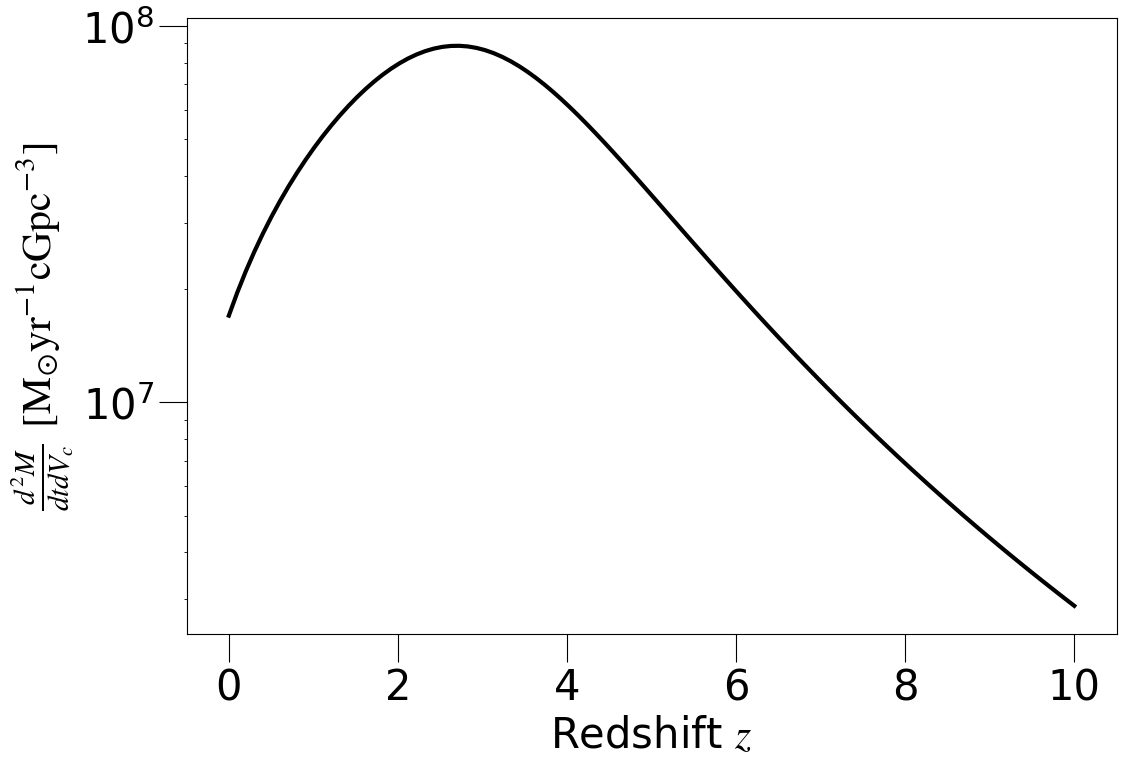

In [57]:
z_tmp = np.linspace(0, 10, 100)
SFRD = []
for z_value in z_tmp:
    SFRD.append(find_sfr(z_value, a = 0.017, b =1.487, c = 4.442, d = 5.886))
    
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,8))

plt.plot(z_tmp, SFRD, color = 'black', lw=3)

########
ax.tick_params(axis='both', which='major', labelsize=20, size=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.locator_params(axis='y', nbins=6)

plt.xlabel('Redshift $z$', fontsize = 30)
plt.ylabel(r'$\frac{d^2M}{dtdV_{c}}$ ${\rm [M_{\odot} yr^{-1} cGpc^{-3}]}$', fontsize = 30)

plt.yscale('log')
# plt.legend(fontsize = 15, ncol=2)
plt.savefig('./Figures/rate/SFRD.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Metallicity Distribution

Calculate the distribution of metallicities at different redshifts using a log skew normal distribution.

* Mean Metallicity
$$
\langle Z \rangle = \mu(z) = \mu_{0} \times 10^{\mu_{z}\cdot z}
$$
* Scale of the metallicity distribution with redshift (in van Son et al. 2023, $\sigma \to \omega$ ?)
$$
\sigma = \sigma_{0}\times 10^{\sigma_{z}\cdot z}
$$
* Parameter $\beta$
$$
\beta = \frac{\alpha}{\sqrt{1 + \alpha^2}}
$$
* Standard log-normal distribution (PDF)
$$
\phi\left(\frac{\ln Z-\xi}{\sigma}\right) = \frac{1}{\sqrt{2 \pi}} \exp \left\{-\frac{1}{2}\left(\frac{\ln Z-\xi}{\sigma}\right)^2\right\}
$$
* Cumulative of the log-normal distribution (CDF)
$$
\Phi\left(\alpha \frac{\ln Z-\xi}{\sigma}\right) = \frac{1}{2}\left[1+\operatorname{erf}\left\{\alpha \frac{\ln Z-\xi}{\sigma \sqrt{2}}\right\}\right]
$$ 
* The redshift dependence of the location
$$
\xi(z) = \log\left( \frac{\langle Z \rangle}{2\Phi(\beta \sigma)} \right) - \frac{\sigma^2}{2}
$$
* Log metallicity distribution
$$
\frac{dP(Z, z)}{d\log Z} = \frac{2}{\sigma} \times \phi\left(\frac{\ln Z-\xi}{\sigma}\right) \times \Phi\left(\alpha \frac{\ln Z-\xi}{\sigma}\right)
$$ 


In [58]:
def find_metallicity_distribution(redshifts = 0,  min_logZ_COMPAS = np.log(0.0001), max_logZ_COMPAS = np.log(0.03),
                                  mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):

    #     redshifts, np.log(0.0001),# np.log(0.03),
    #                                   mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
    #                                   min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):

    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    =  0.035    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.25    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 0.39     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.00     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = 0.00    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """ 
    ##################################
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma) 
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI))

    ##################################
    # create a range of metallicities (thex-values, or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)


    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, p_draw_metallicity

################################################################

dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(np.linspace(0,0.1,1))
print('is dpdz normalized? ',  np.sum((dPdlogZ))/100)

is dpdz normalized?  0.9999999999999999


## Rate Estimation by COMPAS

Here, now we negrect the redshift dependence, because the observable volume is up to a few Gpc ($z\sim 0$), i.e., $\rm SFRD(z=0)$ and the Volume unit is ${\rm /Mpc^3}$

In the case that you take the redshift dependence into account, use the following formalism:
$$
\mathcal{R} = \int \mathrm{d} Z_{\mathrm{i}} \int_0^{t_{\mathrm{radio}}} \mathrm{d} t_{\mathrm{delay}} \operatorname{SFRD} \left(Z_{\mathrm{i}}, t_{\mathrm{form}}=t_{\mathrm{radio}}-t_{\mathrm{delay}}\right) \mathcal{R}_{\text {form}}\left(Z_{\mathrm{i}}, t_{\mathrm{delay}}\right),
$$
where $t_{\mathrm{delay}}$ is the delay time from the birth to the radio emission, and $t_{\mathrm{radio}}$ is the time of RLOF/CE mesured from the early Universe (ref: https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.5028B/abstract).

In [59]:
################################################
# Create a new table events per metallicity bin
################################################
events_per_Zbin = Table()

################################################
# Create metallicity bins
################################################
Metal_bins  = np.linspace(-4, np.log10(0.03), 15)
center_bins = (Metal_bins[1:] + Metal_bins[:-1])/2.    
binwidts    = np.diff(Metal_bins)
events_per_Zbin['Metallicity_bin'] = center_bins
events_per_Zbin['dlnZ']            = binwidts

dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(np.linspace(0,0.1,1))#  metallicity distribution at redshift 0
# bin your analytical metals into your bigger metal bins
inds = np.digitize(np.log10(metallicities), Metal_bins)
# 'integrate' the metallicity probability for every metal-bin (assuming equal-size in logZ bins)
metal_prob = []
for m in range(len(center_bins)):
    metal_prob.append(np.sum(dPdlogZ[:,inds == m+1]))   #inds counts from 1, while m starts at 0
# Add to table
metal_prob = np.array(metal_prob)
events_per_Zbin['dPdlnZ'] = metal_prob/100/p_draw_metallicity
    
# Digitize your systems per metallicity
SYSbin_indices = np.digitize(np.log10(SYS['Metallicity@ZAMS(1)']) , Metal_bins, right=True)  
    
# AIS fraction per metal bin normalized
events_per_Zbin['mixture_weight_sum']  = np.bincount(SYSbin_indices, weights=SYS['mixture_weight'])[1:]/sum(SYS['mixture_weight'])

Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)
# if verbose: print('Average_SF_mass_needed', Average_SF_mass_needed)
        
events_per_Zbin['Average_SF_mass_needed'] = Average_SF_mass_needed

In [60]:
def convert_rate(events_per_Zbin, data, Mdot_bin, Tacc_bin):
    
    events_per_Zbin_addParam = events_per_Zbin.copy()
    
    extracted_data = []
    param_id = 0

    for i in range(len(Mdot_bin) - 1):
        for j in range(len(Tacc_bin) - 1):
            Mdot_lower = Mdot_bin[i]
            Mdot_upper = Mdot_bin[i + 1]
            Tacc_lower = Tacc_bin[j]
            Tacc_upper = Tacc_bin[j + 1]
            
            filter_bool = ((data['Eddington'] >= Mdot_lower) & (data['Eddington'] < Mdot_upper) & 
                           (data['Timescale'] >= Tacc_lower) & (data['Timescale'] < Tacc_upper))
            filtered_data = data[filter_bool]
            
            param = f"param_{param_id}"
            SYS[param] = np.in1d(SYS['SEED'], filtered_data['SEED'])
            events_per_Zbin_addParam[param] = np.bincount(SYSbin_indices, weights=SYS[param]*SYS['mixture_weight'])[1:]# Bincount counts the 0's, omit them with [1:]

            param_id = param_id+1
            
    rate = []
    for i in range((len(Mdot_bin)-1)*(len(Tacc_bin)-1)):
        param = f'param_{i}'
        rate.append(sum(events_per_Zbin_addParam[param] * events_per_Zbin_addParam['dPdlnZ'] * 
                        find_sfr(0)/events_per_Zbin_addParam['Average_SF_mass_needed'] )) # yr-1 Gpc-3
    rate = np.array(rate)
    rate_2d = rate.reshape((len(Mdot_bin)-1), (len(Tacc_bin)-1)) # convert 2d array
    
    return rate_2d

In [61]:
data_BH_MT = RLOF_BH_MT_Edd[['SEED', 'Eddington', 'Timescale']]
data_BH_CE = RLOF_BH_CE_Edd[['SEED', 'Eddington', 'Timescale']]

data_NS_MT = RLOF_NS_MT_Edd[['SEED', 'Eddington', 'Timescale']]
data_NS_CE = RLOF_NS_CE_Edd[['SEED', 'Eddington', 'Timescale']]

In [62]:
Rate_BH_MT = convert_rate(events_per_Zbin, data_BH_MT, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid)
Rate_BH_CE = convert_rate(events_per_Zbin, data_BH_CE, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid)
Rate_BH_MTCE = (convert_rate(events_per_Zbin, data_BH_MT, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid) + 
                convert_rate(events_per_Zbin, data_BH_CE, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid))

Rate_NS_MT = convert_rate(events_per_Zbin, data_NS_MT, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid)
Rate_NS_CE = convert_rate(events_per_Zbin, data_NS_CE, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid)
Rate_NS_MTCE = (convert_rate(events_per_Zbin, data_NS_MT, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid) + 
                convert_rate(events_per_Zbin, data_NS_CE, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid))

In [63]:
Rate_BHNS_MT = Rate_BH_MT + Rate_NS_MT
Rate_BHNS_CE = Rate_BH_CE + Rate_NS_CE
Rate_BHNS_MTCE = Rate_BH_MTCE + Rate_NS_MTCE

In [64]:
def plot_2d_histgram_rate_mdot_vs_tacc (data, Mdot_bin, Tacc_bin, output, vmin, Colormap='viridis', Bin_Guide=False):

    fig, ax = plt.subplots(figsize = (12,8))
    
    pcm = ax.pcolormesh(np.log10(Mdot_bin), np.log10(Tacc_bin*Myr/yr), data.T, cmap=Colormap, norm=LogNorm(vmin=vmin))
    cbar = plt.colorbar(pcm, ax=ax, label=r'Event Rate [$\rm /Gpc^{3}/yr$]', extend='min')
    cbar.ax.tick_params(labelsize=20)

    
    ax.tick_params(axis='both', which='major', labelsize=20, size=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.locator_params(axis='y', nbins=6)
    
    if Bin_Guide == True:
        for i in range(len(Mdot_bin)):
            plt.axvline(np.log10(Mdot_bin[i]), color='gray')
    
        for i in range(len(Tacc_bin)):
            plt.axhline(np.log10(Tacc_bin[i]*Myr/yr), color='gray')
    
    plt.xlabel(r'$\log(\dot{M} / \dot{M}_{\rm Edd})$', fontsize = 30)
    plt.ylabel(r'$\log(t_{\rm acc} {\rm ~[yr]})$', fontsize = 30)
    plt.savefig('./Figures/rate/{}'.format(output), bbox_inches='tight', pad_inches=0.1)
    plt.show()
    

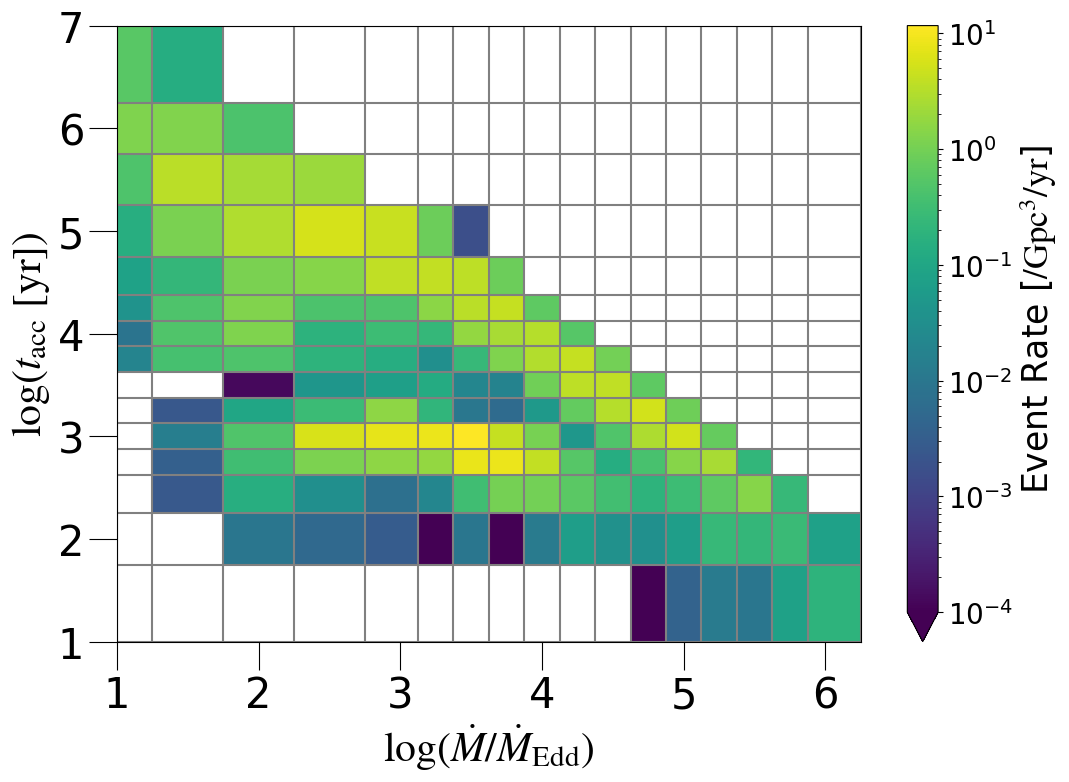

In [65]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_BH_MT, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid, 
                                   'rate_BH_MT_grid.pdf', vmin=1e-4, Colormap='viridis', Bin_Guide=True)

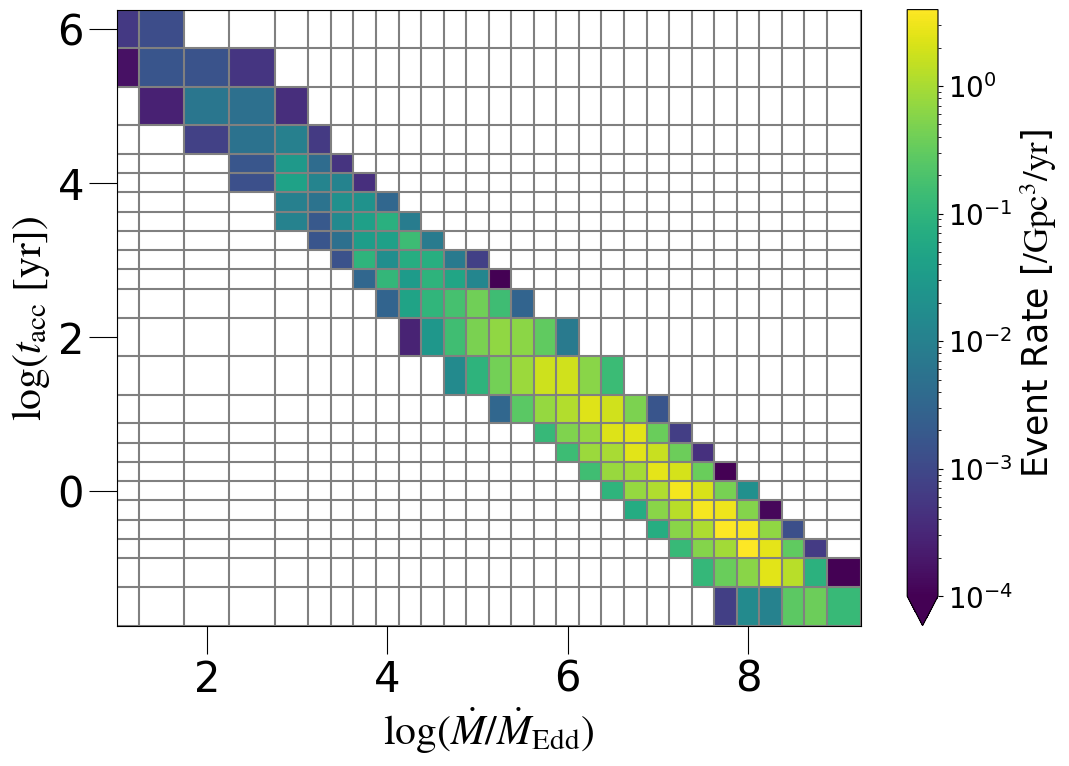

In [66]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_BH_CE, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid, 
                                   'rate_BH_CE_grid.pdf', vmin=1e-4, Colormap='viridis', Bin_Guide=True)

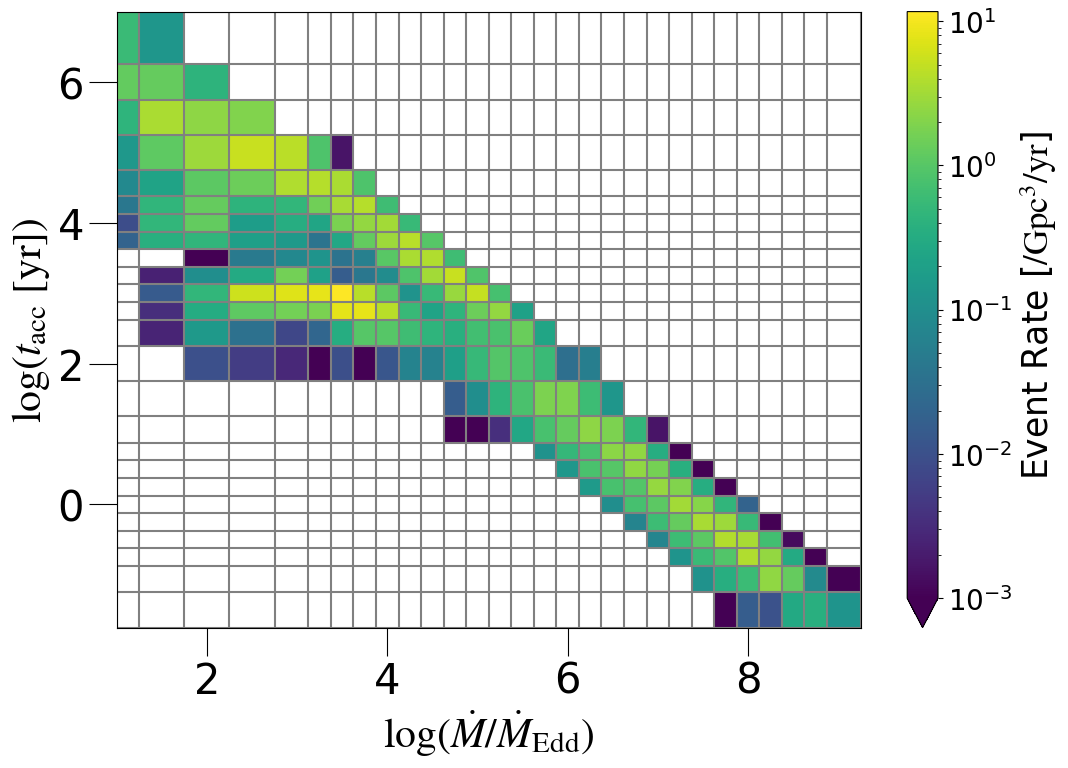

In [67]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_BH_MTCE, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid, 
                                   'rate_BH_MTCE_grid.pdf', vmin=1e-3, Colormap='viridis', Bin_Guide=True)

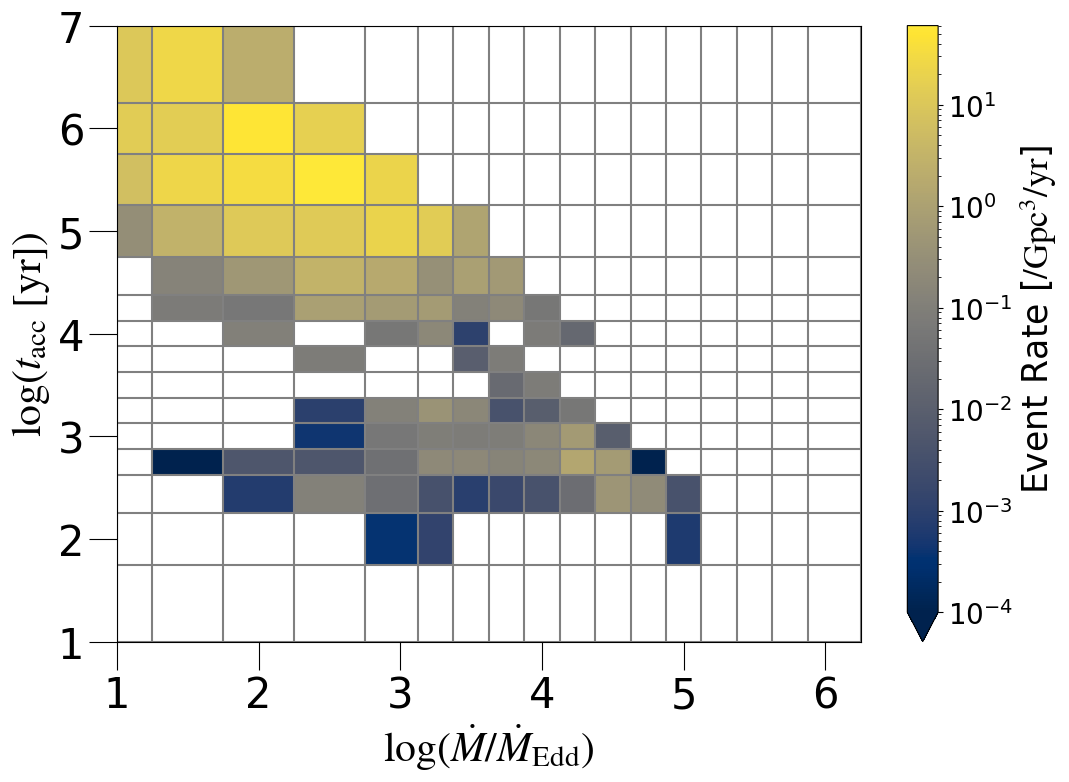

In [68]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_NS_MT, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid, 
                                   'rate_NS_MT_grid.pdf', vmin=1e-4, Colormap='cividis', Bin_Guide=True)

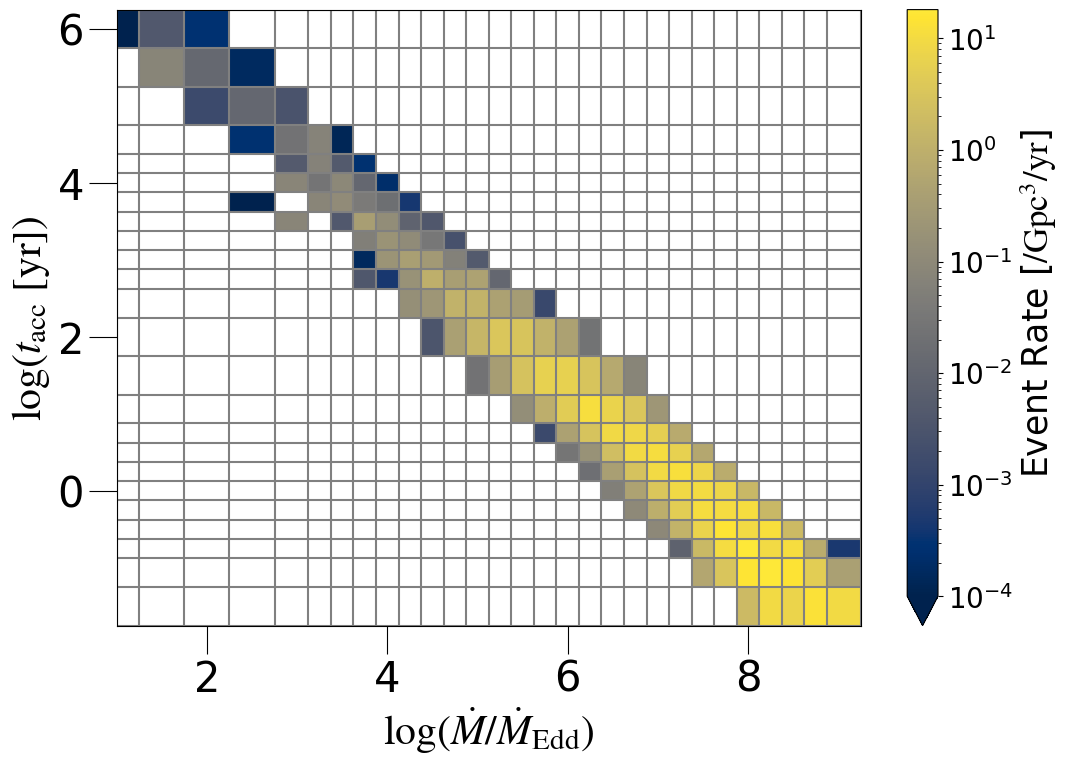

In [69]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_NS_CE, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid, 
                                   'rate_NS_CE_grid.pdf', vmin=1e-4, Colormap='cividis', Bin_Guide=True)

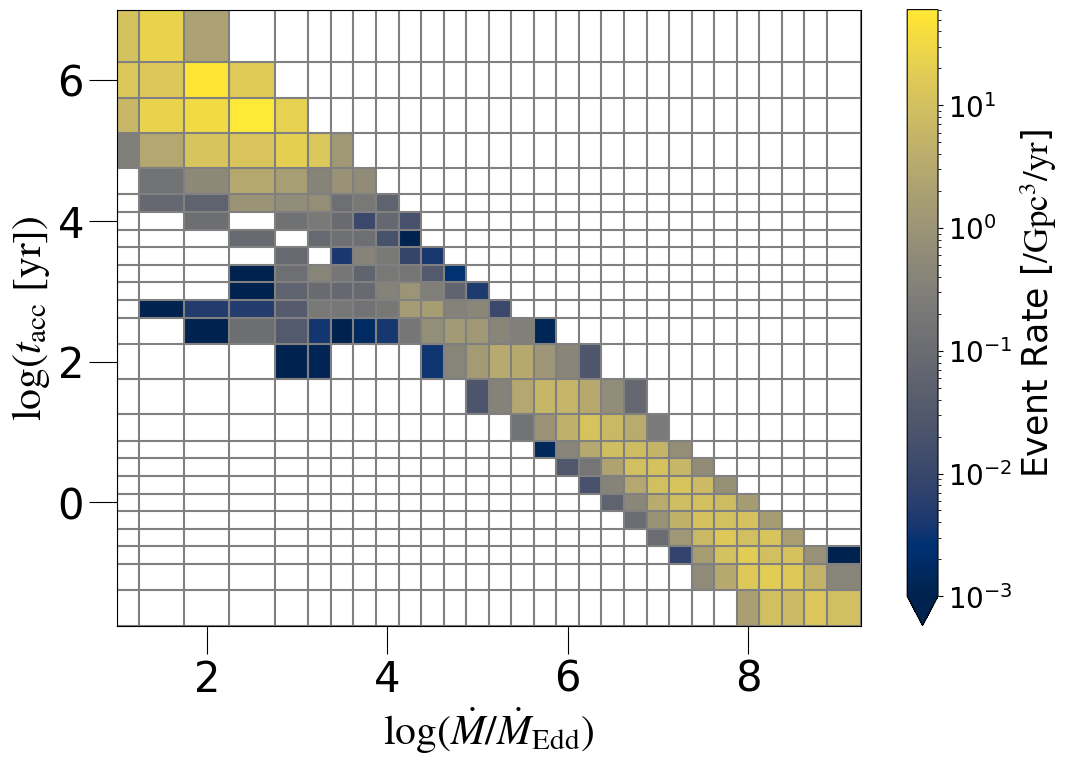

In [70]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_NS_MTCE, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid, 
                                   'rate_NS_MTCE_grid.pdf', vmin=1e-3, Colormap='cividis', Bin_Guide=True)

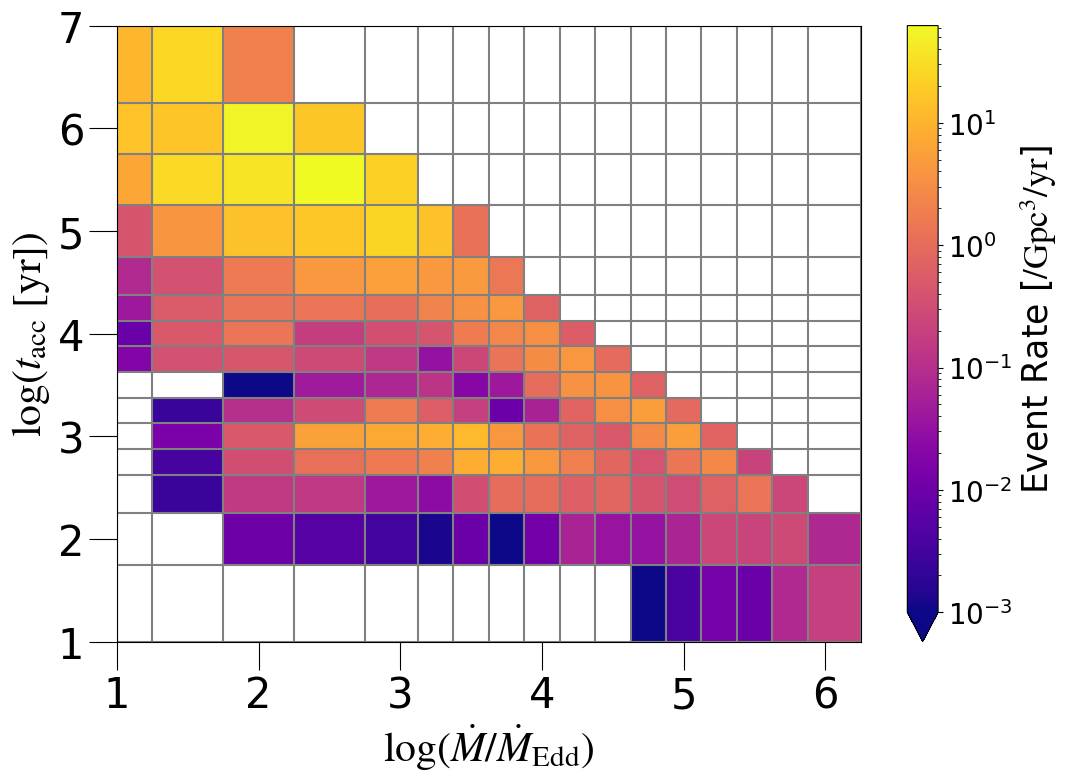

In [71]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_BHNS_MT, Mdot_bin_MT_Edd_grid, Tacc_bin_MT_Edd_grid, 
                                   'rate_BHNS_MT_grid.pdf', vmin=1e-3, Colormap='plasma', Bin_Guide=True)

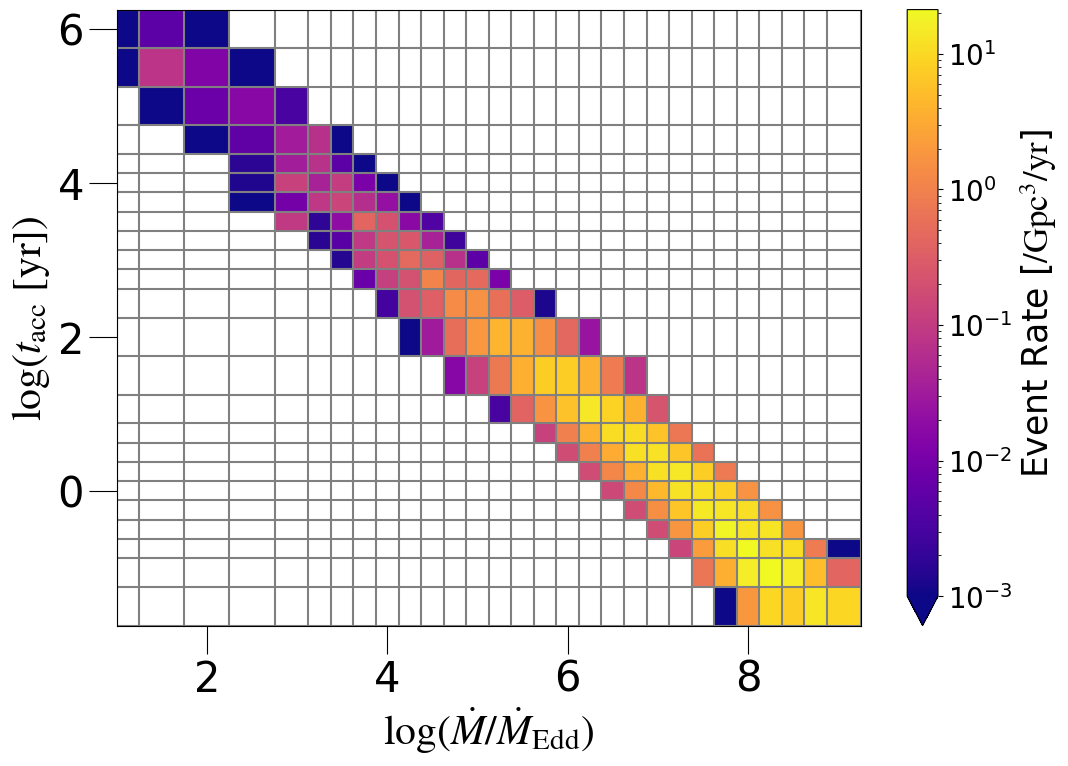

In [72]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_BHNS_CE, Mdot_bin_CE_Edd_grid, Tacc_bin_CE_Edd_grid, 
                                   'rate_BHNS_CE_grid.pdf', vmin=1e-3, Colormap='plasma', Bin_Guide=True)

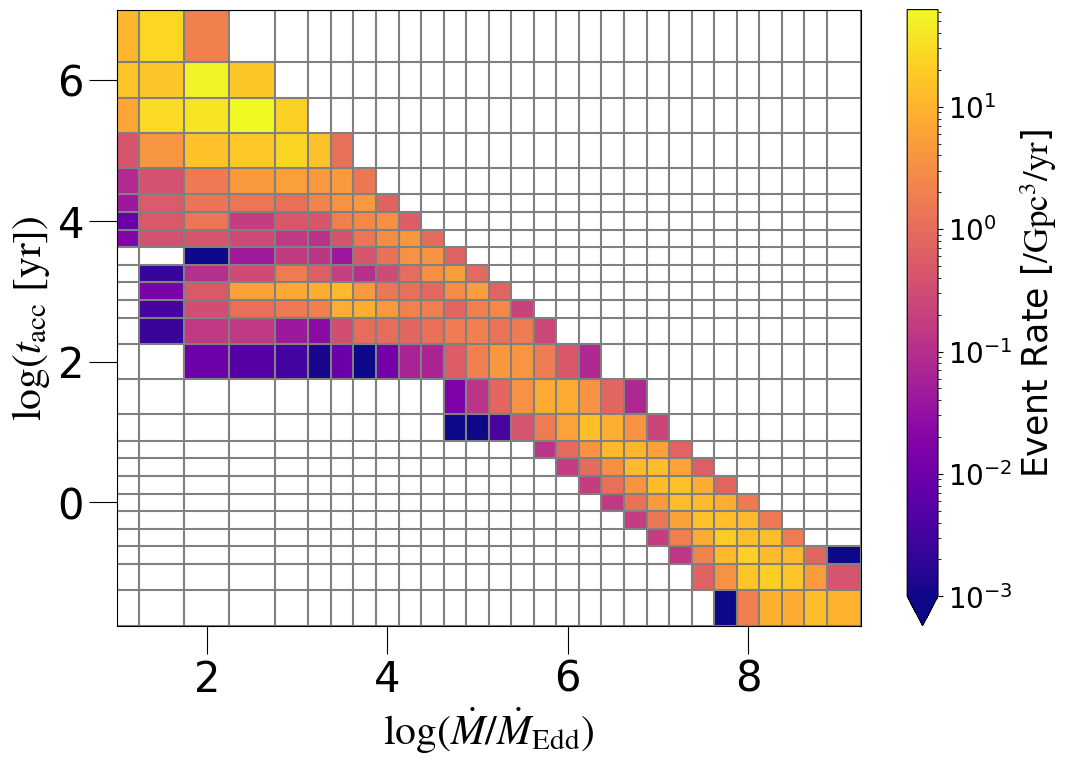

In [73]:
plot_2d_histgram_rate_mdot_vs_tacc(Rate_BHNS_MTCE, Mdot_bin_MTCE_Edd_grid, Tacc_bin_MTCE_Edd_grid, 
                                   'rate_BHNS_MTCE_grid.pdf', vmin=1e-3, Colormap='plasma', Bin_Guide=True)

In [74]:
np.savetxt("./rate_tables/rate_bh_mt.csv", Rate_BH_MT, delimiter=",", fmt='%e')
np.savetxt("./rate_tables/rate_bh_ce.csv", Rate_BH_CE, delimiter=",", fmt='%e')
np.savetxt("./rate_tables/rate_bh_mtce.csv", Rate_BH_MTCE, delimiter=",", fmt='%e')

np.savetxt("./rate_tables/rate_ns_mt.csv", Rate_NS_MT, delimiter=",", fmt='%e')
np.savetxt("./rate_tables/rate_ns_ce.csv", Rate_NS_CE, delimiter=",", fmt='%e')
np.savetxt("./rate_tables/rate_ns_mtce.csv", Rate_NS_MTCE, delimiter=",", fmt='%e')

np.savetxt("./rate_tables/rate_bhns_mt.csv", Rate_BHNS_MT, delimiter=",", fmt='%e')
np.savetxt("./rate_tables/rate_bhns_ce.csv", Rate_BHNS_CE, delimiter=",", fmt='%e')
np.savetxt("./rate_tables/rate_bhns_mtce.csv", Rate_BHNS_MTCE, delimiter=",", fmt='%e')